# Data preparing

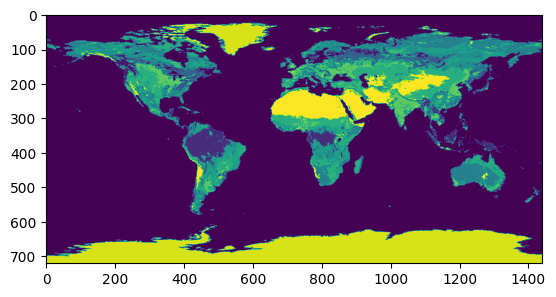

In [1]:
import numpy as np
land_cover = np.load('constant_masks/land_cover.npy')
soil_type = np.load('constant_masks/soil_type.npy')
topography_ocean = np.load('constant_masks/topography_ocean.npy')
topography = np.load('constant_masks/topography.npy')
import matplotlib.pyplot as plt
plt.imshow(land_cover)

Input tensor shape: torch.Size([1, 4, 721, 1440])
Output tensor shape: torch.Size([1, 96, 181, 360])


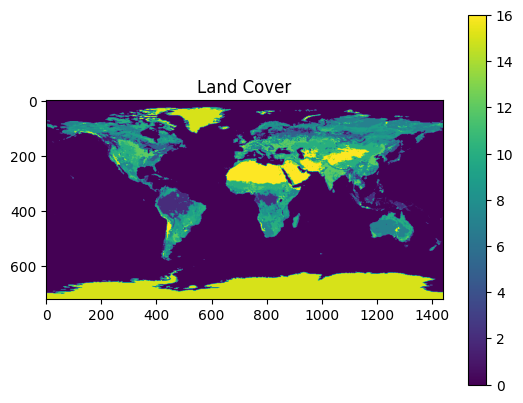

In [3]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

input_tensor = torch.load('constant_masks/input_tensor.pt', weights_only=False)


# 打印输入张量形状
print("Input tensor shape:", input_tensor.shape)

# 定义卷积层
# 输入通道数 = 4，输出通道数 = 96，卷积核大小 = 5x5，步长 = 4
conv_layer = nn.Conv2d(in_channels=4, out_channels=96, kernel_size=5, stride=4, padding=2)

# 执行卷积操作
output_tensor = conv_layer(input_tensor)

# 打印输出张量形状
print("Output tensor shape:", output_tensor.shape)

# 将输出转换为 NumPy 数组（如果需要进一步处理）
output_array = output_tensor.detach().numpy()

# 可视化输入 land_cover 栅格
plt.imshow(land_cover, cmap='viridis')
plt.colorbar()
plt.title('Land Cover')
plt.show()

# Canglong - origin

In [1]:
import torch
from canglong import Canglong

/usr/local/miniconda3/envs/torch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = Canglong().cuda()
input_upper_air = torch.randn(1, 10, 5, 2, 721, 1440).cuda()
input_surface = torch.randn(1, 26, 2, 721, 1440).cuda()
output_surface, output_upper_air = model(input_surface, input_upper_air)
print(output_surface.shape)
print(output_upper_air.shape)

/usr/local/miniconda3/envs/torch/lib/python3.10/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


torch.Size([1, 26, 1, 721, 1440])
torch.Size([1, 10, 5, 1, 721, 1440])


In [2]:
import h5py as h5
surface, upper_air = h5.File('/gz-data/ERA5_2023_weekly_new.h5')['surface'], h5.File('/gz-data/ERA5_2023_weekly_new.h5')['upper_air']
print(f"Surface data shape: {surface.shape}")
print(f"Upper air data shape: {upper_air.shape}")

Surface data shape: (52, 26, 721, 1440)
Upper air data shape: (52, 10, 5, 721, 1440)


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
from tqdm import tqdm
import h5py as h5

class WeatherDataset(Dataset):
    def __init__(self, surface_data, upper_air_data, start_idx, end_idx):
        """
        初始化气象数据集 - 按时间序列顺序划分
        
        参数:
            surface_data: 表面数据，形状为 [17, 100, 721, 1440]
            upper_air_data: 高空数据，形状为 [7, 5, 100, 721, 1440]
            start_idx: 开始索引
            end_idx: 结束索引
        """
        self.surface_data = surface_data
        self.upper_air_data = upper_air_data
        self.length = end_idx - start_idx - 2  # 减2确保有足够的目标数据
        
        print(f"Dataset from index {start_idx} to {end_idx}, sample count: {self.length}")
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        # 提取输入数据 (t和t+1时刻)
        input_surface = self.surface_data[idx:idx+2]  # [1, 17, 2, 721, 1440]
        
        # 提取高空数据 (t和t+1时刻)
        input_upper_air = self.upper_air_data[idx:idx+2]  # [1, 7, 5, 2, 721, 1440]
        
        # 提取目标数据 (t+2时刻)
        target_surface = self.surface_data[idx+2]  # [1, 16, 721, 1440]
        target_upper_air = self.upper_air_data[idx+2]  # [1, 7, 4, 721, 1440]
        
        return input_surface, input_upper_air, target_surface, target_upper_air

# 设置随机种子
torch.manual_seed(42)
np.random.seed(42)

# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 加载数据
print("Loading data...")
input_surface, input_upper_air = h5.File('/gz-data/ERA5_2023_weekly_new.h5')['surface'], h5.File('/gz-data/ERA5_2023_weekly_new.h5')['upper_air']
print(f"Surface data shape: {input_surface.shape}") #(52, 17, 721, 1440)
print(f"Upper air data shape: {input_upper_air.shape}") #(52, 7, 5, 721, 1440)

# 计算数据集划分点 - 按照6:2:2的时间序列划分
total_samples = 52#input_surface.shape[0]  # 假设为100
train_end = 30#int(total_samples * 0.6)  # 60
valid_end = 40#int(total_samples * 0.8)  # 80

# 创建数据集
train_dataset = WeatherDataset(input_surface, input_upper_air, start_idx=0, end_idx=train_end)
valid_dataset = WeatherDataset(input_surface, input_upper_air, start_idx=train_end, end_idx=valid_end)
test_dataset = WeatherDataset(input_surface, input_upper_air, start_idx=valid_end, end_idx=total_samples)

# 创建数据加载器 - 使用较小的batch size以便于调试
batch_size = 1  # 小batch size便于调试
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=16)  # 不打乱时间顺序
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=16)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=16)

print(f"Created data loaders with batch size {batch_size}")
import sys
sys.path.append('code_v2')
from convert_dict_to_pytorch_arrays_v2 import load_normalization_arrays

# 调用函数获取四个数组
json = '/home/CanglongPhysics/code_v2/ERA5_1940_2023_mean_std_v2.json'
surface_mean, surface_std, upper_mean, upper_std = load_normalization_arrays(json)
print(surface_mean.shape, upper_mean.shape)

Using device: cuda
Loading data...
Surface data shape: (52, 26, 721, 1440)
Upper air data shape: (52, 10, 5, 721, 1440)
Dataset from index 0 to 30, sample count: 28
Dataset from index 30 to 40, sample count: 8
Dataset from index 40 to 52, sample count: 10
Created data loaders with batch size 1
(1, 26, 1, 721, 1440) (1, 10, 5, 1, 721, 1440)


In [4]:
# 创建模型
model = Canglong()
#model = torch.load('/home/CanglongPhysics/checkpoints_v3/model_v1_new.pth')
# 多GPU训练
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(model)

# 将模型移动到设备
model.to(device)

# 创建优化器和损失函数
optimizer = optim.Adam(model.parameters(), lr=0.0005 * 3)
criterion = nn.MSELoss()

# 创建保存目录
save_dir = 'checkpoints_v1'
os.makedirs(save_dir, exist_ok=True)

# 训练参数
num_epochs = 50
best_valid_loss = float('inf')
checkpoint_interval = 25  # 每25个epoch保存一次checkpoint

# 训练循环
print("Starting training...")
for epoch in range(num_epochs):
    # 训练阶段
    model.train()
    train_loss = 0.0
    surface_loss = 0.0
    upper_air_loss = 0.0
    
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
    for input_surface, input_upper_air, target_surface, target_upper_air in train_pbar:
        # 将数据移动到设备
        input_surface = ((input_surface.permute(0, 2, 1, 3, 4) - surface_mean) / surface_std).to(device)
        input_upper_air = ((input_upper_air.permute(0, 2, 3, 1, 4, 5) - upper_mean) / upper_std).to(device)
        target_surface = ((target_surface.unsqueeze(2) - surface_mean) / surface_mean).to(device)
        target_upper_air = ((target_upper_air.unsqueeze(3) - upper_mean) / upper_std).to(device)
        
        # 清除梯度
        optimizer.zero_grad()
        
        # 前向传播
        output_surface, output_upper_air = model(input_surface, input_upper_air)
        
        # 计算损失
        loss_surface = criterion(output_surface, target_surface)
        loss_upper_air = criterion(output_upper_air, target_upper_air)
        loss = loss_surface + loss_upper_air
        
        # 反向传播和优化
        loss.backward()
        optimizer.step()
        
        # 累加损失
        batch_loss = loss.item()
        train_loss += batch_loss
        surface_loss += loss_surface.item()
        upper_air_loss += loss_upper_air.item()
        
        # 更新进度条
        train_pbar.set_postfix({
            "loss": f"{batch_loss:.6f}",
            "surface": f"{loss_surface.item():.6f}",
            "upper_air": f"{loss_upper_air.item():.6f}"
        })
    
    # 计算平均训练损失
    train_loss = train_loss / len(train_loader)
    surface_loss = surface_loss / len(train_loader)
    upper_air_loss = upper_air_loss / len(train_loader)
    
    # 验证阶段
    model.eval()
    valid_loss = 0.0
    valid_surface_loss = 0.0
    valid_upper_air_loss = 0.0
    
    with torch.no_grad():
        valid_pbar = tqdm(valid_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Valid]")
        for input_surface, input_upper_air, target_surface, target_upper_air in valid_pbar:
            # 将数据移动到设备
            input_surface = ((input_surface.permute(0, 2, 1, 3, 4) - surface_mean) / surface_std).to(device)
            input_upper_air = ((input_upper_air.permute(0, 2, 3, 1, 4, 5) - upper_mean) / upper_std).to(device)
            target_surface = ((target_surface.unsqueeze(2) - surface_mean) / surface_mean).to(device)
            target_upper_air = ((target_upper_air.unsqueeze(3) - upper_mean) / upper_std).to(device)
            
            # 前向传播
            output_surface, output_upper_air = model(input_surface, input_upper_air)
            
            # 计算损失
            loss_surface = criterion(output_surface, target_surface)
            loss_upper_air = criterion(output_upper_air, target_upper_air)
            loss = loss_surface + loss_upper_air
            
            # 累加损失
            batch_loss = loss.item()
            valid_loss += batch_loss
            valid_surface_loss += loss_surface.item()
            valid_upper_air_loss += loss_upper_air.item()
            
            # 更新进度条
            valid_pbar.set_postfix({
                "loss": f"{batch_loss:.6f}",
                "surface": f"{loss_surface.item():.6f}",
                "upper_air": f"{loss_upper_air.item():.6f}"
            })
    
    # 计算平均验证损失
    valid_loss = valid_loss / len(valid_loader)
    valid_surface_loss = valid_surface_loss / len(valid_loader)
    valid_upper_air_loss = valid_upper_air_loss / len(valid_loader)
    
    # 打印损失
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train - Total: {train_loss:.6f}, Surface: {surface_loss:.6f}, Upper Air: {upper_air_loss:.6f}")
    print(f"  Valid - Total: {valid_loss:.6f}, Surface: {valid_surface_loss:.6f}, Upper Air: {valid_upper_air_loss:.6f}")
    
    # 每25个epoch保存checkpoint
    if (epoch + 1) % checkpoint_interval == 0:
        checkpoint_path = f"{save_dir}/model_v1_epoch{epoch+1}.pth"
        torch.save(model.module.state_dict() if hasattr(model, 'module') else model.state_dict(), checkpoint_path)
        print(f"  Checkpoint saved to {checkpoint_path}")

# 保存最终模型
final_path = f"{save_dir}/model_v1_final.pth"
torch.save(model.module.state_dict() if hasattr(model, 'module') else model.state_dict(), final_path)
print(f"Training completed! Final model saved to {final_path}")

Starting training...


Epoch 1/50 [Valid]: 100%|██████████| 8/8 [00:30<00:00,  3.85s/it, loss=149.261841, surface=148.513382, upper_air=0.748461]


Epoch 1/50
  Train - Total: 161.684027, Surface: 160.912259, Upper Air: 0.771768
  Valid - Total: 133.548191, Surface: 132.907270, Upper Air: 0.640922


Epoch 2/50 [Valid]: 100%|██████████| 8/8 [00:31<00:00,  3.95s/it, loss=138.937759, surface=138.284088, upper_air=0.653674]


Epoch 2/50
  Train - Total: 109.476969, Surface: 108.884187, Upper Air: 0.592782
  Valid - Total: 107.798380, Surface: 107.240565, Upper Air: 0.557815


Epoch 3/50 [Valid]: 100%|██████████| 8/8 [00:30<00:00,  3.75s/it, loss=139.692703, surface=139.034164, upper_air=0.658542]


Epoch 3/50
  Train - Total: 100.823017, Surface: 100.257804, Upper Air: 0.565213
  Valid - Total: 107.385134, Surface: 106.833412, Upper Air: 0.551721


Epoch 4/50 [Valid]: 100%|██████████| 8/8 [00:30<00:00,  3.79s/it, loss=140.603027, surface=139.979980, upper_air=0.623051]


Epoch 4/50
  Train - Total: 100.034336, Surface: 99.500580, Upper Air: 0.533756
  Valid - Total: 107.240746, Surface: 106.716290, Upper Air: 0.524458


Epoch 5/50 [Valid]: 100%|██████████| 8/8 [00:30<00:00,  3.77s/it, loss=137.946396, surface=137.334015, upper_air=0.612377]


Epoch 5/50
  Train - Total: 98.735826, Surface: 98.216177, Upper Air: 0.519649
  Valid - Total: 105.794224, Surface: 105.281235, Upper Air: 0.512990


Epoch 6/50 [Valid]: 100%|██████████| 8/8 [00:30<00:00,  3.81s/it, loss=136.246094, surface=135.640732, upper_air=0.605356]


Epoch 6/50
  Train - Total: 97.891368, Surface: 97.379255, Upper Air: 0.512112
  Valid - Total: 103.760607, Surface: 103.252623, Upper Air: 0.507984


Epoch 7/50 [Valid]: 100%|██████████| 8/8 [00:30<00:00,  3.82s/it, loss=134.265060, surface=133.663956, upper_air=0.601098]


Epoch 7/50
  Train - Total: 97.015259, Surface: 96.511483, Upper Air: 0.503776
  Valid - Total: 103.806238, Surface: 103.302457, Upper Air: 0.503780


Epoch 8/50 [Valid]: 100%|██████████| 8/8 [00:31<00:00,  3.90s/it, loss=133.842606, surface=133.246353, upper_air=0.596257]


Epoch 8/50
  Train - Total: 96.293298, Surface: 95.792400, Upper Air: 0.500898
  Valid - Total: 101.582105, Surface: 101.082649, Upper Air: 0.499455


Epoch 9/50 [Valid]: 100%|██████████| 8/8 [00:31<00:00,  3.93s/it, loss=130.637146, surface=130.036514, upper_air=0.600627]


Epoch 9/50
  Train - Total: 95.161658, Surface: 94.663801, Upper Air: 0.497858
  Valid - Total: 101.464793, Surface: 100.963412, Upper Air: 0.501380


Epoch 10/50 [Valid]: 100%|██████████| 8/8 [00:29<00:00,  3.74s/it, loss=129.207993, surface=128.610748, upper_air=0.597247]


Epoch 10/50
  Train - Total: 94.053632, Surface: 93.555702, Upper Air: 0.497929
  Valid - Total: 99.339956, Surface: 98.838806, Upper Air: 0.501151


Epoch 11/50 [Valid]: 100%|██████████| 8/8 [00:30<00:00,  3.84s/it, loss=125.002251, surface=124.407120, upper_air=0.595129]


Epoch 11/50
  Train - Total: 90.009675, Surface: 89.509792, Upper Air: 0.499883
  Valid - Total: 95.466380, Surface: 94.966709, Upper Air: 0.499670


Epoch 12/50 [Valid]: 100%|██████████| 8/8 [00:30<00:00,  3.80s/it, loss=122.641479, surface=122.038544, upper_air=0.602940]


Epoch 12/50
  Train - Total: 86.859009, Surface: 86.359686, Upper Air: 0.499323
  Valid - Total: 94.574338, Surface: 94.066832, Upper Air: 0.507507


Epoch 13/50 [Valid]: 100%|██████████| 8/8 [00:31<00:00,  3.93s/it, loss=120.222771, surface=119.623772, upper_air=0.598996]


Epoch 13/50
  Train - Total: 86.086984, Surface: 85.584850, Upper Air: 0.502134
  Valid - Total: 93.109509, Surface: 92.606644, Upper Air: 0.502867


Epoch 14/50 [Valid]: 100%|██████████| 8/8 [00:30<00:00,  3.81s/it, loss=119.677811, surface=119.082855, upper_air=0.594957]


Epoch 14/50
  Train - Total: 85.221349, Surface: 84.723276, Upper Air: 0.498073
  Valid - Total: 91.659823, Surface: 91.158514, Upper Air: 0.501311


Epoch 15/50 [Valid]: 100%|██████████| 8/8 [00:30<00:00,  3.82s/it, loss=118.108688, surface=117.507256, upper_air=0.601436]


Epoch 15/50
  Train - Total: 83.870890, Surface: 83.369500, Upper Air: 0.501390
  Valid - Total: 90.077374, Surface: 89.570803, Upper Air: 0.506572


Epoch 16/50 [Valid]: 100%|██████████| 8/8 [00:30<00:00,  3.83s/it, loss=117.935143, surface=117.341850, upper_air=0.593293]


Epoch 16/50
  Train - Total: 82.908439, Surface: 82.398709, Upper Air: 0.509729
  Valid - Total: 89.721396, Surface: 89.220855, Upper Air: 0.500543


Epoch 17/50 [Valid]: 100%|██████████| 8/8 [00:30<00:00,  3.79s/it, loss=116.550095, surface=115.956482, upper_air=0.593611]


Epoch 17/50
  Train - Total: 81.916567, Surface: 81.412050, Upper Air: 0.504517
  Valid - Total: 88.563935, Surface: 88.064348, Upper Air: 0.499586


Epoch 18/50 [Valid]: 100%|██████████| 8/8 [00:30<00:00,  3.82s/it, loss=116.549919, surface=115.948692, upper_air=0.601230]


Epoch 18/50
  Train - Total: 81.317434, Surface: 80.819687, Upper Air: 0.497746
  Valid - Total: 88.142479, Surface: 87.636323, Upper Air: 0.506157


Epoch 19/50 [Valid]: 100%|██████████| 8/8 [00:30<00:00,  3.85s/it, loss=115.934669, surface=115.328049, upper_air=0.606621]


Epoch 19/50
  Train - Total: 80.839813, Surface: 80.334755, Upper Air: 0.505059
  Valid - Total: 88.449166, Surface: 87.930282, Upper Air: 0.518885


Epoch 20/50 [Valid]: 100%|██████████| 8/8 [00:30<00:00,  3.87s/it, loss=114.676682, surface=114.066528, upper_air=0.610151]


Epoch 20/50
  Train - Total: 80.596897, Surface: 80.079331, Upper Air: 0.517567
  Valid - Total: 87.591369, Surface: 87.072536, Upper Air: 0.518832


Epoch 21/50 [Valid]: 100%|██████████| 8/8 [00:30<00:00,  3.81s/it, loss=115.856323, surface=115.247734, upper_air=0.608590]


Epoch 21/50
  Train - Total: 79.844825, Surface: 79.324864, Upper Air: 0.519961
  Valid - Total: 88.504908, Surface: 87.987512, Upper Air: 0.517395


Epoch 23/50 [Valid]: 100%|██████████| 8/8 [00:30<00:00,  3.87s/it, loss=116.334770, surface=115.728546, upper_air=0.606224]


Epoch 23/50
  Train - Total: 79.347016, Surface: 78.829101, Upper Air: 0.517915
  Valid - Total: 86.501445, Surface: 85.984937, Upper Air: 0.516508


Epoch 24/50 [Valid]: 100%|██████████| 8/8 [00:30<00:00,  3.82s/it, loss=111.725960, surface=111.119110, upper_air=0.606849]


Epoch 24/50
  Train - Total: 79.463134, Surface: 78.951074, Upper Air: 0.512061
  Valid - Total: 86.405218, Surface: 85.889906, Upper Air: 0.515313


Epoch 25/50 [Valid]: 100%|██████████| 8/8 [00:30<00:00,  3.77s/it, loss=110.049507, surface=109.431244, upper_air=0.618265]


Epoch 25/50
  Train - Total: 79.168701, Surface: 78.655932, Upper Air: 0.512769
  Valid - Total: 84.687118, Surface: 84.160317, Upper Air: 0.526801
  Checkpoint saved to checkpoints_v1/model_v1_epoch25.pth


Epoch 26/50 [Valid]: 100%|██████████| 8/8 [00:30<00:00,  3.82s/it, loss=109.866867, surface=109.258980, upper_air=0.607886]


Epoch 26/50
  Train - Total: 78.281283, Surface: 77.764319, Upper Air: 0.516964
  Valid - Total: 83.688285, Surface: 83.177098, Upper Air: 0.511187


Epoch 27/50 [Valid]: 100%|██████████| 8/8 [00:30<00:00,  3.82s/it, loss=108.827194, surface=108.227348, upper_air=0.599846]


Epoch 27/50
  Train - Total: 77.490061, Surface: 76.990116, Upper Air: 0.499945
  Valid - Total: 83.562415, Surface: 83.056598, Upper Air: 0.505818


Epoch 28/50 [Valid]: 100%|██████████| 8/8 [00:31<00:00,  3.88s/it, loss=108.302116, surface=107.699501, upper_air=0.602612]


Epoch 28/50
  Train - Total: 76.552044, Surface: 76.055152, Upper Air: 0.496892
  Valid - Total: 82.516221, Surface: 82.006421, Upper Air: 0.509800


Epoch 29/50 [Valid]: 100%|██████████| 8/8 [00:31<00:00,  3.88s/it, loss=112.137787, surface=111.518715, upper_air=0.619072]


Epoch 29/50
  Train - Total: 77.038022, Surface: 76.525177, Upper Air: 0.512846
  Valid - Total: 85.452917, Surface: 84.928124, Upper Air: 0.524793


Epoch 30/50 [Valid]: 100%|██████████| 8/8 [00:30<00:00,  3.80s/it, loss=108.186020, surface=107.582199, upper_air=0.603821]


Epoch 30/50
  Train - Total: 76.860721, Surface: 76.350537, Upper Air: 0.510184
  Valid - Total: 82.557955, Surface: 82.049473, Upper Air: 0.508482


Epoch 31/50 [Valid]: 100%|██████████| 8/8 [00:30<00:00,  3.84s/it, loss=108.874924, surface=108.236786, upper_air=0.638134]


Epoch 31/50
  Train - Total: 76.090120, Surface: 75.569724, Upper Air: 0.520396
  Valid - Total: 82.216155, Surface: 81.677175, Upper Air: 0.538980


Epoch 32/50 [Valid]: 100%|██████████| 8/8 [00:30<00:00,  3.76s/it, loss=108.098450, surface=107.482185, upper_air=0.616262]


Epoch 32/50
  Train - Total: 75.155775, Surface: 74.625615, Upper Air: 0.530159
  Valid - Total: 82.144132, Surface: 81.621429, Upper Air: 0.522701


Epoch 33/50 [Valid]: 100%|██████████| 8/8 [00:30<00:00,  3.82s/it, loss=108.082031, surface=107.475479, upper_air=0.606549]


Epoch 33/50
  Train - Total: 73.864584, Surface: 73.355492, Upper Air: 0.509092
  Valid - Total: 82.196766, Surface: 81.688942, Upper Air: 0.507823


Epoch 35/50 [Valid]: 100%|██████████| 8/8 [00:30<00:00,  3.85s/it, loss=106.242477, surface=105.635605, upper_air=0.606871]


Epoch 35/50
  Train - Total: 73.102696, Surface: 72.592241, Upper Air: 0.510455
  Valid - Total: 81.627583, Surface: 81.120003, Upper Air: 0.507581


Epoch 36/50 [Valid]: 100%|██████████| 8/8 [00:31<00:00,  3.88s/it, loss=104.488060, surface=103.868431, upper_air=0.619631]


Epoch 36/50
  Train - Total: 73.033885, Surface: 72.516283, Upper Air: 0.517602
  Valid - Total: 79.146709, Surface: 78.627332, Upper Air: 0.519378


Epoch 37/50 [Valid]: 100%|██████████| 8/8 [00:30<00:00,  3.83s/it, loss=103.758202, surface=103.122757, upper_air=0.635445]


Epoch 37/50
  Train - Total: 72.210410, Surface: 71.678331, Upper Air: 0.532079
  Valid - Total: 80.716908, Surface: 80.185028, Upper Air: 0.531880


Epoch 38/50 [Valid]: 100%|██████████| 8/8 [00:30<00:00,  3.84s/it, loss=101.371025, surface=100.740753, upper_air=0.630274]


Epoch 38/50
  Train - Total: 72.559737, Surface: 72.022956, Upper Air: 0.536782
  Valid - Total: 80.816417, Surface: 80.288441, Upper Air: 0.527976


Epoch 39/50 [Valid]: 100%|██████████| 8/8 [00:30<00:00,  3.82s/it, loss=103.323997, surface=102.659584, upper_air=0.664413]


Epoch 39/50
  Train - Total: 73.874323, Surface: 73.343049, Upper Air: 0.531275
  Valid - Total: 80.608248, Surface: 80.053041, Upper Air: 0.555208


Epoch 40/50 [Valid]: 100%|██████████| 8/8 [00:31<00:00,  3.89s/it, loss=120.684456, surface=119.963509, upper_air=0.720951]


Epoch 40/50
  Train - Total: 83.113391, Surface: 82.558202, Upper Air: 0.555189
  Valid - Total: 91.411344, Surface: 90.804054, Upper Air: 0.607291


Epoch 41/50 [Valid]: 100%|██████████| 8/8 [00:30<00:00,  3.84s/it, loss=118.017181, surface=117.256401, upper_air=0.760784]


Epoch 41/50
  Train - Total: 83.012478, Surface: 82.417336, Upper Air: 0.595141
  Valid - Total: 89.575449, Surface: 88.934927, Upper Air: 0.640521


Epoch 42/50 [Valid]: 100%|██████████| 8/8 [00:30<00:00,  3.79s/it, loss=121.748032, surface=121.070793, upper_air=0.677240]


Epoch 42/50
  Train - Total: 84.330494, Surface: 83.747549, Upper Air: 0.582945
  Valid - Total: 92.344275, Surface: 91.778057, Upper Air: 0.566216


Epoch 43/50 [Valid]: 100%|██████████| 8/8 [00:31<00:00,  3.93s/it, loss=120.306763, surface=119.596603, upper_air=0.710160]


Epoch 43/50
  Train - Total: 84.504961, Surface: 83.900013, Upper Air: 0.604948
  Valid - Total: 88.241622, Surface: 87.649066, Upper Air: 0.592556


Epoch 44/50 [Valid]: 100%|██████████| 8/8 [00:31<00:00,  3.91s/it, loss=115.788269, surface=115.175072, upper_air=0.613201]


Epoch 44/50
  Train - Total: 80.397549, Surface: 79.859541, Upper Air: 0.538009
  Valid - Total: 84.580463, Surface: 84.063212, Upper Air: 0.517251


Epoch 45/50 [Valid]: 100%|██████████| 8/8 [00:30<00:00,  3.79s/it, loss=113.071785, surface=112.437347, upper_air=0.634435]


Epoch 45/50
  Train - Total: 77.720388, Surface: 77.199989, Upper Air: 0.520399
  Valid - Total: 83.333319, Surface: 82.797458, Upper Air: 0.535862


Epoch 46/50 [Valid]: 100%|██████████| 8/8 [00:30<00:00,  3.82s/it, loss=111.490685, surface=110.869278, upper_air=0.621408]


Epoch 46/50
  Train - Total: 75.928562, Surface: 75.402857, Upper Air: 0.525705
  Valid - Total: 81.436920, Surface: 80.920605, Upper Air: 0.516316


Epoch 47/50 [Valid]: 100%|██████████| 8/8 [00:30<00:00,  3.81s/it, loss=108.409889, surface=107.780174, upper_air=0.629712]


Epoch 47/50
  Train - Total: 74.024961, Surface: 73.498874, Upper Air: 0.526087
  Valid - Total: 80.427777, Surface: 79.907807, Upper Air: 0.519971


Epoch 48/50 [Valid]: 100%|██████████| 8/8 [00:30<00:00,  3.82s/it, loss=105.505783, surface=104.885193, upper_air=0.620588]


Epoch 48/50
  Train - Total: 72.834867, Surface: 72.333199, Upper Air: 0.501668
  Valid - Total: 80.091756, Surface: 79.577133, Upper Air: 0.514624


Epoch 49/50 [Valid]: 100%|██████████| 8/8 [00:31<00:00,  3.89s/it, loss=103.914276, surface=103.305435, upper_air=0.608845]


Epoch 49/50
  Train - Total: 71.574357, Surface: 71.058791, Upper Air: 0.515567
  Valid - Total: 79.785692, Surface: 79.278638, Upper Air: 0.507054


Epoch 50/50 [Valid]: 100%|██████████| 8/8 [00:30<00:00,  3.83s/it, loss=101.674812, surface=101.063431, upper_air=0.611383]


Epoch 50/50
  Train - Total: 70.562599, Surface: 70.049859, Upper Air: 0.512740
  Valid - Total: 78.026855, Surface: 77.513726, Upper Air: 0.513128
  Checkpoint saved to checkpoints_v1/model_v1_epoch50.pth
Training completed! Final model saved to checkpoints_v1/model_v1_final.pth


In [4]:
torch.save(model.module.state_dict() if hasattr(model, 'module') else model.state_dict(), 'checkpoints_v3/model_v1_new.pth')

# Canglong - v2 -wind

In [1]:
import torch
from canglong import CanglongV2

/usr/local/miniconda3/envs/torch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
from pathlib import Path
from tqdm import tqdm
import h5py as h5
import sys

class WeatherDataset(Dataset):
    def __init__(self, surface_data, upper_air_data, start_idx, end_idx):
        """
        初始化气象数据集 - 按时间序列顺序划分
        
        参数:
            surface_data: 表面数据，形状为 [time, 17, 721, 1440]
            upper_air_data: 高空数据，形状为 [time, 7, 5, 721, 1440]
            start_idx: 开始索引
            end_idx: 结束索引
        """
        self.surface_data = surface_data
        self.upper_air_data = upper_air_data
        self.start_idx = start_idx
        self.length = end_idx - start_idx - 2  # 减2确保有足够的目标数据
        
        print(f"Dataset from index {start_idx} to {end_idx}, sample count: {self.length}")
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        actual_idx = self.start_idx + idx

        # 提取输入数据 (t和t+1时刻)
        input_surface = self.surface_data[actual_idx:actual_idx+2]
        
        # 提取高空数据 (t和t+1时刻)
        input_upper_air = self.upper_air_data[actual_idx:actual_idx+2]
        
        # 提取目标数据 (t+2时刻)
        target_surface = self.surface_data[actual_idx+2]
        target_upper_air = self.upper_air_data[actual_idx+2]
        
        return input_surface, input_upper_air, target_surface, target_upper_air

# 设置随机种子
torch.manual_seed(42)
np.random.seed(42)

# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 加载数据
print("Loading data...")
input_surface, input_upper_air = h5.File('/gz-data/ERA5_2023_weekly_new.h5')['surface'], h5.File('/gz-data/ERA5_2023_weekly_new.h5')['upper_air']
print(f"Surface data shape: {input_surface.shape}") #(52, 26, 721, 1440)
print(f"Upper air data shape: {input_upper_air.shape}") #(52, 10, 5, 721, 1440)


# 仅使用前28个时间步进行训练
total_samples = 28
train_dataset = WeatherDataset(input_surface, input_upper_air, start_idx=0, end_idx=total_samples)

# 创建数据加载器
batch_size = 1
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=16)

print(f"Created training loader with batch size {batch_size} and {len(train_dataset)} samples")

sys.path.append('code_v2')
from convert_dict_to_pytorch_arrays_v2 import load_normalization_arrays

# 调用函数获取四个数组
json = '/home/CanglongPhysics/code_v2/ERA5_1940_2023_mean_std_v2.json'
surface_mean_np, surface_std_np, upper_mean_np, upper_std_np = load_normalization_arrays(json)

# 转换为张量并移动到设备
surface_mean = torch.from_numpy(surface_mean_np).to(device=device, dtype=torch.float32)
surface_std = torch.from_numpy(surface_std_np).to(device=device, dtype=torch.float32)
upper_mean = torch.from_numpy(upper_mean_np).to(device=device, dtype=torch.float32)
upper_std = torch.from_numpy(upper_std_np).to(device=device, dtype=torch.float32)

Using device: cuda
Loading data...
Surface data shape: (52, 26, 721, 1440)
Upper air data shape: (52, 10, 5, 721, 1440)
Dataset from index 0 to 28, sample count: 26
Created training loader with batch size 1 and 26 samples


In [3]:
# 创建模型
model = CanglongV2()
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(model)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.MSELoss()

save_dir = 'checkpoints_v2'
os.makedirs(save_dir, exist_ok=True)

num_epochs = 50
checkpoint_interval = 25

print("Starting training with wind-aware shift...")
for epoch in range(num_epochs):
    model.train()
    train_loss, surface_loss, upper_air_loss = 0.0, 0.0, 0.0

    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for input_surface, input_upper_air, target_surface, target_upper_air in train_pbar:
        input_surface = ((input_surface.float().to(device).permute(0, 2, 1, 3, 4) - surface_mean) / surface_std)
        input_upper_air = ((input_upper_air.float().to(device).permute(0, 2, 3, 1, 4, 5) - upper_mean) / upper_std)
        target_surface = ((target_surface.float().to(device).unsqueeze(2) - surface_mean) / surface_mean)
        target_upper_air = ((target_upper_air.float().to(device).unsqueeze(3) - upper_mean) / upper_std)

        optimizer.zero_grad()
        output_surface, output_upper_air = model(input_surface, input_upper_air)

        loss_surface = criterion(output_surface, target_surface)
        loss_upper_air = criterion(output_upper_air, target_upper_air)
        loss = loss_surface + loss_upper_air

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        surface_loss += loss_surface.item()
        upper_air_loss += loss_upper_air.item()
        train_pbar.set_postfix(loss=f"{loss.item():.4f}", surf=f"{loss_surface.item():.4f}", upper=f"{loss_upper_air.item():.4f}")

    n = len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs} - Total: {train_loss/n:.4f}, Surface: {surface_loss/n:.4f}, Upper: {upper_air_loss/n:.4f}")

    if (epoch + 1) % checkpoint_interval == 0:
        torch.save(model.module.state_dict() if hasattr(model, 'module') else model.state_dict(), f"{save_dir}/model_v2_epoch{epoch+1}.pth")

torch.save(model.module.state_dict() if hasattr(model, 'module') else model.state_dict(), f"{save_dir}/model_v2_final.pth")
print("Training completed!")

Starting training with wind-aware shift...


Epoch 1/50: 100%|██████████| 26/26 [01:42<00:00,  3.93s/it, loss=184.8219, surf=184.0647, upper=0.7572]


Epoch 1/50 - Total: 179.4447, Surface: 178.5005, Upper: 0.9442


Epoch 2/50: 100%|██████████| 26/26 [01:46<00:00,  4.09s/it, loss=142.5846, surf=141.9388, upper=0.6459]


Epoch 2/50 - Total: 147.8890, Surface: 147.2487, Upper: 0.6403


Epoch 3/50: 100%|██████████| 26/26 [01:49<00:00,  4.20s/it, loss=117.4577, surf=116.8576, upper=0.6002]


Epoch 3/50 - Total: 126.4514, Surface: 125.8876, Upper: 0.5638


Epoch 4/50: 100%|██████████| 26/26 [01:53<00:00,  4.36s/it, loss=115.0538, surf=114.4531, upper=0.6007]


Epoch 4/50 - Total: 112.7614, Surface: 112.2255, Upper: 0.5359


Epoch 5/50: 100%|██████████| 26/26 [01:50<00:00,  4.23s/it, loss=101.6255, surf=101.0242, upper=0.6013]


Epoch 5/50 - Total: 104.4917, Surface: 103.9625, Upper: 0.5292


Epoch 6/50: 100%|██████████| 26/26 [01:47<00:00,  4.12s/it, loss=106.1707, surf=105.6140, upper=0.5568]


Epoch 6/50 - Total: 99.8335, Surface: 99.3111, Upper: 0.5224


Epoch 7/50: 100%|██████████| 26/26 [01:45<00:00,  4.05s/it, loss=81.4707, surf=81.0111, upper=0.4595]  


Epoch 7/50 - Total: 98.1896, Surface: 97.6757, Upper: 0.5138


Epoch 8/50: 100%|██████████| 26/26 [01:43<00:00,  4.00s/it, loss=93.7438, surf=93.1902, upper=0.5535]  


Epoch 8/50 - Total: 97.5514, Surface: 97.0363, Upper: 0.5150


Epoch 9/50: 100%|██████████| 26/26 [01:52<00:00,  4.33s/it, loss=81.0022, surf=80.5494, upper=0.4528]  


Epoch 9/50 - Total: 96.4341, Surface: 95.9278, Upper: 0.5063


Epoch 10/50: 100%|██████████| 26/26 [01:52<00:00,  4.34s/it, loss=134.6105, surf=134.0239, upper=0.5867]


Epoch 10/50 - Total: 95.5959, Surface: 95.0947, Upper: 0.5012


Epoch 11/50: 100%|██████████| 26/26 [01:48<00:00,  4.19s/it, loss=98.1659, surf=97.6026, upper=0.5633]  


Epoch 11/50 - Total: 95.4154, Surface: 94.9164, Upper: 0.4991


Epoch 12/50: 100%|██████████| 26/26 [01:45<00:00,  4.04s/it, loss=95.6578, surf=95.1004, upper=0.5575]  


Epoch 12/50 - Total: 94.7141, Surface: 94.2179, Upper: 0.4962


Epoch 13/50: 100%|██████████| 26/26 [01:44<00:00,  4.04s/it, loss=108.1311, surf=107.6105, upper=0.5206]


Epoch 13/50 - Total: 92.9147, Surface: 92.4207, Upper: 0.4940


Epoch 14/50: 100%|██████████| 26/26 [01:47<00:00,  4.14s/it, loss=79.2630, surf=78.7385, upper=0.5245]  


Epoch 14/50 - Total: 90.3396, Surface: 89.8367, Upper: 0.5029


Epoch 15/50: 100%|██████████| 26/26 [01:49<00:00,  4.22s/it, loss=92.1456, surf=91.6099, upper=0.5357] 


Epoch 15/50 - Total: 87.2981, Surface: 86.7947, Upper: 0.5034


Epoch 16/50: 100%|██████████| 26/26 [01:45<00:00,  4.07s/it, loss=75.2498, surf=74.8158, upper=0.4340]  


Epoch 16/50 - Total: 85.6338, Surface: 85.1395, Upper: 0.4943


Epoch 17/50: 100%|██████████| 26/26 [01:45<00:00,  4.04s/it, loss=76.1816, surf=75.7693, upper=0.4123]


Epoch 17/50 - Total: 83.9744, Surface: 83.4834, Upper: 0.4910


Epoch 18/50: 100%|██████████| 26/26 [01:49<00:00,  4.22s/it, loss=77.3737, surf=76.9401, upper=0.4336]  


Epoch 18/50 - Total: 83.1565, Surface: 82.6676, Upper: 0.4889


Epoch 19/50: 100%|██████████| 26/26 [01:42<00:00,  3.95s/it, loss=70.2013, surf=69.7441, upper=0.4573]  


Epoch 19/50 - Total: 81.0305, Surface: 80.5437, Upper: 0.4868


Epoch 20/50: 100%|██████████| 26/26 [01:46<00:00,  4.09s/it, loss=77.6054, surf=77.1653, upper=0.4402]  


Epoch 20/50 - Total: 81.0734, Surface: 80.5863, Upper: 0.4870


Epoch 21/50: 100%|██████████| 26/26 [01:48<00:00,  4.17s/it, loss=84.7024, surf=84.1628, upper=0.5395] 


Epoch 21/50 - Total: 79.2818, Surface: 78.7970, Upper: 0.4848


Epoch 22/50: 100%|██████████| 26/26 [01:43<00:00,  3.99s/it, loss=78.3724, surf=77.8475, upper=0.5249]  


Epoch 22/50 - Total: 78.5683, Surface: 78.0825, Upper: 0.4858


Epoch 23/50: 100%|██████████| 26/26 [01:45<00:00,  4.06s/it, loss=72.9354, surf=72.4867, upper=0.4487]  


Epoch 23/50 - Total: 77.1508, Surface: 76.6671, Upper: 0.4837


Epoch 24/50: 100%|██████████| 26/26 [01:45<00:00,  4.07s/it, loss=70.0013, surf=69.5893, upper=0.4120] 


Epoch 24/50 - Total: 76.4536, Surface: 75.9691, Upper: 0.4844


Epoch 25/50: 100%|██████████| 26/26 [01:43<00:00,  4.00s/it, loss=79.8050, surf=79.2688, upper=0.5362]  


Epoch 25/50 - Total: 76.2405, Surface: 75.7568, Upper: 0.4836


Epoch 26/50: 100%|██████████| 26/26 [01:51<00:00,  4.29s/it, loss=75.0346, surf=74.5989, upper=0.4356] 


Epoch 26/50 - Total: 76.0606, Surface: 75.5767, Upper: 0.4840


Epoch 27/50: 100%|██████████| 26/26 [01:54<00:00,  4.39s/it, loss=86.0289, surf=85.5034, upper=0.5255]  


Epoch 27/50 - Total: 74.7259, Surface: 74.2421, Upper: 0.4838


Epoch 28/50: 100%|██████████| 26/26 [01:51<00:00,  4.28s/it, loss=67.0452, surf=66.6123, upper=0.4329]  


Epoch 28/50 - Total: 73.5087, Surface: 73.0258, Upper: 0.4829


Epoch 29/50: 100%|██████████| 26/26 [01:47<00:00,  4.15s/it, loss=63.9101, surf=63.4553, upper=0.4548] 


Epoch 29/50 - Total: 73.5413, Surface: 73.0589, Upper: 0.4823


Epoch 30/50: 100%|██████████| 26/26 [01:48<00:00,  4.17s/it, loss=71.0177, surf=70.5774, upper=0.4403]  


Epoch 30/50 - Total: 71.5846, Surface: 71.1032, Upper: 0.4815


Epoch 31/50: 100%|██████████| 26/26 [01:45<00:00,  4.06s/it, loss=68.2834, surf=67.7716, upper=0.5118]


Epoch 31/50 - Total: 71.3102, Surface: 70.8295, Upper: 0.4807


Epoch 32/50: 100%|██████████| 26/26 [01:42<00:00,  3.93s/it, loss=71.8992, surf=71.3929, upper=0.5063]  


Epoch 32/50 - Total: 69.8123, Surface: 69.3311, Upper: 0.4812


Epoch 33/50: 100%|██████████| 26/26 [01:42<00:00,  3.96s/it, loss=70.3405, surf=69.7564, upper=0.5841]


Epoch 33/50 - Total: 68.3361, Surface: 67.8572, Upper: 0.4789


Epoch 34/50: 100%|██████████| 26/26 [01:44<00:00,  4.04s/it, loss=63.1840, surf=62.7299, upper=0.4540]


Epoch 34/50 - Total: 67.2022, Surface: 66.7245, Upper: 0.4777


Epoch 35/50: 100%|██████████| 26/26 [01:45<00:00,  4.05s/it, loss=67.9883, surf=67.5820, upper=0.4062]


Epoch 35/50 - Total: 66.5951, Surface: 66.1183, Upper: 0.4768


Epoch 36/50: 100%|██████████| 26/26 [01:44<00:00,  4.00s/it, loss=71.6280, surf=71.1633, upper=0.4647]


Epoch 36/50 - Total: 66.7398, Surface: 66.2636, Upper: 0.4762


Epoch 37/50: 100%|██████████| 26/26 [01:46<00:00,  4.10s/it, loss=61.3298, surf=60.8755, upper=0.4543]


Epoch 37/50 - Total: 65.5571, Surface: 65.0803, Upper: 0.4768


Epoch 38/50: 100%|██████████| 26/26 [01:49<00:00,  4.21s/it, loss=67.4071, surf=66.9046, upper=0.5025]


Epoch 38/50 - Total: 64.3503, Surface: 63.8759, Upper: 0.4744


Epoch 39/50: 100%|██████████| 26/26 [01:47<00:00,  4.13s/it, loss=64.3417, surf=63.8733, upper=0.4684]


Epoch 39/50 - Total: 63.7942, Surface: 63.3190, Upper: 0.4752


Epoch 40/50: 100%|██████████| 26/26 [01:50<00:00,  4.27s/it, loss=63.1674, surf=62.7434, upper=0.4240]


Epoch 40/50 - Total: 61.8788, Surface: 61.4035, Upper: 0.4754


Epoch 41/50: 100%|██████████| 26/26 [01:54<00:00,  4.39s/it, loss=60.1802, surf=59.7609, upper=0.4193]


Epoch 41/50 - Total: 61.7034, Surface: 61.2284, Upper: 0.4749


Epoch 42/50: 100%|██████████| 26/26 [01:48<00:00,  4.16s/it, loss=67.1941, surf=66.7306, upper=0.4635]


Epoch 42/50 - Total: 60.4622, Surface: 59.9861, Upper: 0.4761


Epoch 43/50: 100%|██████████| 26/26 [01:43<00:00,  3.98s/it, loss=54.1514, surf=53.7127, upper=0.4386]


Epoch 43/50 - Total: 59.9280, Surface: 59.4424, Upper: 0.4856


Epoch 44/50: 100%|██████████| 26/26 [01:50<00:00,  4.25s/it, loss=52.7124, surf=52.2654, upper=0.4470]


Epoch 44/50 - Total: 58.9850, Surface: 58.4983, Upper: 0.4867


Epoch 45/50: 100%|██████████| 26/26 [01:43<00:00,  3.98s/it, loss=54.4188, surf=53.8975, upper=0.5214]


Epoch 45/50 - Total: 56.2377, Surface: 55.7581, Upper: 0.4796


Epoch 46/50: 100%|██████████| 26/26 [01:48<00:00,  4.17s/it, loss=55.7124, surf=55.3115, upper=0.4009]


Epoch 46/50 - Total: 57.3312, Surface: 56.8522, Upper: 0.4790


Epoch 47/50: 100%|██████████| 26/26 [01:49<00:00,  4.22s/it, loss=55.9551, surf=55.4544, upper=0.5007]


Epoch 47/50 - Total: 56.2871, Surface: 55.8131, Upper: 0.4740


Epoch 48/50: 100%|██████████| 26/26 [01:47<00:00,  4.15s/it, loss=56.5979, surf=56.0736, upper=0.5243]


Epoch 48/50 - Total: 53.9133, Surface: 53.4401, Upper: 0.4732


Epoch 49/50: 100%|██████████| 26/26 [01:42<00:00,  3.94s/it, loss=50.6031, surf=50.0697, upper=0.5333]


Epoch 49/50 - Total: 52.8614, Surface: 52.3894, Upper: 0.4720


Epoch 50/50: 100%|██████████| 26/26 [01:50<00:00,  4.27s/it, loss=48.6804, surf=48.2566, upper=0.4238]


Epoch 50/50 - Total: 51.6814, Surface: 51.2095, Upper: 0.4719
Training completed!


# Canglong v3

In [1]:
import torch
from canglong import CanglongV3

def denormalize_surface(tensor, surface_mean, surface_std):
    """Convert normalized surface data back to physical units."""
    return tensor * surface_std + surface_mean


def denormalize_upper(tensor, upper_mean, upper_std):
    """Convert normalized upper-air data back to physical units."""
    return tensor * upper_std + upper_mean


def calculate_water_balance_loss(input_surface_normalized, output_surface_normalized, 
                                surface_mean, surface_std, delta_t=7*24*3600):
    """
    计算水量平衡损失
    水量平衡: ΔSoil_water = P_total - E
    
    Args:
        input_surface_normalized: 标准化的输入表面变量 (B, 17, time, lat, lon)
        output_surface_normalized: 标准化的输出表面变量 (B, 17, time, lat, lon)
        surface_mean: 表面变量均值 (17, lat, lon)
        surface_std: 表面变量标准差 (17, lat, lon)
        delta_t: 时间步长（秒）
    """
    input_physical = denormalize_surface(input_surface_normalized, surface_mean, surface_std)
    output_physical = denormalize_surface(output_surface_normalized, surface_mean, surface_std)
    
    # 变量索引（基于CLAUDE.md）:
    # 0: large_scale_rain_rate, 1: convective_rain_rate
    # 10: surface_latent_heat_flux
    # 13: volumetric_soil_water_layer
    
    # 土壤水变化量
    delta_soil_water = output_physical[:, 25, 0, :, :] - input_physical[:, 25, -1, :, :]
    
    # 总降水量 - 从 kg m^-2 s^-1 转换为总量
    large_scale_rain = output_physical[:, 3, 0, :, :]
    convective_rain = output_physical[:, 4, 0, :, :]
    p_total = (large_scale_rain + convective_rain) * delta_t
    
    # 蒸发量 - 从 J m^-2 转换为水量
    L_v = 2.5e6  # 汽化潜热 (J/kg)
    latent_heat_flux = output_physical[:, 13, 0, :, :]
    evaporation = latent_heat_flux / L_v * delta_t
    
    # 水量平衡残差
    residual_water = delta_soil_water - (p_total - evaporation)
    
    return torch.nn.functional.mse_loss(residual_water, torch.zeros_like(residual_water))


def calculate_energy_balance_loss(output_surface_normalized, surface_mean, surface_std):
    """
    计算能量平衡损失
    能量平衡: SW_net - LW_net = SHF + LHF
    
    Args:
        output_surface_normalized: 标准化的输出表面变量 (B, 17, time, lat, lon)
        surface_mean: 表面变量均值 (17, lat, lon)
        surface_std: 表面变量标准差 (17, lat, lon)
    """
    output_physical = denormalize_surface(output_surface_normalized, surface_mean, surface_std)
    
    # 变量索引（基于CLAUDE.md）:
    # 17: Surface Net Solar Radiation (ssr)
    # 1: mean_top_net_long_wave_radiation_flux (LW_net)
    # 13: surface_latent_heat_flux (LHF)
    # 14: surface_sensible_heat_flux (SHF)
    
    sw_net = output_physical[:, 17, 0, :, :]  # 净太阳辐射 (J m^-2)
    lw_net = output_physical[:, 1, 0, :, :]  # 净长波辐射 (W m^-2)
    shf = output_physical[:, 13, 0, :, :]    # 感热通量 (J m^-2)
    lhf = output_physical[:, 14, 0, :, :]    # 潜热通量 (J m^-2)
    
    # 能量平衡残差
    residual_energy = (sw_net - lw_net) - (shf + lhf)
    
    return torch.nn.functional.mse_loss(residual_energy, torch.zeros_like(residual_energy))


def calculate_hydrostatic_balance_loss(output_upper_normalized, upper_mean, upper_std):
    """
    计算静力平衡损失
    静力平衡: Δφ = R_d * T_avg * ln(p1/p2)
    
    Args:
        output_upper_normalized: 标准化的输出高空变量 (B, 7, levels, time, lat, lon)
        upper_mean: 高空变量均值 (7, levels, lat, lon)
        upper_std: 高空变量标准差 (7, levels, lat, lon)
    """
    output_physical = denormalize_upper(output_upper_normalized, upper_mean, upper_std)
    
    # 变量索引（基于CLAUDE.md）:
    # 1: Geopotential (φ)
    # 2: Temperature (T)
    # 压力层: 200, 300, 500, 700, 850 hPa (索引 0-4)
    
    # 计算 850 hPa (索引 4) 和 700 hPa (索引 3) 之间的静力平衡
    phi_850 = output_physical[:, 1, 4, 0, :, :]  # 850 hPa 位势 (m^2 s^-2)
    phi_700 = output_physical[:, 1, 3, 0, :, :]  # 700 hPa 位势
    temp_850 = output_physical[:, 2, 4, 0, :, :] # 850 hPa 温度 (K)
    temp_700 = output_physical[:, 2, 3, 0, :, :] # 700 hPa 温度
    
    # 模型预测的位势厚度
    delta_phi_model = phi_700 - phi_850
    
    # 物理计算的位势厚度
    R_d = 287  # 干空气气体常数 (J/(kg·K))
    temp_avg = (temp_700 + temp_850) / 2
    delta_phi_physical = R_d * temp_avg * torch.log(torch.tensor(850.0/700.0, device=temp_avg.device))
    
    # 静力平衡残差
    residual_hydrostatic = delta_phi_model - delta_phi_physical
    
    return torch.nn.functional.mse_loss(residual_hydrostatic, torch.zeros_like(residual_hydrostatic))


def calculate_focus_variable_loss(output_surface_norm, target_surface_norm,
                                  output_upper_norm, target_upper_norm):
    """Repeat key-variable MSE so their weight doubles in the total loss."""
    precip_pred = output_surface_norm[:, 0, ...] + output_surface_norm[:, 1, ...]
    precip_target = target_surface_norm[:, 0, ...] + target_surface_norm[:, 1, ...]
    precip_loss = torch.nn.functional.mse_loss(precip_pred, precip_target)

    # 1: Mean Top Net Long Wave Radiation Flux; 10: 2m Temperature
    surface_focus_indices = [1, 10]
    surface_focus_pred = output_surface_norm[:, surface_focus_indices, ...]
    surface_focus_target = target_surface_norm[:, surface_focus_indices, ...]
    surface_focus_loss = torch.nn.functional.mse_loss(surface_focus_pred, surface_focus_target)

    upper_u_pred = output_upper_norm[:, 4, [0, 4], ...]
    upper_u_target = target_upper_norm[:, 4, [0, 4], ...]
    upper_focus_loss = torch.nn.functional.mse_loss(upper_u_pred, upper_u_target)

    return precip_loss + surface_focus_loss + upper_focus_loss

/usr/local/miniconda3/envs/torch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
from pathlib import Path
from tqdm import tqdm
import h5py as h5
import sys

class WeatherDataset(Dataset):
    def __init__(self, surface_data, upper_air_data, start_idx, end_idx):
        """
        初始化气象数据集 - 按时间序列顺序划分
        
        参数:
            surface_data: 表面数据，形状为 [time, 17, 721, 1440]
            upper_air_data: 高空数据，形状为 [time, 7, 5, 721, 1440]
            start_idx: 开始索引
            end_idx: 结束索引
        """
        self.surface_data = surface_data
        self.upper_air_data = upper_air_data
        self.length = end_idx - start_idx - 2  # 减2确保有足够的目标数据
        self.start_idx = start_idx
        
        print(f"Dataset from index {start_idx} to {end_idx}, sample count: {self.length}")
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        actual_idx = self.start_idx + idx
        
        # 提取输入数据 (t和t+1时刻)
        input_surface = self.surface_data[actual_idx:actual_idx+2]  # [2, 17, 721, 1440]
        # 添加batch维度并调整为 [17, 2, 721, 1440]
        input_surface = np.transpose(input_surface, (1, 0, 2, 3))  # [17, 2, 721, 1440]
        
        # 提取高空数据 (t和t+1时刻)
        input_upper_air = self.upper_air_data[actual_idx:actual_idx+2]  # [2, 7, 5, 721, 1440]
        # 调整为 [7, 5, 2, 721, 1440]
        input_upper_air = np.transpose(input_upper_air, (1, 2, 0, 3, 4))  # [7, 5, 2, 721, 1440]
        
        # 提取目标数据 (t+2时刻)
        target_surface = self.surface_data[actual_idx+2:actual_idx+3]  # [1, 17, 721, 1440]
        # 调整为 [17, 1, 721, 1440]
        target_surface = np.transpose(target_surface, (1, 0, 2, 3))  # [17, 1, 721, 1440]
        
        target_upper_air = self.upper_air_data[actual_idx+2:actual_idx+3]  # [1, 7, 5, 721, 1440]
        # 调整为 [7, 5, 1, 721, 1440]
        target_upper_air = np.transpose(target_upper_air, (1, 2, 0, 3, 4))  # [7, 5, 1, 721, 1440]
        
        return input_surface, input_upper_air, target_surface, target_upper_air

# 设置随机种子
torch.manual_seed(42)
np.random.seed(42)

# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# # Load constant masks on the selected device
# constant_path = 'constant_masks/Earth.pt'
# input_constant = torch.load(constant_path, map_location=device)
# input_constant = input_constant.to(device)

# 加载数据
print("Loading data...")
input_surface, input_upper_air = h5.File('/gz-data/ERA5_2023_weekly_new.h5')['surface'], h5.File('/gz-data/ERA5_2023_weekly_new.h5')['upper_air']
print(f"Surface data shape: {input_surface.shape}") #(52, 26, 721, 1440)
print(f"Upper air data shape: {input_upper_air.shape}") #(52, 10, 5, 721, 1440)

# 加载标准化参数
print("Loading normalization parameters...")
from convert_dict_to_pytorch_arrays_v2 import load_normalization_arrays
# 调用函数获取四个数组
json = '/home/CanglongPhysics/code_v2/ERA5_1940_2023_mean_std_v2.json'
surface_mean_np, surface_std_np, upper_mean_np, upper_std_np = load_normalization_arrays(json)

# 转换为张量并移动到设备
surface_mean = torch.from_numpy(surface_mean_np).to(device=device, dtype=torch.float32)
surface_std = torch.from_numpy(surface_std_np).to(device=device, dtype=torch.float32)
upper_mean = torch.from_numpy(upper_mean_np).to(device=device, dtype=torch.float32)
upper_std = torch.from_numpy(upper_std_np).to(device=device, dtype=torch.float32)

print(f"Surface mean shape: {surface_mean.shape}")
print(f"Surface std shape: {surface_std.shape}")
print(f"Upper mean shape: {upper_mean.shape}")
print(f"Upper std shape: {upper_std.shape}")

# 使用全部数据进行训练 (不再划分验证集)
total_samples = 28
train_dataset = WeatherDataset(input_surface, input_upper_air, start_idx=0, end_idx=total_samples)
valid_dataset = WeatherDataset(input_surface, input_upper_air, start_idx=total_samples, end_idx=total_samples+12)

batch_size = 1  # 小batch size便于调试
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=16)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, num_workers=12)
print(f"Created data loader with batch size {batch_size}")
print(f"Total training samples: {len(train_dataset)}")

Using device: cuda
Loading data...
Surface data shape: (52, 26, 721, 1440)
Upper air data shape: (52, 10, 5, 721, 1440)
Loading normalization parameters...
Surface mean shape: torch.Size([1, 26, 1, 721, 1440])
Surface std shape: torch.Size([1, 26, 1, 721, 1440])
Upper mean shape: torch.Size([1, 10, 5, 1, 721, 1440])
Upper std shape: torch.Size([1, 10, 5, 1, 721, 1440])
Dataset from index 0 to 28, sample count: 26
Dataset from index 28 to 40, sample count: 10
Created data loader with batch size 1
Total training samples: 26


In [3]:
model = CanglongV3()

# 多GPU训练
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(model)

# 将模型移动到设备
model.to(device)

# 创建优化器和损失函数
optimizer = optim.Adam(model.parameters(), lr=0.0005 * 2)
criterion = nn.MSELoss()

# 创建保存目录
save_dir = 'checkpoints_v3'
os.makedirs(save_dir, exist_ok=True)

# 训练参数
num_epochs = 50
best_valid_loss = float('inf')

# 物理约束权重（根据损失量级动态调整）
# 目标：让每个物理约束贡献约1-10的损失量级
lambda_water = 5e-11     # Water loss ~1e11 -> weight 1e-11 -> contribution ~1
lambda_energy = 5e-12    # Energy loss ~1e12 -> weight 1e-12 -> contribution ~1  
lambda_pressure = 5e-5   # Pressure loss ~1e6 -> weight 1e-6 -> contribution ~1

# 训练循环
print("Starting training with physical constraints...")
for epoch in range(num_epochs):
    # 训练阶段
    model.train()
    train_loss = 0.0
    surface_loss = 0.0
    upper_air_loss = 0.0
    water_loss_total = 0.0
    energy_loss_total = 0.0
    pressure_loss_total = 0.0
    
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
    for input_surface, input_upper_air, target_surface, target_upper_air in train_pbar:
        # 将数据移动到设备并转换为float32
        input_surface = input_surface.float().to(device)
        input_upper_air = input_upper_air.float().to(device)
        target_surface = target_surface.float().to(device)
        target_upper_air = target_upper_air.float().to(device)
        
        # 标准化输入数据
        input_surface_norm = (input_surface - surface_mean) / surface_std
        input_upper_air_norm = (input_upper_air - upper_mean) / upper_std
        target_surface_norm = (target_surface - surface_mean) / surface_std
        target_upper_air_norm = (target_upper_air - upper_mean) / upper_std
        
        # 清除梯度
        optimizer.zero_grad()
        
        # 前向传播
        output_surface, output_upper_air = model(input_surface_norm, input_upper_air_norm)
        
        # 计算MSE损失
        loss_surface = criterion(output_surface, target_surface_norm)
        loss_upper_air = criterion(output_upper_air, target_upper_air_norm)
        
        # 计算物理约束损失
        loss_water = calculate_water_balance_loss(
            input_surface_norm, output_surface, 
            surface_mean, surface_std
        )
        loss_energy = calculate_energy_balance_loss(
            output_surface, surface_mean, surface_std
        )
        loss_pressure = calculate_hydrostatic_balance_loss(
            output_upper_air, upper_mean, upper_std
        )
        
        # 总损失
        loss = loss_surface + loss_upper_air + \
               lambda_water * loss_water + \
               lambda_energy * loss_energy + \
               lambda_pressure * loss_pressure
        
        # 反向传播和优化
        loss.backward()
        # 梯度裁剪，防止梯度爆炸
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        # 累加损失
        batch_loss = loss.item()
        train_loss += batch_loss
        surface_loss += loss_surface.item()
        upper_air_loss += loss_upper_air.item()
        water_loss_total += loss_water.item()
        energy_loss_total += loss_energy.item()
        pressure_loss_total += loss_pressure.item()
        
        # 更新进度条
        train_pbar.set_postfix({
            "loss": f"{batch_loss:.4f}",
            "surf": f"{loss_surface.item():.4f}",
            "upper": f"{loss_upper_air.item():.4f}",
            "water": f"{loss_water.item():.2e}",
            "energy": f"{loss_energy.item():.2e}",
            "pressure": f"{loss_pressure.item():.2e}"
        })
    
    # 计算平均训练损失
    train_loss = train_loss / len(train_loader)
    surface_loss = surface_loss / len(train_loader)
    upper_air_loss = upper_air_loss / len(train_loader)
    water_loss_total = water_loss_total / len(train_loader)
    energy_loss_total = energy_loss_total / len(train_loader)
    pressure_loss_total = pressure_loss_total / len(train_loader)
    
    # 验证阶段
    model.eval()
    valid_loss = 0.0
    valid_surface_loss = 0.0
    valid_upper_air_loss = 0.0
    valid_water_loss = 0.0
    valid_energy_loss = 0.0
    valid_pressure_loss = 0.0
    
    with torch.no_grad():
        valid_pbar = tqdm(valid_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Valid]")
        for input_surface, input_upper_air, target_surface, target_upper_air in valid_pbar:
            # 将数据移动到设备
            input_surface = input_surface.float().to(device)
            input_upper_air = input_upper_air.float().to(device)
            target_surface = target_surface.float().to(device)
            target_upper_air = target_upper_air.float().to(device)
            
            # 标准化输入数据
            input_surface_norm = (input_surface - surface_mean) / surface_std
            input_upper_air_norm = (input_upper_air - upper_mean) / upper_std
            target_surface_norm = (target_surface - surface_mean) / surface_std
            target_upper_air_norm = (target_upper_air - upper_mean) / upper_std
            
            # 前向传播
            output_surface, output_upper_air = model(input_surface_norm.float(), input_upper_air_norm)
            
            # 计算MSE损失
            loss_surface = criterion(output_surface, target_surface_norm)
            loss_upper_air = criterion(output_upper_air, target_upper_air_norm)
            
            # 计算物理约束损失
            loss_water = calculate_water_balance_loss(
                input_surface_norm, output_surface, 
                surface_mean, surface_std
            )
            loss_energy = calculate_energy_balance_loss(
                output_surface, surface_mean, surface_std
            )
            loss_pressure = calculate_hydrostatic_balance_loss(
                output_upper_air, upper_mean, upper_std
            )
            
            # 总损失
            loss = loss_surface + loss_upper_air + \
                   lambda_water * loss_water + \
                   lambda_energy * loss_energy + \
                   lambda_pressure * loss_pressure
            
            # 累加损失
            batch_loss = loss.item()
            valid_loss += batch_loss
            valid_surface_loss += loss_surface.item()
            valid_upper_air_loss += loss_upper_air.item()
            valid_water_loss += loss_water.item()
            valid_energy_loss += loss_energy.item()
            valid_pressure_loss += loss_pressure.item()
            
            # 更新进度条
            valid_pbar.set_postfix({
                "loss": f"{batch_loss:.4f}",
                "surf": f"{loss_surface.item():.4f}",
                "upper": f"{loss_upper_air.item():.4f}",
                "water": f"{loss_water.item():.2e}",
                "energy": f"{loss_energy.item():.2e}",
                "pressure": f"{loss_pressure.item():.2e}"
            })
    
    # 计算平均验证损失
    valid_loss = valid_loss / len(valid_loader)
    valid_surface_loss = valid_surface_loss / len(valid_loader)
    valid_upper_air_loss = valid_upper_air_loss / len(valid_loader)
    valid_water_loss = valid_water_loss / len(valid_loader)
    valid_energy_loss = valid_energy_loss / len(valid_loader)
    valid_pressure_loss = valid_pressure_loss / len(valid_loader)
    
    # 打印损失
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print(f"  Train - Total: {train_loss:.6f}")
    print(f"         MSE - Surface: {surface_loss:.6f}, Upper Air: {upper_air_loss:.6f}")
    print(f"         Physical Raw - Water: {water_loss_total:.2e}, Energy: {energy_loss_total:.2e}, Pressure: {pressure_loss_total:.2e}")
    print(f"         Physical Weighted - Water: {lambda_water*water_loss_total:.6f}, Energy: {lambda_energy*energy_loss_total:.6f}, Pressure: {lambda_pressure*pressure_loss_total:.6f}")
    print(f"  Valid - Total: {valid_loss:.6f}")
    print(f"         MSE - Surface: {valid_surface_loss:.6f}, Upper Air: {valid_upper_air_loss:.6f}")
    print(f"         Physical Raw - Water: {valid_water_loss:.2e}, Energy: {valid_energy_loss:.2e}, Pressure: {valid_pressure_loss:.2e}")
    print(f"         Physical Weighted - Water: {lambda_water*valid_water_loss:.6f}, Energy: {lambda_energy*valid_energy_loss:.6f}, Pressure: {lambda_pressure*valid_pressure_loss:.6f}")

/usr/local/miniconda3/envs/torch/lib/python3.10/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


✅ Loaded Earth constant from /home/CanglongPhysics/constant_masks/Earth.pt
   Shape: torch.Size([1, 64, 721, 1440])
Starting training with physical constraints...


Epoch 1/50 [Valid]: 100%|██████████| 10/10 [00:31<00:00,  3.14s/it, loss=4.6718, surf=1.9099, upper=0.9695, water=1.49e+09, energy=1.68e+10, pressure=3.27e+04]



Epoch 1/50
  Train - Total: 21.436670
         MSE - Surface: 2.101800, Upper Air: 1.003201
         Physical Raw - Water: 6.14e+10, Energy: 8.69e+11, Pressure: 2.18e+05
         Physical Weighted - Water: 3.069899, Energy: 4.343487, Pressure: 10.918284
  Valid - Total: 4.483978
         MSE - Surface: 1.803954, Upper Air: 0.922739
         Physical Raw - Water: 1.57e+09, Energy: 1.77e+10, Pressure: 3.18e+04
         Physical Weighted - Water: 0.078596, Energy: 0.088390, Pressure: 1.590297


Epoch 2/50 [Valid]: 100%|██████████| 10/10 [00:28<00:00,  2.82s/it, loss=3.3840, surf=2.0218, upper=0.8420, water=2.66e+08, energy=7.32e+09, pressure=9.41e+03]



Epoch 2/50
  Train - Total: 3.898673
         MSE - Surface: 1.900513, Upper Air: 0.779248
         Physical Raw - Water: 8.87e+08, Energy: 1.19e+10, Pressure: 2.23e+04
         Physical Weighted - Water: 0.044353, Energy: 0.059382, Pressure: 1.115177
  Valid - Total: 3.141525
         MSE - Surface: 1.767591, Upper Air: 0.822713
         Physical Raw - Water: 3.37e+08, Energy: 8.44e+09, Pressure: 9.84e+03
         Physical Weighted - Water: 0.016846, Energy: 0.042209, Pressure: 0.492166


Epoch 3/50 [Valid]: 100%|██████████| 10/10 [00:28<00:00,  2.83s/it, loss=2.8801, surf=1.7057, upper=0.6794, water=2.31e+08, energy=7.93e+09, pressure=8.88e+03]



Epoch 3/50
  Train - Total: 3.070292
         MSE - Surface: 1.836223, Upper Air: 0.709475
         Physical Raw - Water: 5.53e+08, Energy: 8.75e+09, Pressure: 9.06e+03
         Physical Weighted - Water: 0.027628, Energy: 0.043770, Pressure: 0.453195
  Valid - Total: 2.984878
         MSE - Surface: 1.698385, Upper Air: 0.769831
         Physical Raw - Water: 2.83e+08, Energy: 8.06e+09, Pressure: 9.25e+03
         Physical Weighted - Water: 0.014126, Energy: 0.040284, Pressure: 0.462251


Epoch 4/50 [Valid]: 100%|██████████| 10/10 [00:27<00:00,  2.74s/it, loss=3.0566, surf=1.9430, upper=0.7614, water=4.58e+08, energy=5.26e+09, pressure=6.06e+03]



Epoch 4/50
  Train - Total: 2.888184
         MSE - Surface: 1.778572, Upper Air: 0.673774
         Physical Raw - Water: 8.15e+08, Energy: 7.69e+09, Pressure: 7.13e+03
         Physical Weighted - Water: 0.040758, Energy: 0.038442, Pressure: 0.356639
  Valid - Total: 2.769364
         MSE - Surface: 1.645103, Upper Air: 0.741078
         Physical Raw - Water: 6.24e+08, Energy: 6.27e+09, Pressure: 6.41e+03
         Physical Weighted - Water: 0.031204, Energy: 0.031364, Pressure: 0.320615


Epoch 5/50 [Valid]: 100%|██████████| 10/10 [00:27<00:00,  2.74s/it, loss=2.5337, surf=1.3561, upper=0.7418, water=3.62e+08, energy=7.77e+09, pressure=7.58e+03]



Epoch 5/50
  Train - Total: 2.904790
         MSE - Surface: 1.692905, Upper Air: 0.660438
         Physical Raw - Water: 6.26e+08, Energy: 7.66e+09, Pressure: 9.64e+03
         Physical Weighted - Water: 0.031307, Energy: 0.038277, Pressure: 0.481862
  Valid - Total: 2.805286
         MSE - Surface: 1.635893, Upper Air: 0.737784
         Physical Raw - Water: 3.60e+08, Energy: 7.72e+09, Pressure: 7.50e+03
         Physical Weighted - Water: 0.017985, Energy: 0.038607, Pressure: 0.375017


Epoch 6/50 [Valid]: 100%|██████████| 10/10 [00:32<00:00,  3.27s/it, loss=2.7006, surf=1.6093, upper=0.6439, water=1.16e+08, energy=2.85e+09, pressure=8.55e+03]



Epoch 6/50
  Train - Total: 2.808414
         MSE - Surface: 1.655376, Upper Air: 0.663639
         Physical Raw - Water: 5.50e+08, Energy: 7.54e+09, Pressure: 8.48e+03
         Physical Weighted - Water: 0.027489, Energy: 0.037693, Pressure: 0.424218
  Valid - Total: 2.790019
         MSE - Surface: 1.602040, Upper Air: 0.730832
         Physical Raw - Water: 1.45e+08, Energy: 2.77e+09, Pressure: 8.72e+03
         Physical Weighted - Water: 0.007252, Energy: 0.013843, Pressure: 0.436052


Epoch 7/50 [Valid]: 100%|██████████| 10/10 [00:31<00:00,  3.18s/it, loss=2.6398, surf=1.6671, upper=0.7382, water=4.87e+08, energy=3.41e+09, pressure=3.86e+03]



Epoch 7/50
  Train - Total: 2.587030
         MSE - Surface: 1.650240, Upper Air: 0.642854
         Physical Raw - Water: 4.08e+08, Energy: 5.16e+09, Pressure: 4.95e+03
         Physical Weighted - Water: 0.020394, Energy: 0.025798, Pressure: 0.247745
  Valid - Total: 2.573540
         MSE - Surface: 1.634586, Upper Air: 0.710731
         Physical Raw - Water: 4.56e+08, Energy: 3.37e+09, Pressure: 3.77e+03
         Physical Weighted - Water: 0.022804, Energy: 0.016831, Pressure: 0.188588


Epoch 8/50 [Valid]: 100%|██████████| 10/10 [00:26<00:00,  2.64s/it, loss=2.7662, surf=1.6863, upper=0.7368, water=6.42e+07, energy=4.09e+09, pressure=6.39e+03]



Epoch 8/50
  Train - Total: 2.518777
         MSE - Surface: 1.673283, Upper Air: 0.626394
         Physical Raw - Water: 5.85e+08, Energy: 6.88e+09, Pressure: 3.11e+03
         Physical Weighted - Water: 0.029252, Energy: 0.034391, Pressure: 0.155457
  Valid - Total: 2.646871
         MSE - Surface: 1.610673, Upper Air: 0.699586
         Physical Raw - Water: 6.31e+07, Energy: 4.52e+09, Pressure: 6.22e+03
         Physical Weighted - Water: 0.003154, Energy: 0.022578, Pressure: 0.310880


Epoch 9/50 [Valid]: 100%|██████████| 10/10 [00:28<00:00,  2.82s/it, loss=2.5467, surf=1.8097, upper=0.6443, water=1.01e+08, energy=4.17e+09, pressure=1.34e+03]



Epoch 9/50
  Train - Total: 2.511132
         MSE - Surface: 1.660512, Upper Air: 0.612354
         Physical Raw - Water: 5.37e+08, Energy: 7.86e+09, Pressure: 3.44e+03
         Physical Weighted - Water: 0.026849, Energy: 0.039305, Pressure: 0.172113
  Valid - Total: 2.325317
         MSE - Surface: 1.555922, Upper Air: 0.674705
         Physical Raw - Water: 1.45e+08, Energy: 4.83e+09, Pressure: 1.27e+03
         Physical Weighted - Water: 0.007251, Energy: 0.024158, Pressure: 0.063281


Epoch 10/50 [Valid]: 100%|██████████| 10/10 [00:32<00:00,  3.26s/it, loss=2.9928, surf=1.9393, upper=0.6953, water=6.16e+08, energy=2.36e+09, pressure=6.31e+03]



Epoch 10/50
  Train - Total: 2.413033
         MSE - Surface: 1.645823, Upper Air: 0.594732
         Physical Raw - Water: 4.65e+08, Energy: 6.68e+09, Pressure: 2.32e+03
         Physical Weighted - Water: 0.023230, Energy: 0.033419, Pressure: 0.115829
  Valid - Total: 2.621765
         MSE - Surface: 1.552671, Upper Air: 0.676456
         Physical Raw - Water: 5.28e+08, Energy: 1.98e+09, Pressure: 7.13e+03
         Physical Weighted - Water: 0.026405, Energy: 0.009913, Pressure: 0.356320


Epoch 11/50 [Valid]: 100%|██████████| 10/10 [00:28<00:00,  2.89s/it, loss=2.0393, surf=1.1541, upper=0.7232, water=3.74e+08, energy=1.15e+10, pressure=1.72e+03]



Epoch 11/50
  Train - Total: 2.469478
         MSE - Surface: 1.627612, Upper Air: 0.609734
         Physical Raw - Water: 4.40e+08, Energy: 5.40e+09, Pressure: 3.66e+03
         Physical Weighted - Water: 0.022006, Energy: 0.026993, Pressure: 0.183134
  Valid - Total: 2.401775
         MSE - Surface: 1.578631, Upper Air: 0.661551
         Physical Raw - Water: 3.85e+08, Energy: 1.16e+10, Pressure: 1.69e+03
         Physical Weighted - Water: 0.019260, Energy: 0.058048, Pressure: 0.084284


Epoch 12/50 [Valid]: 100%|██████████| 10/10 [00:31<00:00,  3.17s/it, loss=2.0099, surf=1.1283, upper=0.7012, water=2.94e+08, energy=6.39e+09, pressure=2.67e+03]



Epoch 12/50
  Train - Total: 2.360531
         MSE - Surface: 1.591814, Upper Air: 0.581939
         Physical Raw - Water: 4.51e+08, Energy: 6.49e+09, Pressure: 2.64e+03
         Physical Weighted - Water: 0.022559, Energy: 0.032468, Pressure: 0.131752
  Valid - Total: 2.362966
         MSE - Surface: 1.544057, Upper Air: 0.640623
         Physical Raw - Water: 3.29e+08, Energy: 6.92e+09, Pressure: 2.55e+03
         Physical Weighted - Water: 0.016426, Energy: 0.034589, Pressure: 0.127271


Epoch 13/50 [Valid]: 100%|██████████| 10/10 [00:30<00:00,  3.06s/it, loss=2.7597, surf=1.9286, upper=0.6834, water=1.24e+08, energy=2.51e+09, pressure=2.58e+03]



Epoch 13/50
  Train - Total: 2.383685
         MSE - Surface: 1.584170, Upper Air: 0.583509
         Physical Raw - Water: 4.88e+08, Energy: 5.88e+09, Pressure: 3.24e+03
         Physical Weighted - Water: 0.024422, Energy: 0.029397, Pressure: 0.162187
  Valid - Total: 2.355798
         MSE - Surface: 1.530409, Upper Air: 0.662629
         Physical Raw - Water: 1.31e+08, Energy: 2.76e+09, Pressure: 2.85e+03
         Physical Weighted - Water: 0.006570, Energy: 0.013802, Pressure: 0.142388


Epoch 14/50 [Valid]: 100%|██████████| 10/10 [00:31<00:00,  3.14s/it, loss=2.4032, surf=1.6182, upper=0.6676, water=6.04e+08, energy=3.91e+09, pressure=1.35e+03]



Epoch 14/50
  Train - Total: 2.372136
         MSE - Surface: 1.621296, Upper Air: 0.588421
         Physical Raw - Water: 4.49e+08, Energy: 4.78e+09, Pressure: 2.32e+03
         Physical Weighted - Water: 0.022435, Energy: 0.023919, Pressure: 0.116064
  Valid - Total: 2.341679
         MSE - Surface: 1.583260, Upper Air: 0.645844
         Physical Raw - Water: 5.79e+08, Energy: 3.56e+09, Pressure: 1.32e+03
         Physical Weighted - Water: 0.028955, Energy: 0.017783, Pressure: 0.065837


Epoch 15/50 [Valid]: 100%|██████████| 10/10 [00:28<00:00,  2.83s/it, loss=2.7240, surf=1.7311, upper=0.6437, water=1.68e+09, energy=2.60e+10, pressure=2.70e+03]



Epoch 15/50
  Train - Total: 2.456696
         MSE - Surface: 1.633106, Upper Air: 0.577770
         Physical Raw - Water: 7.24e+08, Energy: 1.47e+10, Pressure: 2.72e+03
         Physical Weighted - Water: 0.036198, Energy: 0.073620, Pressure: 0.136002
  Valid - Total: 2.533072
         MSE - Surface: 1.552196, Upper Air: 0.640721
         Physical Raw - Water: 1.51e+09, Energy: 2.44e+10, Pressure: 2.86e+03
         Physical Weighted - Water: 0.075441, Energy: 0.121870, Pressure: 0.142843


Epoch 16/50 [Valid]: 100%|██████████| 10/10 [00:29<00:00,  2.96s/it, loss=1.8491, surf=1.0807, upper=0.6848, water=3.08e+08, energy=3.49e+09, pressure=1.01e+03]



Epoch 16/50
  Train - Total: 2.378845
         MSE - Surface: 1.579103, Upper Air: 0.570725
         Physical Raw - Water: 1.09e+09, Energy: 1.76e+10, Pressure: 1.73e+03
         Physical Weighted - Water: 0.054310, Energy: 0.088060, Pressure: 0.086647
  Valid - Total: 2.216218
         MSE - Surface: 1.501487, Upper Air: 0.625299
         Physical Raw - Water: 3.59e+08, Energy: 4.03e+09, Pressure: 1.03e+03
         Physical Weighted - Water: 0.017973, Energy: 0.020172, Pressure: 0.051287


Epoch 17/50 [Valid]: 100%|██████████| 10/10 [00:30<00:00,  3.07s/it, loss=2.5673, surf=1.7176, upper=0.6126, water=1.15e+09, energy=1.68e+10, pressure=1.91e+03]



Epoch 17/50
  Train - Total: 2.260889
         MSE - Surface: 1.556787, Upper Air: 0.555526
         Physical Raw - Water: 7.68e+08, Energy: 1.36e+10, Pressure: 8.48e+02
         Physical Weighted - Water: 0.038384, Energy: 0.067790, Pressure: 0.042403
  Valid - Total: 2.385820
         MSE - Surface: 1.538967, Upper Air: 0.602123
         Physical Raw - Water: 1.20e+09, Energy: 1.72e+10, Pressure: 1.98e+03
         Physical Weighted - Water: 0.059834, Energy: 0.085867, Pressure: 0.099029


Epoch 18/50 [Valid]: 100%|██████████| 10/10 [00:29<00:00,  2.93s/it, loss=2.3467, surf=1.5942, upper=0.6793, water=2.17e+08, energy=5.08e+09, pressure=7.40e+02]



Epoch 18/50
  Train - Total: 2.257132
         MSE - Surface: 1.542766, Upper Air: 0.554968
         Physical Raw - Water: 4.89e+08, Energy: 7.87e+09, Pressure: 1.91e+03
         Physical Weighted - Water: 0.024425, Energy: 0.039344, Pressure: 0.095629
  Valid - Total: 2.220400
         MSE - Surface: 1.512897, Upper Air: 0.639625
         Physical Raw - Water: 2.53e+08, Energy: 4.49e+09, Pressure: 6.56e+02
         Physical Weighted - Water: 0.012636, Energy: 0.022465, Pressure: 0.032776


Epoch 19/50 [Valid]: 100%|██████████| 10/10 [00:32<00:00,  3.29s/it, loss=1.7872, surf=1.0792, upper=0.6528, water=1.24e+08, energy=2.42e+09, pressure=7.38e+02]



Epoch 19/50
  Train - Total: 2.182885
         MSE - Surface: 1.547527, Upper Air: 0.554401
         Physical Raw - Water: 3.86e+08, Energy: 4.91e+09, Pressure: 7.43e+02
         Physical Weighted - Water: 0.019283, Energy: 0.024546, Pressure: 0.037128
  Valid - Total: 2.148826
         MSE - Surface: 1.497646, Upper Air: 0.593727
         Physical Raw - Water: 1.43e+08, Energy: 2.65e+09, Pressure: 7.41e+02
         Physical Weighted - Water: 0.007172, Energy: 0.013237, Pressure: 0.037046


Epoch 20/50 [Valid]: 100%|██████████| 10/10 [00:32<00:00,  3.24s/it, loss=1.8619, surf=1.1079, upper=0.6641, water=2.25e+08, energy=3.04e+09, pressure=1.27e+03]



Epoch 20/50
  Train - Total: 2.219838
         MSE - Surface: 1.551863, Upper Air: 0.547009
         Physical Raw - Water: 3.15e+08, Energy: 3.51e+09, Pressure: 1.75e+03
         Physical Weighted - Water: 0.015726, Energy: 0.017559, Pressure: 0.087682
  Valid - Total: 2.226944
         MSE - Surface: 1.534560, Upper Air: 0.607092
         Physical Raw - Water: 2.15e+08, Energy: 2.72e+09, Pressure: 1.22e+03
         Physical Weighted - Water: 0.010742, Energy: 0.013614, Pressure: 0.060936


Epoch 21/50 [Valid]: 100%|██████████| 10/10 [00:31<00:00,  3.17s/it, loss=2.2524, surf=1.5621, upper=0.6205, water=2.47e+08, energy=3.74e+09, pressure=7.74e+02]



Epoch 21/50
  Train - Total: 2.261470
         MSE - Surface: 1.559533, Upper Air: 0.540452
         Physical Raw - Water: 7.50e+08, Energy: 1.16e+10, Pressure: 1.32e+03
         Physical Weighted - Water: 0.037497, Energy: 0.057769, Pressure: 0.066219
  Valid - Total: 2.183483
         MSE - Surface: 1.520635, Upper Air: 0.598159
         Physical Raw - Water: 2.05e+08, Energy: 3.32e+09, Pressure: 7.56e+02
         Physical Weighted - Water: 0.010258, Energy: 0.016614, Pressure: 0.037817


Epoch 22/50 [Valid]: 100%|██████████| 10/10 [00:29<00:00,  2.93s/it, loss=2.2735, surf=1.5447, upper=0.5747, water=4.85e+07, energy=2.21e+09, pressure=2.81e+03]



Epoch 22/50
  Train - Total: 2.209967
         MSE - Surface: 1.544129, Upper Air: 0.534952
         Physical Raw - Water: 4.41e+08, Energy: 6.48e+09, Pressure: 1.53e+03
         Physical Weighted - Water: 0.022044, Energy: 0.032404, Pressure: 0.076438
  Valid - Total: 2.240417
         MSE - Surface: 1.503822, Upper Air: 0.597813
         Physical Raw - Water: 5.32e+07, Energy: 2.08e+09, Pressure: 2.51e+03
         Physical Weighted - Water: 0.002660, Energy: 0.010392, Pressure: 0.125729


Epoch 23/50 [Valid]: 100%|██████████| 10/10 [00:30<00:00,  3.07s/it, loss=2.6390, surf=1.9221, upper=0.6263, water=2.24e+08, energy=3.41e+09, pressure=1.25e+03]



Epoch 23/50
  Train - Total: 2.165797
         MSE - Surface: 1.523826, Upper Air: 0.539476
         Physical Raw - Water: 3.08e+08, Energy: 3.71e+09, Pressure: 1.37e+03
         Physical Weighted - Water: 0.015412, Energy: 0.018571, Pressure: 0.068513
  Valid - Total: 2.214762
         MSE - Surface: 1.517956, Upper Air: 0.601231
         Physical Raw - Water: 2.10e+08, Energy: 4.71e+09, Pressure: 1.23e+03
         Physical Weighted - Water: 0.010492, Energy: 0.023551, Pressure: 0.061530


Epoch 24/50 [Valid]: 100%|██████████| 10/10 [00:30<00:00,  3.08s/it, loss=2.3917, surf=1.5749, upper=0.6337, water=5.43e+08, energy=1.79e+10, pressure=1.33e+03]



Epoch 24/50
  Train - Total: 2.241988
         MSE - Surface: 1.530690, Upper Air: 0.532878
         Physical Raw - Water: 6.37e+08, Energy: 1.12e+10, Pressure: 1.81e+03
         Physical Weighted - Water: 0.031850, Energy: 0.055972, Pressure: 0.090597
  Valid - Total: 2.284463
         MSE - Surface: 1.490784, Upper Air: 0.599516
         Physical Raw - Water: 6.86e+08, Energy: 1.93e+10, Pressure: 1.27e+03
         Physical Weighted - Water: 0.034298, Energy: 0.096387, Pressure: 0.063479


Epoch 25/50 [Valid]: 100%|██████████| 10/10 [00:30<00:00,  3.06s/it, loss=2.1500, surf=1.5285, upper=0.5007, water=6.08e+08, energy=1.46e+10, pressure=3.46e+02]



Epoch 25/50
  Train - Total: 2.179921
         MSE - Surface: 1.517448, Upper Air: 0.529324
         Physical Raw - Water: 7.67e+08, Energy: 1.22e+10, Pressure: 6.76e+02
         Physical Weighted - Water: 0.038343, Energy: 0.061008, Pressure: 0.033799
  Valid - Total: 2.218141
         MSE - Surface: 1.513368, Upper Air: 0.571775
         Physical Raw - Water: 7.05e+08, Energy: 1.58e+10, Pressure: 3.74e+02
         Physical Weighted - Water: 0.035229, Energy: 0.079085, Pressure: 0.018685


Epoch 26/50 [Valid]: 100%|██████████| 10/10 [00:31<00:00,  3.20s/it, loss=2.5784, surf=1.8833, upper=0.5796, water=3.34e+08, energy=6.78e+09, pressure=1.30e+03]



Epoch 26/50
  Train - Total: 2.130237
         MSE - Surface: 1.509083, Upper Air: 0.507613
         Physical Raw - Water: 6.32e+08, Energy: 1.14e+10, Pressure: 5.03e+02
         Physical Weighted - Water: 0.031582, Energy: 0.056829, Pressure: 0.025130
  Valid - Total: 2.178462
         MSE - Surface: 1.494125, Upper Air: 0.555530
         Physical Raw - Water: 3.91e+08, Energy: 7.48e+09, Pressure: 1.44e+03
         Physical Weighted - Water: 0.019545, Energy: 0.037396, Pressure: 0.071866


Epoch 27/50 [Valid]: 100%|██████████| 10/10 [00:31<00:00,  3.14s/it, loss=2.3451, surf=1.7482, upper=0.5332, water=1.33e+08, energy=2.74e+09, pressure=8.66e+02]



Epoch 27/50
  Train - Total: 2.151490
         MSE - Surface: 1.517467, Upper Air: 0.522924
         Physical Raw - Water: 2.85e+08, Energy: 4.05e+09, Pressure: 1.53e+03
         Physical Weighted - Water: 0.014248, Energy: 0.020239, Pressure: 0.076612
  Valid - Total: 2.139111
         MSE - Surface: 1.499583, Upper Air: 0.578706
         Physical Raw - Water: 1.14e+08, Energy: 2.45e+09, Pressure: 8.57e+02
         Physical Weighted - Water: 0.005723, Energy: 0.012258, Pressure: 0.042841


Epoch 28/50 [Valid]: 100%|██████████| 10/10 [00:28<00:00,  2.83s/it, loss=2.1483, surf=1.5354, upper=0.5392, water=2.10e+08, energy=5.69e+09, pressure=6.95e+02]



Epoch 28/50
  Train - Total: 2.114384
         MSE - Surface: 1.513248, Upper Air: 0.520708
         Physical Raw - Water: 2.52e+08, Energy: 3.40e+09, Pressure: 1.02e+03
         Physical Weighted - Water: 0.012608, Energy: 0.016985, Pressure: 0.050834
  Valid - Total: 2.125582
         MSE - Surface: 1.488883, Upper Air: 0.564325
         Physical Raw - Water: 2.07e+08, Energy: 5.62e+09, Pressure: 6.78e+02
         Physical Weighted - Water: 0.010374, Energy: 0.028077, Pressure: 0.033922


Epoch 29/50 [Valid]: 100%|██████████| 10/10 [00:29<00:00,  2.95s/it, loss=2.1084, surf=1.4885, upper=0.4874, water=3.78e+08, energy=1.89e+09, pressure=2.08e+03]



Epoch 29/50
  Train - Total: 2.118441
         MSE - Surface: 1.522775, Upper Air: 0.508791
         Physical Raw - Water: 3.55e+08, Energy: 4.38e+09, Pressure: 9.44e+02
         Physical Weighted - Water: 0.017749, Energy: 0.021909, Pressure: 0.047216
  Valid - Total: 2.170499
         MSE - Surface: 1.471046, Upper Air: 0.558355
         Physical Raw - Water: 3.70e+08, Energy: 2.02e+09, Pressure: 2.25e+03
         Physical Weighted - Water: 0.018513, Energy: 0.010086, Pressure: 0.112498


Epoch 30/50 [Valid]: 100%|██████████| 10/10 [00:31<00:00,  3.11s/it, loss=2.0853, surf=1.5234, upper=0.5102, water=1.60e+08, energy=3.72e+09, pressure=5.02e+02]



Epoch 30/50
  Train - Total: 2.082423
         MSE - Surface: 1.506546, Upper Air: 0.501409
         Physical Raw - Water: 2.57e+08, Energy: 3.58e+09, Pressure: 8.74e+02
         Physical Weighted - Water: 0.012825, Energy: 0.017921, Pressure: 0.043720
  Valid - Total: 2.077177
         MSE - Surface: 1.486149, Upper Air: 0.539129
         Physical Raw - Water: 1.83e+08, Energy: 3.87e+09, Pressure: 4.69e+02
         Physical Weighted - Water: 0.009140, Energy: 0.019330, Pressure: 0.023428


Epoch 31/50 [Valid]: 100%|██████████| 10/10 [00:30<00:00,  3.06s/it, loss=2.1828, surf=1.5422, upper=0.5885, water=1.07e+08, energy=8.61e+08, pressure=8.49e+02]



Epoch 31/50
  Train - Total: 2.043745
         MSE - Surface: 1.493014, Upper Air: 0.486107
         Physical Raw - Water: 1.84e+08, Energy: 2.28e+09, Pressure: 8.80e+02
         Physical Weighted - Water: 0.009182, Energy: 0.011418, Pressure: 0.044024
  Valid - Total: 2.075649
         MSE - Surface: 1.483633, Upper Air: 0.547822
         Physical Raw - Water: 1.35e+08, Energy: 7.84e+08, Pressure: 6.71e+02
         Physical Weighted - Water: 0.006737, Energy: 0.003918, Pressure: 0.033540


Epoch 32/50 [Valid]: 100%|██████████| 10/10 [00:26<00:00,  2.68s/it, loss=2.0194, surf=1.4968, upper=0.4660, water=1.05e+08, energy=2.10e+09, pressure=8.17e+02]



Epoch 32/50
  Train - Total: 2.058876
         MSE - Surface: 1.509105, Upper Air: 0.485286
         Physical Raw - Water: 2.62e+08, Energy: 3.41e+09, Pressure: 6.87e+02
         Physical Weighted - Water: 0.013085, Energy: 0.017056, Pressure: 0.034345
  Valid - Total: 2.079726
         MSE - Surface: 1.481181, Upper Air: 0.534313
         Physical Raw - Water: 1.08e+08, Energy: 2.18e+09, Pressure: 9.58e+02
         Physical Weighted - Water: 0.005401, Energy: 0.010922, Pressure: 0.047909


Epoch 33/50 [Valid]: 100%|██████████| 10/10 [00:28<00:00,  2.83s/it, loss=2.3302, surf=1.7413, upper=0.4893, water=3.28e+08, energy=3.28e+09, pressure=1.34e+03]



Epoch 33/50
  Train - Total: 2.136446
         MSE - Surface: 1.508277, Upper Air: 0.492921
         Physical Raw - Water: 2.53e+08, Energy: 2.78e+09, Pressure: 2.17e+03
         Physical Weighted - Water: 0.012636, Energy: 0.013893, Pressure: 0.108719
  Valid - Total: 2.117213
         MSE - Surface: 1.489925, Upper Air: 0.538365
         Physical Raw - Water: 2.59e+08, Energy: 2.60e+09, Pressure: 1.26e+03
         Physical Weighted - Water: 0.012960, Energy: 0.013011, Pressure: 0.062952


Epoch 34/50 [Valid]: 100%|██████████| 10/10 [00:31<00:00,  3.11s/it, loss=2.0933, surf=1.4967, upper=0.5481, water=3.04e+08, energy=2.37e+09, pressure=4.29e+02]



Epoch 34/50
  Train - Total: 2.039978
         MSE - Surface: 1.489214, Upper Air: 0.482083
         Physical Raw - Water: 2.67e+08, Energy: 3.44e+09, Pressure: 7.63e+02
         Physical Weighted - Water: 0.013368, Energy: 0.017188, Pressure: 0.038126
  Valid - Total: 2.023115
         MSE - Surface: 1.452200, Upper Air: 0.522014
         Physical Raw - Water: 3.12e+08, Energy: 2.47e+09, Pressure: 4.19e+02
         Physical Weighted - Water: 0.015597, Energy: 0.012370, Pressure: 0.020934


Epoch 35/50 [Valid]: 100%|██████████| 10/10 [00:31<00:00,  3.13s/it, loss=2.0293, surf=1.4879, upper=0.4932, water=1.90e+08, energy=3.08e+09, pressure=4.66e+02]



Epoch 35/50
  Train - Total: 2.009584
         MSE - Surface: 1.482165, Upper Air: 0.471246
         Physical Raw - Water: 2.34e+08, Energy: 2.88e+09, Pressure: 6.01e+02
         Physical Weighted - Water: 0.011682, Energy: 0.014423, Pressure: 0.030069
  Valid - Total: 2.023799
         MSE - Surface: 1.454829, Upper Air: 0.524278
         Physical Raw - Water: 1.72e+08, Energy: 2.83e+09, Pressure: 4.39e+02
         Physical Weighted - Water: 0.008593, Energy: 0.014132, Pressure: 0.021968


Epoch 36/50 [Valid]: 100%|██████████| 10/10 [00:29<00:00,  2.98s/it, loss=2.1486, surf=1.5480, upper=0.5675, water=6.53e+07, energy=6.16e+08, pressure=5.35e+02]



Epoch 36/50
  Train - Total: 2.010759
         MSE - Surface: 1.482957, Upper Air: 0.471649
         Physical Raw - Water: 2.09e+08, Energy: 2.52e+09, Pressure: 6.62e+02
         Physical Weighted - Water: 0.010443, Energy: 0.012609, Pressure: 0.033100
  Valid - Total: 2.012827
         MSE - Surface: 1.455790, Upper Air: 0.527367
         Physical Raw - Water: 6.58e+07, Energy: 6.25e+08, Pressure: 4.65e+02
         Physical Weighted - Water: 0.003292, Energy: 0.003124, Pressure: 0.023254


Epoch 37/50 [Valid]: 100%|██████████| 10/10 [00:32<00:00,  3.23s/it, loss=1.8453, surf=1.1459, upper=0.5067, water=9.67e+08, energy=1.52e+10, pressure=1.36e+03]



Epoch 37/50
  Train - Total: 2.049548
         MSE - Surface: 1.490102, Upper Air: 0.477316
         Physical Raw - Water: 3.56e+08, Energy: 4.86e+09, Pressure: 8.01e+02
         Physical Weighted - Water: 0.017798, Energy: 0.024287, Pressure: 0.040045
  Valid - Total: 2.164833
         MSE - Surface: 1.438597, Upper Air: 0.520698
         Physical Raw - Water: 1.04e+09, Energy: 1.57e+10, Pressure: 1.50e+03
         Physical Weighted - Water: 0.051788, Energy: 0.078652, Pressure: 0.075099


Epoch 38/50 [Valid]: 100%|██████████| 10/10 [00:25<00:00,  2.60s/it, loss=2.2342, surf=1.5237, upper=0.5794, water=3.29e+08, energy=2.66e+09, pressure=2.03e+03]



Epoch 38/50
  Train - Total: 2.073284
         MSE - Surface: 1.482347, Upper Air: 0.481730
         Physical Raw - Water: 3.13e+08, Energy: 4.72e+09, Pressure: 1.40e+03
         Physical Weighted - Water: 0.015665, Energy: 0.023609, Pressure: 0.069932
  Valid - Total: 2.111576
         MSE - Surface: 1.440963, Upper Air: 0.535338
         Physical Raw - Water: 3.71e+08, Energy: 2.94e+09, Pressure: 2.04e+03
         Physical Weighted - Water: 0.018526, Energy: 0.014699, Pressure: 0.102051


Epoch 39/50 [Valid]: 100%|██████████| 10/10 [00:28<00:00,  2.89s/it, loss=1.8122, surf=1.1696, upper=0.5221, water=1.55e+08, energy=5.25e+09, pressure=1.73e+03]



Epoch 39/50
  Train - Total: 2.082158
         MSE - Surface: 1.476832, Upper Air: 0.494191
         Physical Raw - Water: 2.77e+08, Energy: 3.31e+09, Pressure: 1.61e+03
         Physical Weighted - Water: 0.013875, Energy: 0.016574, Pressure: 0.080685
  Valid - Total: 2.143835
         MSE - Surface: 1.476368, Upper Air: 0.536720
         Physical Raw - Water: 1.57e+08, Energy: 5.40e+09, Pressure: 1.92e+03
         Physical Weighted - Water: 0.007827, Energy: 0.027024, Pressure: 0.095897


Epoch 40/50 [Valid]: 100%|██████████| 10/10 [00:30<00:00,  3.08s/it, loss=2.1634, surf=1.5472, upper=0.5652, water=2.92e+08, energy=3.09e+09, pressure=4.18e+02]



Epoch 40/50
  Train - Total: 2.046346
         MSE - Surface: 1.482835, Upper Air: 0.480297
         Physical Raw - Water: 1.99e+08, Energy: 2.83e+09, Pressure: 1.18e+03
         Physical Weighted - Water: 0.009944, Energy: 0.014169, Pressure: 0.059100
  Valid - Total: 2.040985
         MSE - Surface: 1.472502, Upper Air: 0.520836
         Physical Raw - Water: 2.60e+08, Energy: 2.84e+09, Pressure: 4.09e+02
         Physical Weighted - Water: 0.013013, Energy: 0.014198, Pressure: 0.020436


Epoch 41/50 [Valid]: 100%|██████████| 10/10 [00:30<00:00,  3.09s/it, loss=1.8132, surf=1.1916, upper=0.5676, water=8.36e+07, energy=1.34e+09, pressure=8.63e+02]



Epoch 41/50
  Train - Total: 2.071975
         MSE - Surface: 1.475368, Upper Air: 0.489974
         Physical Raw - Water: 2.02e+08, Energy: 2.28e+09, Pressure: 1.70e+03
         Physical Weighted - Water: 0.010087, Energy: 0.011425, Pressure: 0.085122
  Valid - Total: 2.076085
         MSE - Surface: 1.455254, Upper Air: 0.567586
         Physical Raw - Water: 8.14e+07, Energy: 1.36e+09, Pressure: 8.47e+02
         Physical Weighted - Water: 0.004068, Energy: 0.006813, Pressure: 0.042364


Epoch 42/50 [Valid]: 100%|██████████| 10/10 [00:31<00:00,  3.15s/it, loss=2.1500, surf=1.5077, upper=0.5766, water=6.26e+07, energy=1.02e+09, pressure=1.15e+03]



Epoch 42/50
  Train - Total: 2.070208
         MSE - Surface: 1.468919, Upper Air: 0.502916
         Physical Raw - Water: 2.02e+08, Energy: 2.34e+09, Pressure: 1.53e+03
         Physical Weighted - Water: 0.010085, Energy: 0.011725, Pressure: 0.076564
  Valid - Total: 2.033700
         MSE - Surface: 1.433030, Upper Air: 0.538617
         Physical Raw - Water: 7.36e+07, Energy: 1.08e+09, Pressure: 1.06e+03
         Physical Weighted - Water: 0.003681, Energy: 0.005403, Pressure: 0.052968


Epoch 43/50 [Valid]: 100%|██████████| 10/10 [00:31<00:00,  3.16s/it, loss=2.1349, surf=1.5156, upper=0.5694, water=8.52e+07, energy=2.10e+09, pressure=7.04e+02]



Epoch 43/50
  Train - Total: 2.052675
         MSE - Surface: 1.465806, Upper Air: 0.497017
         Physical Raw - Water: 2.44e+08, Energy: 3.25e+09, Pressure: 1.23e+03
         Physical Weighted - Water: 0.012196, Energy: 0.016256, Pressure: 0.061400
  Valid - Total: 2.015959
         MSE - Surface: 1.436939, Upper Air: 0.529495
         Physical Raw - Water: 1.12e+08, Energy: 2.35e+09, Pressure: 6.44e+02
         Physical Weighted - Water: 0.005598, Energy: 0.011736, Pressure: 0.032191


Epoch 44/50 [Valid]: 100%|██████████| 10/10 [00:27<00:00,  2.73s/it, loss=2.1855, surf=1.5262, upper=0.5536, water=3.24e+08, energy=4.02e+09, pressure=1.39e+03]



Epoch 44/50
  Train - Total: 1.989300
         MSE - Surface: 1.461348, Upper Air: 0.474438
         Physical Raw - Water: 1.86e+08, Energy: 2.05e+09, Pressure: 6.79e+02
         Physical Weighted - Water: 0.009303, Energy: 0.010260, Pressure: 0.033952
  Valid - Total: 2.103575
         MSE - Surface: 1.480625, Upper Air: 0.523631
         Physical Raw - Water: 2.81e+08, Energy: 3.74e+09, Pressure: 1.33e+03
         Physical Weighted - Water: 0.014069, Energy: 0.018681, Pressure: 0.066570


Epoch 45/50 [Valid]: 100%|██████████| 10/10 [00:29<00:00,  2.93s/it, loss=2.1464, surf=1.5274, upper=0.5631, water=1.58e+08, energy=4.04e+09, pressure=5.56e+02]



Epoch 45/50
  Train - Total: 2.021264
         MSE - Surface: 1.483745, Upper Air: 0.465897
         Physical Raw - Water: 2.79e+08, Energy: 3.72e+09, Pressure: 7.81e+02
         Physical Weighted - Water: 0.013965, Energy: 0.018599, Pressure: 0.039058
  Valid - Total: 2.019743
         MSE - Surface: 1.447079, Upper Air: 0.522356
         Physical Raw - Water: 1.27e+08, Energy: 3.62e+09, Pressure: 5.18e+02
         Physical Weighted - Water: 0.006340, Energy: 0.018084, Pressure: 0.025884


Epoch 46/50 [Valid]: 100%|██████████| 10/10 [00:25<00:00,  2.53s/it, loss=2.2582, surf=1.5305, upper=0.5840, water=9.26e+07, energy=1.53e+09, pressure=2.63e+03]



Epoch 46/50
  Train - Total: 2.056746
         MSE - Surface: 1.472296, Upper Air: 0.493361
         Physical Raw - Water: 2.19e+08, Energy: 2.82e+09, Pressure: 1.32e+03
         Physical Weighted - Water: 0.010952, Energy: 0.014099, Pressure: 0.066039
  Valid - Total: 2.101757
         MSE - Surface: 1.438026, Upper Air: 0.546591
         Physical Raw - Water: 1.14e+08, Energy: 1.73e+09, Pressure: 2.06e+03
         Physical Weighted - Water: 0.005682, Energy: 0.008647, Pressure: 0.102811


Epoch 47/50 [Valid]: 100%|██████████| 10/10 [00:30<00:00,  3.03s/it, loss=1.9823, surf=1.4661, upper=0.4606, water=8.96e+07, energy=1.95e+09, pressure=8.28e+02]



Epoch 47/50
  Train - Total: 2.012339
         MSE - Surface: 1.462020, Upper Air: 0.476037
         Physical Raw - Water: 1.71e+08, Energy: 2.03e+09, Pressure: 1.11e+03
         Physical Weighted - Water: 0.008573, Energy: 0.010156, Pressure: 0.055553
  Valid - Total: 2.036904
         MSE - Surface: 1.451835, Upper Air: 0.525524
         Physical Raw - Water: 9.20e+07, Energy: 2.02e+09, Pressure: 8.97e+02
         Physical Weighted - Water: 0.004601, Energy: 0.010087, Pressure: 0.044857


Epoch 48/50 [Valid]: 100%|██████████| 10/10 [00:27<00:00,  2.79s/it, loss=2.0596, surf=1.4780, upper=0.5339, water=2.24e+08, energy=1.88e+09, pressure=5.44e+02]



Epoch 48/50
  Train - Total: 1.976527
         MSE - Surface: 1.457806, Upper Air: 0.466333
         Physical Raw - Water: 2.05e+08, Energy: 2.38e+09, Pressure: 6.05e+02
         Physical Weighted - Water: 0.010247, Energy: 0.011908, Pressure: 0.030233
  Valid - Total: 1.994630
         MSE - Surface: 1.430532, Upper Air: 0.512648
         Physical Raw - Water: 2.62e+08, Energy: 2.05e+09, Pressure: 5.62e+02
         Physical Weighted - Water: 0.013117, Energy: 0.010243, Pressure: 0.028089


Epoch 49/50 [Valid]: 100%|██████████| 10/10 [00:32<00:00,  3.23s/it, loss=2.1908, surf=1.6277, upper=0.5409, water=7.81e+07, energy=1.05e+09, pressure=2.60e+02]



Epoch 49/50
  Train - Total: 1.957053
         MSE - Surface: 1.451480, Upper Air: 0.457534
         Physical Raw - Water: 2.27e+08, Energy: 2.52e+09, Pressure: 4.82e+02
         Physical Weighted - Water: 0.011339, Energy: 0.012588, Pressure: 0.024112
  Valid - Total: 1.965751
         MSE - Surface: 1.429662, Upper Air: 0.512373
         Physical Raw - Water: 9.07e+07, Energy: 1.18e+09, Pressure: 2.66e+02
         Physical Weighted - Water: 0.004534, Energy: 0.005891, Pressure: 0.013290


Epoch 50/50 [Valid]: 100%|██████████| 10/10 [00:30<00:00,  3.09s/it, loss=1.7531, surf=1.2004, upper=0.5103, water=2.21e+08, energy=5.03e+09, pressure=1.26e+02]


Epoch 50/50
  Train - Total: 1.944909
         MSE - Surface: 1.449723, Upper Air: 0.456030
         Physical Raw - Water: 2.49e+08, Energy: 3.25e+09, Pressure: 2.09e+02
         Physical Weighted - Water: 0.012449, Energy: 0.016265, Pressure: 0.010442
  Valid - Total: 2.008134
         MSE - Surface: 1.462222, Upper Air: 0.505108
         Physical Raw - Water: 2.05e+08, Energy: 4.80e+09, Pressure: 1.32e+02
         Physical Weighted - Water: 0.010228, Energy: 0.024000, Pressure: 0.006577


In [4]:
torch.save(model.module.state_dict() if hasattr(model, 'module') else model.state_dict(), f'{save_dir}/model_v3_new.pth')

## 维度测试

In [34]:
constant.unsqueeze(2).shape

torch.Size([1, 96, 1, 181, 360])

In [35]:
upper_air.squeeze(3).shape

torch.Size([1, 96, 1, 181, 360])

In [37]:
from canglong.Conv4d import Conv4d
import torch

input_tensor = torch.load('constant_masks/input_tensor.pt').cuda()
conv_layer = nn.Conv2d(in_channels=4, out_channels=96, kernel_size=5, stride=4, padding=2).cuda()
constant = conv_layer(input_tensor.cuda())

input_upper_air = torch.randn(1, 7, 4, 2, 721, 1440).cuda()
input_surface = torch.randn(1, 14, 2, 721, 1440).cuda()

patchembed4d = ImageToPatch4D(
            img_dims=(7, 4, 721, 1440),
            patch_dims=(4, 2, 4, 4),
            in_channels=7,
            out_channels=96
        ).cuda()
encoder3d = Encoder(image_channels=14, latent_dim=96).cuda()

upper_air = patchembed4d(input_upper_air)
surface = encoder3d(input_surface)

x = torch.concat([upper_air.squeeze(3), constant.unsqueeze(2), surface], dim=2)

print(x.shape)

torch.Size([1, 96, 4, 181, 360])


In [2]:
from canglong.Conv4d import Conv4d
import torch

input_upper_air = torch.randn(1, 7, 4, 2, 721, 1440).cuda()
input_surface = torch.randn(1, 14, 2, 721, 1440).cuda()

patchembed4d = Conv4d(7, 96, 
             kernel_size=(2, 2, 4, 4), 
             stride=(2, 2, 4, 4), 
             bias=True).cuda()
patchembed3d = nn.Conv3d(14, 96, kernel_size=(1, 4, 4),  stride=(1, 4, 4)).cuda()

upper_air = patchembed4d(input_upper_air)
surface = patchembed3d(input_surface)

x = torch.concat([upper_air.squeeze(3), surface], dim=2)

print(x.shape)

torch.Size([1, 96, 4, 180, 360])


In [3]:
from canglong.recovery import ConvTranspose4d
output_upper_air = torch.randn(1, 192, 2, 1, 181, 360).cuda()
patchrecovery4d = ConvTranspose4d(in_channels=192,
                 out_channels=7,
                 kernel_size=(2, 2, 4, 4),
                 stride=(2, 2, 4, 4)).cuda()
upper_air = patchrecovery4d(output_upper_air)
print(upper_air.shape)

torch.Size([1, 7, 4, 2, 724, 1440])


In [2]:
# 整个模型测试
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Canglong().to(device)  # 实例化模型对象
input_surface = torch.rand(1, 8, 16, 721, 1440)

surface = torch.randn(1, 14, 2, 721, 1440)
upper_air = torch.randn(1, 7, 4, 2, 721, 1440)

        
input_surface = surface.to(device)
upper_air = upper_air.to(device)
output_surface, output_upper_air = model(input_surface, upper_air)
print(output_surface.shape, output_upper_air.shape)

/root/miniconda3/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


torch.Size([1, 128, 4, 181, 360])
torch.Size([1, 128, 2, 181, 360]) before inter
torch.Size([1, 128, 2, 362, 720])
torch.Size([1, 64, 2, 362, 720]) before inter
torch.Size([1, 64, 2, 724, 1440])
torch.Size([1, 64, 2, 724, 1440])
torch.Size([1, 14, 2, 721, 1440]) torch.Size([1, 7, 4, 2, 721, 1440])


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from random import randint

class WeatherDataset(Dataset):
    def __init__(self, input_data, mode='train'):
        self.input = input_data
        self.mode = mode

        if self.mode == 'train':
            self.input = self.input[:50]  
        elif self.mode == 'validation':
            self.input = self.input[-50:-25] 
        elif self.mode == 'test':
            self.input = self.input[-25:] 

        print(f"{self.mode} input shape: ", self.input.shape)

    def __len__(self):
        if self.mode == 'train':
            return 50 - 20  # 确保索引不会超出范围
        else:
            return 25 - 20

    def __getitem__(self, idx):
        upper_input = torch.tensor(self.input).permute(1, 0, 2, 3)[:, idx:idx + 16, :, :]
        target_surface = self.input[idx + 17: idx + 20, 0, :, :]
        return upper_input, target_surface

# 模型、优化器和设备定义
# model = Canglong()
# model = nn.DataParallel(model)
# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(DEVICE)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Canglong()  # 实例化模型对象
if torch.cuda.device_count() > 1:  # 检查电脑是否有多块GPU
    print(f"Let's use {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(model)  # 将模型对象转变为多GPU并行运算的模型

model.to(device)  # 把并行的模型移动到GPU上


optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

# 创建数据集和数据加载器
train_dataset = WeatherDataset(normalized_data, mode='train')
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)

valid_dataset = WeatherDataset(normalized_data, mode='validation')
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)

test_dataset = WeatherDataset(normalized_data, mode='test')
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# 打印可用GPU数量
print(f"Available GPUs: {torch.cuda.device_count()}")

def weighted_mse_loss(output, target, spatial_weights):
    """计算加权均方误差 (MSE)"""
    return torch.mean(spatial_weights * (output - target) ** 2)

def calc_correlation_penalty(output, target, lat_range, lon_range):
    """计算相关性惩罚项"""
    output_nino = output[:, lat_range, lon_range]
    target_nino = target[:, lat_range, lon_range]

    output_mean = torch.mean(output_nino, dim=[1, 2], keepdim=True)
    target_mean = torch.mean(target_nino, dim=[1, 2], keepdim=True)

    covariance = torch.mean((output_nino - output_mean) * (target_nino - target_mean), dim=[1, 2])
    output_std = torch.std(output_nino, dim=[1, 2], unbiased=False)
    target_std = torch.std(target_nino, dim=[1, 2], unbiased=False)

    corr_coef = covariance / (output_std * target_std)
    penalty = torch.sum(torch.clamp(0.5 - corr_coef, min=0.0)) / 3  # 正规化
    return penalty

def custom_loss_function(output, target, spatial_weights, time_weights):
    """自定义损失函数，组合加权MSE和相关性惩罚项"""
    weighted_mse = weighted_mse_loss(output * time_weights, target * time_weights, spatial_weights)
    corr_penalty = calc_correlation_penalty(output, target, slice(288, 336), slice(480, 640))
    return weighted_mse + corr_penalty

# 创建空间权重矩阵，除Nino3.4区域外，所有权重为1
spatial_weights = torch.ones((1, 721, 1440)).to(device)
spatial_weights[0, 0*4: 20*4, 20*4: 150*4] = 1

# 时间权重
time_weights = torch.tensor([1., 1.5, 2.]).view(3, 1, 1).to(device)




/root/miniconda3/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


train input shape:  torch.Size([50, 8, 721, 1440])
validation input shape:  torch.Size([25, 8, 721, 1440])
test input shape:  torch.Size([25, 8, 721, 1440])
Available GPUs: 1


In [9]:
# 开始训练
epochs = 1
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for i, (upper_air, target_surface) in enumerate(train_loader):
        upper_air, target_surface = upper_air.to(device), target_surface.to(device)
        optimizer.zero_grad()  # 清除旧的梯度

        output_surface = model(upper_air)
        output_surface = output_surface[0, 0, :, :, :]
        target_surface = target_surface[0, :, :, :]

        loss = custom_loss_function(output_surface, target_surface, spatial_weights, time_weights)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # 验证过程
    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for j, (upper_air, target_surface) in enumerate(valid_loader):
            upper_air, target_surface = upper_air.to(device), target_surface.to(device)
            output_surface = model(upper_air)
            output_surface = output_surface[0, 0, :, :, :]
            target_surface = target_surface[0, :, :, :]

            loss = custom_loss_function(output_surface, target_surface, spatial_weights, time_weights)
            valid_loss += loss.item()

    valid_loss /= len(valid_loader)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.6f}, Validation Loss: {valid_loss:.6f}")

/tmp/ipykernel_1054/1872073056.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  upper_input = torch.tensor(self.input).permute(1, 0, 2, 3)[:, idx:idx + 16, :, :]


Epoch 1/1, Train Loss: 31.565309, Validation Loss: 0.262120


In [10]:
print(upper_air.shape)

torch.Size([1, 8, 16, 721, 1440])


In [11]:
print(output_surface.shape)

torch.Size([3, 721, 1440])


# Canglong Backup

In [3]:
import torch
from torch import nn
import numpy as np
from timm.models.layers import trunc_normal_, DropPath

from canglong.earth_position import calculate_position_bias_indices
from canglong.shift_window import create_shifted_window_mask, partition_windows, reverse_partition
from canglong.embed import ImageToPatch2D, ImageToPatch3D
from canglong.recovery import RecoveryImage2D, RecoveryImage3D
from canglong.pad import calculate_padding_3d, calculate_padding_2d
from canglong.crop import center_crop_2d, center_crop_3d


class UpSample(nn.Module):
    """
    Up-sampling operation.
    """

    def __init__(self, in_dim, out_dim, input_resolution, output_resolution):
        super().__init__()
        self.linear1 = nn.Linear(in_dim, out_dim * 4, bias=False)
        self.linear2 = nn.Linear(out_dim, out_dim, bias=False)
        self.norm = nn.LayerNorm(out_dim)
        self.input_resolution = input_resolution
        self.output_resolution = output_resolution

    def forward(self, x: torch.Tensor):
        B, N, C = x.shape
        in_pl, in_lat, in_lon = self.input_resolution
        out_pl, out_lat, out_lon = self.output_resolution

        x = self.linear1(x)
        x = x.reshape(B, in_pl, in_lat, in_lon, 2, 2, C // 2).permute(0, 1, 2, 4, 3, 5, 6)
        x = x.reshape(B, in_pl, in_lat * 2, in_lon * 2, -1)

        assert in_pl == out_pl, "the dimension of pressure level shouldn't change"
        pad_h = in_lat * 2 - out_lat
        pad_w = in_lon * 2 - out_lon

        pad_top = pad_h // 2
        pad_bottom = pad_h - pad_top

        pad_left = pad_w // 2
        pad_right = pad_w - pad_left

        x = x[:, :out_pl, pad_top: 2 * in_lat - pad_bottom, pad_left: 2 * in_lon - pad_right, :]
        x = x.reshape(x.shape[0], x.shape[1] * x.shape[2] * x.shape[3], x.shape[4])
        x = self.norm(x)
        x = self.linear2(x)
        return x


class DownSample(nn.Module):
    """
    Down-sampling operation
    """

    def __init__(self, in_dim, input_resolution, output_resolution):
        super().__init__()
        self.linear = nn.Linear(in_dim * 4, in_dim * 2, bias=False)
        self.norm = nn.LayerNorm(4 * in_dim)
        self.input_resolution = input_resolution
        self.output_resolution = output_resolution

        in_pl, in_lat, in_lon = self.input_resolution
        out_pl, out_lat, out_lon = self.output_resolution

        assert in_pl == out_pl, "the dimension of pressure level shouldn't change"
        h_pad = out_lat * 2 - in_lat
        w_pad = out_lon * 2 - in_lon

        pad_top = h_pad // 2
        pad_bottom = h_pad - pad_top

        pad_left = w_pad // 2
        pad_right = w_pad - pad_left

        pad_front = pad_back = 0

        self.pad = nn.ZeroPad3d(
            (pad_left, pad_right, pad_top, pad_bottom, pad_front, pad_back)
        )

    def forward(self, x):
        B, N, C = x.shape
        in_pl, in_lat, in_lon = self.input_resolution
        out_pl, out_lat, out_lon = self.output_resolution
        x = x.reshape(B, in_pl, in_lat, in_lon, C)

        x = self.pad(x.permute(0, -1, 1, 2, 3)).permute(0, 2, 3, 4, 1)
        x = x.reshape(B, in_pl, out_lat, 2, out_lon, 2, C).permute(0, 1, 2, 4, 3, 5, 6)
        x = x.reshape(B, out_pl * out_lat * out_lon, 4 * C)

        x = self.norm(x)
        x = self.linear(x)
        return x


class EarthAttention3D(nn.Module):
    """
    3D window attention with earth position bias.
    """

    def __init__(self, dim, input_resolution, window_size, num_heads, qkv_bias=True, qkv_scale=None, attn_drop=0.,
                 proj_drop=0.):
        super().__init__()
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        self.type_of_windows = (input_resolution[0] // window_size[0]) * (input_resolution[1] // window_size[1])

        self.earth_position_bias_table = nn.Parameter(
            torch.zeros((window_size[0] ** 2) * (window_size[1] ** 2) * (window_size[2] * 2 - 1),
                        self.type_of_windows, num_heads)
        )

        earth_position_index = calculate_position_bias_indices(window_size)
        self.register_buffer("earth_position_index", earth_position_index)

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        trunc_normal_(self.earth_position_bias_table, std=.02)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x: torch.Tensor, mask=None):
        B_, nW_, N, C = x.shape
        qkv = self.qkv(x).reshape(B_, nW_, N, 3, self.num_heads, C // self.num_heads).permute(3, 0, 4, 1, 2, 5)
        q, k, v = qkv[0], qkv[1], qkv[2]

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))

        earth_position_bias = self.earth_position_bias_table[self.earth_position_index.view(-1)].view(
            self.window_size[0] * self.window_size[1] * self.window_size[2],
            self.window_size[0] * self.window_size[1] * self.window_size[2],
            self.type_of_windows, -1
        )
        earth_position_bias = earth_position_bias.permute(
            3, 2, 0, 1).contiguous()
        attn = attn + earth_position_bias.unsqueeze(0)

        if mask is not None:
            nLon = mask.shape[0]
            attn = attn.view(B_ // nLon, nLon, self.num_heads, nW_, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, nW_, N, N)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)

        x = (attn @ v).permute(0, 2, 3, 1, 4).reshape(B_, nW_, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class EarthSpecificBlock(nn.Module):
    """
    3D Transformer Block
    """

    def __init__(self, dim, input_resolution, num_heads, window_size=None, shift_size=None, mlp_ratio=4.,
                 qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path=0., act_layer=nn.GELU,
                 norm_layer=nn.LayerNorm):
        super().__init__()
        window_size = (2, 6, 12) if window_size is None else window_size
        shift_size = (1, 3, 6) if shift_size is None else shift_size
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio

        self.norm1 = norm_layer(dim)
        padding = calculate_padding_3d(input_resolution, window_size)
        self.pad = nn.ZeroPad3d(padding)

        pad_resolution = list(input_resolution)
        pad_resolution[0] += (padding[-1] + padding[-2])
        pad_resolution[1] += (padding[2] + padding[3])
        pad_resolution[2] += (padding[0] + padding[1])

        self.attn = EarthAttention3D(
            dim=dim, input_resolution=pad_resolution, window_size=window_size, num_heads=num_heads, qkv_bias=qkv_bias,
            qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop
        )

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

        shift_pl, shift_lat, shift_lon = self.shift_size
        self.roll = shift_pl and shift_lon and shift_lat

        if self.roll:
            attn_mask = create_shifted_window_mask(pad_resolution, window_size, shift_size)
        else:
            attn_mask = None

        self.register_buffer("attn_mask", attn_mask)

    def forward(self, x: torch.Tensor):
        Pl, Lat, Lon = self.input_resolution
        B, L, C = x.shape
        assert L == Pl * Lat * Lon, "input feature has wrong size"

        shortcut = x
        x = self.norm1(x)
        x = x.view(B, Pl, Lat, Lon, C)

        x = self.pad(x.permute(0, 4, 1, 2, 3)).permute(0, 2, 3, 4, 1)

        _, Pl_pad, Lat_pad, Lon_pad, _ = x.shape

        shift_pl, shift_lat, shift_lon = self.shift_size
        if self.roll:
            shifted_x = torch.roll(x, shifts=(-shift_pl, -shift_lat, -shift_lon), dims=(1, 2, 3))
            x_windows = partition_windows(shifted_x, self.window_size)
        else:
            shifted_x = x
            x_windows = partition_windows(shifted_x, self.window_size)

        win_pl, win_lat, win_lon = self.window_size
        x_windows = x_windows.view(x_windows.shape[0], x_windows.shape[1], win_pl * win_lat * win_lon, C)

        attn_windows = self.attn(x_windows, mask=self.attn_mask)

        attn_windows = attn_windows.view(attn_windows.shape[0], attn_windows.shape[1], win_pl, win_lat, win_lon, C)

        if self.roll:
            shifted_x = reverse_partition(attn_windows, self.window_size, Pl_pad, Lat_pad, Lon_pad)
            x = torch.roll(shifted_x, shifts=(shift_pl, shift_lat, shift_lon), dims=(1, 2, 3))
        else:
            shifted_x = reverse_partition(attn_windows, self.window_size, Pl_pad, Lat_pad, Lon_pad)
            x = shifted_x

        x = center_crop_3d(x.permute(0, 4, 1, 2, 3), self.input_resolution).permute(0, 2, 3, 4, 1)

        x = x.reshape(B, Pl * Lat * Lon, C)
        x = shortcut + self.drop_path(x)

        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x


class BasicLayer(nn.Module):
    """A basic 3D Transformer layer for one stage"""

    def __init__(self, dim, input_resolution, depth, num_heads, window_size, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                 drop=0., attn_drop=0., drop_path=0., norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth

        self.blocks = nn.ModuleList([
            EarthSpecificBlock(dim=dim, input_resolution=input_resolution, num_heads=num_heads, window_size=window_size,
                               shift_size=(0, 0, 0) if i % 2 == 0 else None, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias,
                               qk_scale=qk_scale, drop=drop, attn_drop=attn_drop,
                               drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                               norm_layer=norm_layer)
            for i in range(depth)
        ])

    def forward(self, x):
        for blk in self.blocks:
            x = blk(x)
        return x




class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x: torch.Tensor):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class Canglong(nn.Module):
    """
    Pangu A PyTorch impl of: `Pangu-Weather: A 3D High-Resolution Model for Fast and Accurate Global Weather Forecast`
    """

    def __init__(self, embed_dim=96, num_heads=(6, 12, 12, 6), window_size=(2, 6, 12)):
        super().__init__()
        drop_path = np.linspace(0, 0.2, 8).tolist()
        self.patchembed2d = ImageToPatch2D(
            img_dims=(721, 1440),
            patch_dims=(4, 4), # 8, 8
            in_channels=4,
            out_channels=embed_dim,
        )
        self.patchembed3d = ImageToPatch3D(
            img_dims=(13, 721, 1440),
            patch_dims=(2, 4, 4),
            in_channels=5,
            out_channels=embed_dim
        )

        self.patchembed_wlh = ImageToPatch3D(
            img_dims=(16, 721, 1440),
            patch_dims=(2, 8, 8),
            in_channels=8,
            out_channels=embed_dim
        )

        self.layer1 = BasicLayer(
            dim=embed_dim,
            input_resolution=(8, 181, 360),
            depth=2,
            num_heads=num_heads[0],
            window_size=window_size,
            drop_path=drop_path[:2]
        )
        self.downsample = DownSample(in_dim=embed_dim, input_resolution=(8, 181, 360), output_resolution=(8, 91, 180))
        self.layer2 = BasicLayer(
            dim=embed_dim * 2,
            input_resolution=(8, 91, 180),
            depth=6,
            num_heads=num_heads[1],
            window_size=window_size,
            drop_path=drop_path[2:]
        )
        self.layer3 = BasicLayer(
            dim=embed_dim * 2,
            input_resolution=(8, 91, 180),
            depth=6,
            num_heads=num_heads[2],
            window_size=window_size,
            drop_path=drop_path[2:]
        )
        self.upsample = UpSample(embed_dim * 2, embed_dim, (8, 91, 180), (8, 181, 360))
        self.layer4 = BasicLayer(
            dim=embed_dim,
            input_resolution=(8, 181, 360),
            depth=2,
            num_heads=num_heads[3],
            window_size=window_size,
            drop_path=drop_path[:2]
        )
        self.patchrecovery2d = RecoveryImage2D((721, 1440), (4, 4), 2 * embed_dim, 4) #8, 8
        self.patchrecovery3d = RecoveryImage3D((13, 721, 1440), (2, 4, 4), 2 * embed_dim, 5) #2, 8, 8
        self.patchrecovery3d_wlh = RecoveryImage3D((13, 721, 1440), (1, 8, 8), 2 * embed_dim, 1)

    def forward(self, surface, upper_air):
        

        surface = self.patchembed2d(surface)
        upper_air = self.patchembed3d(upper_air)
        x = torch.concat([surface.unsqueeze(2), upper_air], dim=2)

        B, C, Pl, Lat, Lon = x.shape
        print(x.shape)
        x = x.reshape(B, C, -1).transpose(1, 2)

        x = self.layer1(x)

        skip = x

        x = self.downsample(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.upsample(x)
        x = self.layer4(x)

        output = torch.concat([x, skip], dim=-1)
        output = output.transpose(1, 2).reshape(B, -1, Pl, Lat, Lon)
        
        output_surface = output[:, :, 0, :, :]
        output_upper_air = output[:, :, 1:, :, :]

        output_surface = self.patchrecovery2d(output_surface)
        output_upper_air = self.patchrecovery3d(output_upper_air)
        return output_surface, output_upper_air


In [22]:
# 整个模型测试
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Canglong().to(device)  # 实例化模型对象
input_surface = torch.rand(1, 8, 16, 721, 1440)

surface = torch.randn(1, 4, 721, 1440)
upper_air = torch.randn(1, 5, 13, 721, 1440)

        
input_surface = surface.to(device)
upper_air = upper_air.to(device)
output_surface, output_upper_air = model(input_surface, upper_air)
print(output_surface.shape, output_upper_air.shape)

/root/miniconda3/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


torch.Size([1, 96, 8, 181, 360])
torch.Size([1, 4, 721, 1440]) torch.Size([1, 5, 13, 721, 1440])


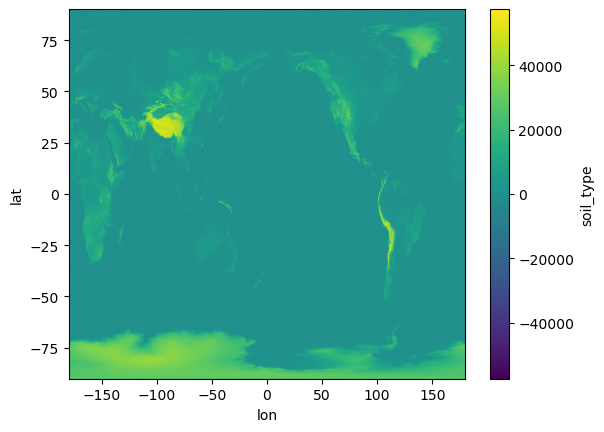

In [6]:
import numpy as np
import xarray as xr
# Load the uploaded file and process it
file_path = 'constant_masks/topography.npy'

# Load the data
soil_type = np.load(file_path)

# Convert to DataArray
soil_da = xr.DataArray(
    soil_type,
    dims=["lat", "lon"],
    coords={
        "lat": np.linspace(90, -90, soil_type.shape[0]),
        "lon": np.linspace(-180, 180, soil_type.shape[1]),
    },
    name="soil_type"
)

# Plot the data
soil_da.plot(cmap="viridis")



# 结果评估

In [16]:
upper_mean.unsqueeze(0).unsqueeze(2).shape

torch.Size([1, 7, 1, 5, 721, 1440])

In [30]:
output_surface.shape

torch.Size([1, 17, 1, 721, 1440])

In [22]:
target_surface.shape

torch.Size([1, 7, 17, 5, 721, 1440])

In [5]:


model_path = '/home/CanglongPhysics/checkpoints_v3/model_v2.pth'  # 使用最佳模型
print(f"Loading model from {model_path}...")
model = CanglongV2()
# model = CanglongV3(
#     surface_mean=surface_mean,
#     surface_std=surface_std,
#     upper_mean=upper_mean,
#     upper_std=upper_std
# )
state_dict = torch.load(model_path, map_location=device)
model.load_state_dict(state_dict)
print("Complete model loaded successfully")


model.to(device)
model.eval()

total_precip_climatology = (surface_mean[LSRR_IDX] + surface_mean[CRR_IDX]).to(device)
metric_records = []
surface_mean, upper_mean, surface_std, upper_std = surface_mean.cuda(), upper_mean.cuda(), surface_std.cuda(), upper_std.cuda()
with torch.no_grad():
    for batch in test_loader:
        input_surface, input_upper_air, target_surface, _, sample_indices = batch
        sample_indices = sample_indices.tolist()

        input_surface, input_upper_air, target_surface = input_surface.to(device), input_upper_air.to(device), target_surface.to(device)
        input_surface = ((input_surface - surface_mean.unsqueeze(0).unsqueeze(2)) / surface_std.unsqueeze(0).unsqueeze(2))
        input_upper_air = ((input_upper_air - upper_mean.unsqueeze(0).unsqueeze(3)) / upper_std.unsqueeze(0).unsqueeze(3))

#        target_surface = ((target_surface - surface_mean.unsqueeze(0).unsqueeze(2)) / surface_mean.unsqueeze(0).unsqueeze(2))

        output_surface, _ = model(input_surface, input_upper_air)

        output_surface = output_surface * surface_std.unsqueeze(0).unsqueeze(2) + surface_mean.unsqueeze(0).unsqueeze(2)
        

        pred_total_precip = output_surface[:, LSRR_IDX, 0, :, :] + output_surface[:, CRR_IDX, 0, :, :]
        true_total_precip = target_surface[:, LSRR_IDX, 0, :, :] + target_surface[:, CRR_IDX, 0, :, :]

        pcc_batch = compute_pcc(pred_total_precip, true_total_precip)
        acc_batch = compute_acc(pred_total_precip, true_total_precip, total_precip_climatology)
        rmse_batch = compute_rmse(pred_total_precip, true_total_precip)

        for b_idx, sample_id in enumerate(sample_indices):
            sample_pcc = float(pcc_batch[b_idx].detach().cpu())
            sample_acc = float(acc_batch[b_idx].detach().cpu())
            sample_rmse = float(rmse_batch[b_idx].detach().cpu())
            metric_records.append({
                'sample_index': sample_id,
                'pcc': sample_pcc,
                'acc': sample_acc,
                'rmse': sample_rmse
            })
            print(
                f"Test sample {sample_id:02d} -> PCC: {sample_pcc:.6f}, "
                f"ACC: {sample_acc:.6f}, RMSE: {sample_rmse:.6f}"
            )
        


if not metric_records:
    print("No samples available in the test set for evaluation.")
else:
    metric_records.sort(key=lambda item: item['sample_index'])
    avg_pcc = float(np.mean([m['pcc'] for m in metric_records]))
    avg_acc = float(np.mean([m['acc'] for m in metric_records]))
    avg_rmse = float(np.mean([m['rmse'] for m in metric_records]))
    combined_score = 0.5 * (avg_pcc + avg_acc)

    print("\nTest set summary (precipitation):")
    print(f"Average PCC:  {avg_pcc:.6f}")
    print(f"Average ACC:  {avg_acc:.6f}")
    print(f"Average RMSE: {avg_rmse:.6f}")
    print(f"Combined score (mean PCC/ACC): {combined_score:.6f}")

Loading model from /home/CanglongPhysics/checkpoints_v3/model_v2.pth...
Complete model loaded successfully


/tmp/ipykernel_17286/3310994168.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=device)


Test sample 40 -> PCC: 0.287351, ACC: 0.284945, RMSE: 0.000045
Test sample 41 -> PCC: 0.279829, ACC: 0.278133, RMSE: 0.000045
Test sample 42 -> PCC: 0.349491, ACC: 0.348687, RMSE: 0.000047
Test sample 43 -> PCC: 0.291509, ACC: 0.290144, RMSE: 0.000049
Test sample 44 -> PCC: 0.261442, ACC: 0.261774, RMSE: 0.000046
Test sample 45 -> PCC: 0.329170, ACC: 0.325032, RMSE: 0.000044
Test sample 46 -> PCC: 0.306911, ACC: 0.306498, RMSE: 0.000049
Test sample 47 -> PCC: 0.318067, ACC: 0.315497, RMSE: 0.000050
Test sample 48 -> PCC: 0.311375, ACC: 0.308930, RMSE: 0.000048
Test sample 49 -> PCC: 0.307521, ACC: 0.302929, RMSE: 0.000046

Test set summary (precipitation):
Average PCC:  0.304267
Average ACC:  0.302257
Average RMSE: 0.000047
Combined score (mean PCC/ACC): 0.303262


In [29]:
rain.shape

torch.Size([721, 1440])

In [32]:
surface = target_surface * surface_std.unsqueeze(0).unsqueeze(2) + surface_mean.unsqueeze(0).unsqueeze(2) 
rain = surface[0, 0, 0, :, :] + surface[0, 1, 0, :, :]

In [26]:
surface.shape

torch.Size([1, 17, 17, 721, 1440])

/home/CanglongPhysics/utils/plot.py:116: FutureWarning: `ax1` has been deprecated in favor of `ax`
  cbar = mpu.colorbar(**colorbar_opt)


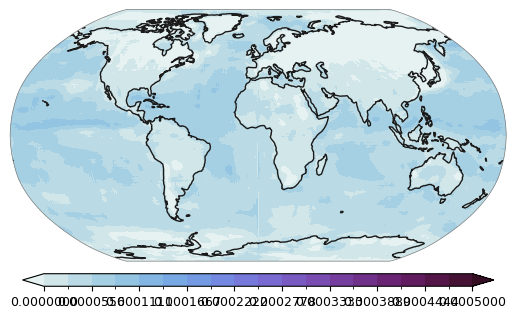

In [5]:
from utils import plot
import xarray as xr
import cmaps
lat = np.linspace(90, -90, 721)
lon = np.linspace(0, 359.75, 1440)
dataarray = xr.DataArray(
    pred_total_precip.cpu().numpy()[0],
    coords=[("lat", lat), ("lon", lon)],
    name="sst"
)
fig = plt.figure()
proj = ccrs.Robinson() #ccrs.Robinson()ccrs.Mollweide()Mollweide()
ax = fig.add_subplot(111, projection=proj)
levels = np.linspace(0, 0.0005, num=19)
plot.one_map_flat(dataarray, ax, levels=levels, cmap=cmaps.cmocean_dense, mask_ocean=False, add_coastlines=True, add_land=False, plotfunc="pcolormesh", colorbar=True)


In [19]:
true_total_precip.cpu().numpy()[0]

array([[2.335199e-05, 2.335199e-05, 2.335199e-05, ..., 2.335199e-05,
        2.335199e-05, 2.335199e-05],
       [2.335199e-05, 2.335199e-05, 2.335199e-05, ..., 2.335199e-05,
        2.335199e-05, 2.335199e-05],
       [2.335199e-05, 2.335199e-05, 2.335199e-05, ..., 2.335199e-05,
        2.335199e-05, 2.335199e-05],
       ...,
       [2.335199e-05, 2.335199e-05, 2.335199e-05, ..., 2.335199e-05,
        2.335199e-05, 2.335199e-05],
       [2.335199e-05, 2.335199e-05, 2.335199e-05, ..., 2.335199e-05,
        2.335199e-05, 2.335199e-05],
       [2.335199e-05, 2.335199e-05, 2.335199e-05, ..., 2.335199e-05,
        2.335199e-05, 2.335199e-05]], dtype=float32)

/home/CanglongPhysics/utils/plot.py:116: FutureWarning: `ax1` has been deprecated in favor of `ax`
  cbar = mpu.colorbar(**colorbar_opt)


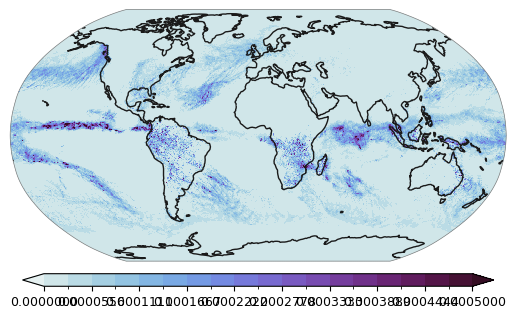

In [6]:
from utils import plot
import xarray as xr
lat = np.linspace(90, -90, 721)
lon = np.linspace(0, 359.75, 1440)
dataarray = xr.DataArray(
    true_total_precip.cpu().numpy()[0],
    coords=[("lat", lat), ("lon", lon)],
    name="sst"
)
fig = plt.figure()
proj = ccrs.Robinson() #ccrs.Robinson()ccrs.Mollweide()Mollweide()
ax = fig.add_subplot(111, projection=proj)
levels = np.linspace(0, 0.0005, num=19)
plot.one_map_flat(dataarray, ax, levels=levels, cmap=cmaps.cmocean_dense, mask_ocean=False, add_coastlines=True, add_land=False, plotfunc="pcolormesh", colorbar=True)


In [1]:
import h5py as h5
print("Loading data...")
h5_file = h5.File('/gz-data/ERA5_2023_weekly.h5', 'r')
input_surface = h5_file['surface'][:]  # (52, 17, 721, 1440)
input_upper_air = h5_file['upper_air'][:]  # (52, 7, 5, 721, 1440)
h5_file.close()


Loading data...


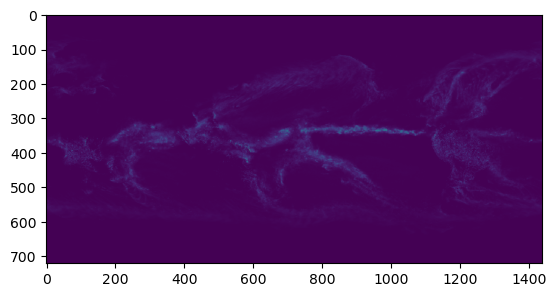

In [5]:
rain = input_surface[50, 0, :, :] + input_surface[50, 1, :, :]
import matplotlib.pyplot as plt
plt.imshow(rain)

## new infer

In [5]:
import torch
import sys
from canglong import CanglongV2_5

In [6]:
from torch.utils.data import Dataset, DataLoader
import h5py as h5
import numpy as np
sys.path.append('code_v2')
from convert_dict_to_pytorch_arrays import load_normalization_arrays

def denormalize_surface(tensor, surface_mean, surface_std):
    """Convert normalized surface data back to physical units."""
    return tensor * surface_std + surface_mean


def denormalize_upper(tensor, upper_mean, upper_std):
    """Convert normalized upper-air data back to physical units."""
    return tensor * upper_std + upper_mean


class WeatherDataset(Dataset):
    def __init__(self, surface_data, upper_air_data, start_idx, end_idx):
        """
        初始化气象数据集 - 按时间序列顺序划分
        
        参数:
            surface_data: 表面数据，形状为 [time, 17, 721, 1440]
            upper_air_data: 高空数据，形状为 [time, 7, 5, 721, 1440]
            start_idx: 开始索引
            end_idx: 结束索引
        """
        self.surface_data = surface_data
        self.upper_air_data = upper_air_data
        self.length = end_idx - start_idx - 2  # 减2确保有足够的目标数据
        self.start_idx = start_idx
        
        print(f"Dataset from index {start_idx} to {end_idx}, sample count: {self.length}")
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        actual_idx = self.start_idx + idx
        
        # 提取输入数据 (t和t+1时刻)
        input_surface = self.surface_data[actual_idx:actual_idx+2]  # [2, 17, 721, 1440]
        # 添加batch维度并调整为 [17, 2, 721, 1440]
        input_surface = np.transpose(input_surface, (1, 0, 2, 3))  # [17, 2, 721, 1440]
        
        # 提取高空数据 (t和t+1时刻)
        input_upper_air = self.upper_air_data[actual_idx:actual_idx+2]  # [2, 7, 5, 721, 1440]
        # 调整为 [7, 5, 2, 721, 1440]
        input_upper_air = np.transpose(input_upper_air, (1, 2, 0, 3, 4))  # [7, 5, 2, 721, 1440]
        
        # 提取目标数据 (t+2时刻)
        target_surface = self.surface_data[actual_idx+2:actual_idx+3]  # [1, 17, 721, 1440]
        # 调整为 [17, 1, 721, 1440]
        target_surface = np.transpose(target_surface, (1, 0, 2, 3))  # [17, 1, 721, 1440]
        
        target_upper_air = self.upper_air_data[actual_idx+2:actual_idx+3]  # [1, 7, 5, 721, 1440]
        # 调整为 [7, 5, 1, 721, 1440]
        target_upper_air = np.transpose(target_upper_air, (1, 2, 0, 3, 4))  # [7, 5, 1, 721, 1440]
        
        return input_surface, input_upper_air, target_surface, target_upper_air, actual_idx

# 设置随机种子
torch.manual_seed(42)
np.random.seed(42)

# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# 加载数据
print("Loading data...")
input_surface, input_upper_air = h5.File('/gz-data/ERA5_2023_weekly_new.h5')['surface'], h5.File('/gz-data/ERA5_2023_weekly_new.h5')['upper_air']
print(f"Surface data shape: {input_surface.shape}") #(52, 26, 721, 1440)
print(f"Upper air data shape: {input_upper_air.shape}") #(52, 10, 5, 721, 1440)


# 加载标准化参数
print("Loading normalization parameters...")
from convert_dict_to_pytorch_arrays_v2 import load_normalization_arrays
# 调用函数获取四个数组
json = '/home/CanglongPhysics/code_v2/ERA5_1940_2023_mean_std_v2.json'
surface_mean_np, surface_std_np, upper_mean_np, upper_std_np = load_normalization_arrays(json)

surface_mean = torch.from_numpy(surface_mean_np).to(device=device, dtype=torch.float32)
surface_std = torch.from_numpy(surface_std_np).to(device=device, dtype=torch.float32)
upper_mean = torch.from_numpy(upper_mean_np).to(device=device, dtype=torch.float32)
upper_std = torch.from_numpy(upper_std_np).to(device=device, dtype=torch.float32)

print(f"Surface mean shape: {surface_mean.shape}")
print(f"Surface std shape: {surface_std.shape}")
print(f"Upper mean shape: {upper_mean.shape}")
print(f"Upper std shape: {upper_std.shape}")

# 计算数据集划分点 - 按照6:2:2的时间序列划分
total_samples = 52
train_end = 30
valid_end = 40

test_dataset = WeatherDataset(input_surface, input_upper_air, start_idx=valid_end, end_idx=total_samples)
batch_size = 1  # 小batch size便于调试
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=16)
print(f"Created data loaders with batch size {batch_size}")

# Variable ordering shared across the project. Keep in sync with CLAUDE.md.
SURFACE_VARS = ['avg_tnswrf', 'avg_tnlwrf', 'tciw', 'tcc', 'lsrr',
    'crr', 'blh', 'u10', 'v10', 'd2m', 
    't2m', 'avg_iews', 'avg_inss', 'slhf', 'sshf',
    'avg_snswrf', 'avg_snlwrf', 'ssr', 'str', 'sp', 
    'msl', 'siconc', 'sst', 'ro', 'stl', 'swvl']
    
UPPER_VARS = ['o3', 'z', 't', 'u', 'v', 'w', 'q', 'cc', 'ciwc', 'clwc']
PRESSURE_LEVELS = [200, 300, 500, 700, 850]

SURFACE_VAR_TO_IDX = {name: idx for idx, name in enumerate(SURFACE_VARS)}
LSRR_IDX = SURFACE_VAR_TO_IDX['lsrr']
CRR_IDX = SURFACE_VAR_TO_IDX['crr']
AVG_TNLWRF_IDX = SURFACE_VAR_TO_IDX['avg_tnlwrf']
T2M_IDX = SURFACE_VAR_TO_IDX['t2m']
D2M_IDX = SURFACE_VAR_TO_IDX['d2m']
U_VAR_IDX = UPPER_VARS.index('u')
PRESSURE_LEVEL_TO_IDX = {level: idx for idx, level in enumerate(PRESSURE_LEVELS)}

def compute_pcc(pred, target):
    """Compute Pearson correlation coefficient for each sample in the batch."""
    pred_flat = pred.reshape(pred.shape[0], -1)
    target_flat = target.reshape(target.shape[0], -1)
    pred_anom = pred_flat - pred_flat.mean(dim=1, keepdim=True)
    target_anom = target_flat - target_flat.mean(dim=1, keepdim=True)
    numerator = (pred_anom * target_anom).sum(dim=1)
    denominator = torch.sqrt((pred_anom.pow(2).sum(dim=1)) * (target_anom.pow(2).sum(dim=1)))
    denominator = torch.clamp(denominator, min=1e-12)
    return numerator / denominator


def compute_acc(pred, target, climatology):
    """Compute anomaly correlation coefficient for each sample in the batch."""
    pred_flat = pred.reshape(pred.shape[0], -1)
    target_flat = target.reshape(target.shape[0], -1)
    clim_flat = climatology.reshape(1, -1).to(pred_flat.device)
    pred_anom = pred_flat - clim_flat
    target_anom = target_flat - clim_flat
    numerator = (pred_anom * target_anom).sum(dim=1)
    denominator = torch.sqrt((pred_anom.pow(2).sum(dim=1)) * (target_anom.pow(2).sum(dim=1)))
    denominator = torch.clamp(denominator, min=1e-12)
    return numerator / denominator


def compute_rmse(pred, target):
    """Compute RMSE for each sample in the batch."""
    diff = pred - target
    mse = diff.pow(2).reshape(diff.shape[0], -1).mean(dim=1)
    return torch.sqrt(mse)

Using device: cuda
Loading data...
Surface data shape: (52, 26, 721, 1440)
Upper air data shape: (52, 10, 5, 721, 1440)
Loading normalization parameters...
Surface mean shape: torch.Size([1, 26, 1, 721, 1440])
Surface std shape: torch.Size([1, 26, 1, 721, 1440])
Upper mean shape: torch.Size([1, 10, 5, 1, 721, 1440])
Upper std shape: torch.Size([1, 10, 5, 1, 721, 1440])
Dataset from index 40 to 52, sample count: 10
Created data loaders with batch size 1


In [7]:
model_path = '/home/CanglongPhysics/checkpoints_v3_5/model_v3_5_epoch25.pth'   # 使用最佳模型model_v1'/gz-data/model_v1_epoch50.pth' 
print(f"Loading model from {model_path}...")
model = CanglongV2_5()
#model = Canglong()
state_dict = torch.load(model_path, map_location=device)
model.load_state_dict(state_dict, strict=False)
print("Complete model loaded successfully")


model.to(device)
model.eval()

surface_mean_2d = surface_mean[0, :, 0, :, :]
total_precip_climatology = surface_mean_2d[LSRR_IDX] + surface_mean_2d[CRR_IDX]
metric_records = []
with torch.no_grad():
    for batch in test_loader:
        input_surface, input_upper_air, target_surface, target_upper_air, sample_indices = batch
        sample_indices = sample_indices.tolist()

        input_surface = input_surface.float().to(device)
        input_upper_air = input_upper_air.float().to(device)
        target_surface = target_surface.float().to(device)
        target_upper_air = target_upper_air.float().to(device)
        input_surface = (input_surface - surface_mean) / surface_std
        input_upper_air = (input_upper_air - upper_mean) / upper_std

        output_surface, output_upper_air = model(input_surface, input_upper_air)

        # Preserve normalized tensors for RMSE in standardized space
        output_surface_norm = output_surface
        output_upper_air_norm = output_upper_air
        target_surface_norm = (target_surface - surface_mean) / surface_std
        target_upper_air_norm = (target_upper_air - upper_mean) / upper_std

        # Convert back to physical units for correlation-based diagnostics
        output_surface_phys = denormalize_surface(output_surface_norm, surface_mean, surface_std)
        output_upper_air_phys = denormalize_upper(output_upper_air_norm, upper_mean, upper_std)

        pred_total_precip_phys = output_surface_phys[:, LSRR_IDX, 0, :, :] + output_surface_phys[:, CRR_IDX, 0, :, :]
        true_total_precip_phys = target_surface[:, LSRR_IDX, 0, :, :] + target_surface[:, CRR_IDX, 0, :, :]
        pred_total_precip_norm = output_surface_norm[:, LSRR_IDX, 0, :, :] + output_surface_norm[:, CRR_IDX, 0, :, :]
        true_total_precip_norm = target_surface_norm[:, LSRR_IDX, 0, :, :] + target_surface_norm[:, CRR_IDX, 0, :, :]

        pcc_batch = compute_pcc(pred_total_precip_phys, true_total_precip_phys)
        acc_batch = compute_acc(pred_total_precip_phys, true_total_precip_phys, total_precip_climatology)
        rmse_batch = compute_rmse(pred_total_precip_norm, true_total_precip_norm)

        avg_tnlwrf_pred_phys = output_surface_phys[:, AVG_TNLWRF_IDX, 0, :, :]
        avg_tnlwrf_true_phys = target_surface[:, AVG_TNLWRF_IDX, 0, :, :]
        avg_tnlwrf_pcc_batch = compute_pcc(avg_tnlwrf_pred_phys, avg_tnlwrf_true_phys)
        avg_tnlwrf_rmse_batch = compute_rmse(
            output_surface_norm[:, AVG_TNLWRF_IDX, 0, :, :],
            target_surface_norm[:, AVG_TNLWRF_IDX, 0, :, :]
        )

        t2m_pred_phys = output_surface_phys[:, T2M_IDX, 0, :, :]
        t2m_true_phys = target_surface[:, T2M_IDX, 0, :, :]
        t2m_pcc_batch = compute_pcc(t2m_pred_phys, t2m_true_phys)
        t2m_rmse_batch = compute_rmse(
            output_surface_norm[:, T2M_IDX, 0, :, :],
            target_surface_norm[:, T2M_IDX, 0, :, :]
        )

        d2m_pred_phys = output_surface_phys[:, D2M_IDX, 0, :, :]
        d2m_true_phys = target_surface[:, D2M_IDX, 0, :, :]
        d2m_pcc_batch = compute_pcc(d2m_pred_phys, d2m_true_phys)
        d2m_rmse_batch = compute_rmse(
            output_surface_norm[:, D2M_IDX, 0, :, :],
            target_surface_norm[:, D2M_IDX, 0, :, :]
        )

        u200_level_idx = PRESSURE_LEVEL_TO_IDX[200]
        u850_level_idx = PRESSURE_LEVEL_TO_IDX[850]
        u200_pred_phys = output_upper_air_phys[:, U_VAR_IDX, u200_level_idx, 0, :, :]
        u200_true_phys = target_upper_air[:, U_VAR_IDX, u200_level_idx, 0, :, :]
        u200_pcc_batch = compute_pcc(u200_pred_phys, u200_true_phys)
        u200_rmse_batch = compute_rmse(
            output_upper_air_norm[:, U_VAR_IDX, u200_level_idx, 0, :, :],
            target_upper_air_norm[:, U_VAR_IDX, u200_level_idx, 0, :, :]
        )

        u850_pred_phys = output_upper_air_phys[:, U_VAR_IDX, u850_level_idx, 0, :, :]
        u850_true_phys = target_upper_air[:, U_VAR_IDX, u850_level_idx, 0, :, :]
        u850_pcc_batch = compute_pcc(u850_pred_phys, u850_true_phys)
        u850_rmse_batch = compute_rmse(
            output_upper_air_norm[:, U_VAR_IDX, u850_level_idx, 0, :, :],
            target_upper_air_norm[:, U_VAR_IDX, u850_level_idx, 0, :, :]
        )

        surface_rmse_batch = compute_rmse(output_surface_norm, target_surface_norm)
        upper_air_rmse_batch = compute_rmse(output_upper_air_norm, target_upper_air_norm)

        for b_idx, sample_id in enumerate(sample_indices):
            sample_pcc = float(pcc_batch[b_idx].detach().cpu())
            sample_acc = float(acc_batch[b_idx].detach().cpu())
            sample_rmse = float(rmse_batch[b_idx].detach().cpu())
            sample_avg_tnlwrf_pcc = float(avg_tnlwrf_pcc_batch[b_idx].detach().cpu())
            sample_avg_tnlwrf_rmse = float(avg_tnlwrf_rmse_batch[b_idx].detach().cpu())
            sample_t2m_pcc = float(t2m_pcc_batch[b_idx].detach().cpu())
            sample_t2m_rmse = float(t2m_rmse_batch[b_idx].detach().cpu())
            sample_d2m_pcc = float(d2m_pcc_batch[b_idx].detach().cpu())
            sample_d2m_rmse = float(d2m_rmse_batch[b_idx].detach().cpu())
            sample_u200_pcc = float(u200_pcc_batch[b_idx].detach().cpu())
            sample_u200_rmse = float(u200_rmse_batch[b_idx].detach().cpu())
            sample_u850_pcc = float(u850_pcc_batch[b_idx].detach().cpu())
            sample_u850_rmse = float(u850_rmse_batch[b_idx].detach().cpu())
            sample_surface_rmse = float(surface_rmse_batch[b_idx].detach().cpu())
            sample_upper_air_rmse = float(upper_air_rmse_batch[b_idx].detach().cpu())
            metric_records.append({
                'sample_index': sample_id,
                'pcc': sample_pcc,
                'acc': sample_acc,
                'rmse': sample_rmse,
                'avg_tnlwrf_pcc': sample_avg_tnlwrf_pcc,
                'avg_tnlwrf_rmse': sample_avg_tnlwrf_rmse,
                't2m_pcc': sample_t2m_pcc,
                't2m_rmse': sample_t2m_rmse,
                'd2m_pcc': sample_d2m_pcc,
                'd2m_rmse': sample_d2m_rmse,
                'u200_pcc': sample_u200_pcc,
                'u200_rmse': sample_u200_rmse,
                'u850_pcc': sample_u850_pcc,
                'u850_rmse': sample_u850_rmse,
                'surface_rmse': sample_surface_rmse,
                'upper_air_rmse': sample_upper_air_rmse
            })
            print(
                f"Test sample {sample_id:02d} -> PCC: {sample_pcc:.6f}, "
                f"ACC: {sample_acc:.6f}, RMSE(norm.): {sample_rmse:.6f}"
            )
            print(
                " " * 22 +
                f"avg_tnlwrf PCC: {sample_avg_tnlwrf_pcc:.6f}, RMSE(norm.): {sample_avg_tnlwrf_rmse:.6f} | "
                f"t2m PCC: {sample_t2m_pcc:.6f}, RMSE(norm.): {sample_t2m_rmse:.6f} | "
                f"d2m PCC: {sample_d2m_pcc:.6f}, RMSE(norm.): {sample_d2m_rmse:.6f} | "
                f"u200 PCC: {sample_u200_pcc:.6f}, RMSE(norm.): {sample_u200_rmse:.6f} | "
                f"u850 PCC: {sample_u850_pcc:.6f}, RMSE(norm.): {sample_u850_rmse:.6f} | "
                f"surface RMSE(norm.): {sample_surface_rmse:.6f} | upper-air RMSE(norm.): {sample_upper_air_rmse:.6f}"
            )
        


if not metric_records:
    print("No samples available in the test set for evaluation.")
else:
    metric_records.sort(key=lambda item: item['sample_index'])
    avg_pcc = float(np.mean([m['pcc'] for m in metric_records]))
    avg_acc = float(np.mean([m['acc'] for m in metric_records]))
    avg_rmse = float(np.mean([m['rmse'] for m in metric_records]))
    avg_avg_tnlwrf_pcc = float(np.mean([m['avg_tnlwrf_pcc'] for m in metric_records]))
    avg_avg_tnlwrf_rmse = float(np.mean([m['avg_tnlwrf_rmse'] for m in metric_records]))
    avg_t2m_pcc = float(np.mean([m['t2m_pcc'] for m in metric_records]))
    avg_t2m_rmse = float(np.mean([m['t2m_rmse'] for m in metric_records]))
    avg_d2m_pcc = float(np.mean([m['d2m_pcc'] for m in metric_records]))
    avg_d2m_rmse = float(np.mean([m['d2m_rmse'] for m in metric_records]))
    avg_u200_pcc = float(np.mean([m['u200_pcc'] for m in metric_records]))
    avg_u200_rmse = float(np.mean([m['u200_rmse'] for m in metric_records]))
    avg_u850_pcc = float(np.mean([m['u850_pcc'] for m in metric_records]))
    avg_u850_rmse = float(np.mean([m['u850_rmse'] for m in metric_records]))
    avg_surface_rmse = float(np.mean([m['surface_rmse'] for m in metric_records]))
    avg_upper_air_rmse = float(np.mean([m['upper_air_rmse'] for m in metric_records]))
    combined_score = 0.5 * (avg_pcc + avg_acc)

    grouped_avg_pcc = float(np.mean([
        avg_pcc,
        avg_t2m_pcc,
        avg_d2m_pcc,
        avg_u200_pcc,
        avg_u850_pcc
    ]))
    grouped_avg_rmse = float(np.mean([
        avg_rmse,
        avg_t2m_rmse,
        avg_d2m_rmse,
        avg_u200_rmse,
        avg_u850_rmse
    ]))

    print("\nTest set summary (precipitation & key variables):")
    print(f"Average precip PCC:  {avg_pcc:.6f}")
    print(f"Average precip ACC:  {avg_acc:.6f}")
    print(f"Average precip RMSE (norm.): {avg_rmse:.6f}")
    print(f"Combined score (mean PCC/ACC): {combined_score:.6f}")
    print(f"Average avg_tnlwrf PCC: {avg_avg_tnlwrf_pcc:.6f}, RMSE(norm.): {avg_avg_tnlwrf_rmse:.6f}")
    print(f"Average t2m PCC:       {avg_t2m_pcc:.6f}, RMSE(norm.): {avg_t2m_rmse:.6f}")
    print(f"Average d2m PCC:       {avg_d2m_pcc:.6f}, RMSE(norm.): {avg_d2m_rmse:.6f}")
    print(f"Average u200 PCC:      {avg_u200_pcc:.6f}, RMSE(norm.): {avg_u200_rmse:.6f}")
    print(f"Average u850 PCC:      {avg_u850_pcc:.6f}, RMSE(norm.): {avg_u850_rmse:.6f}")
    print(f"Average grouped PCC (precip/t2m/d2m/u200/u850): {grouped_avg_pcc:.6f}")
    print(f"Average grouped RMSE(norm.) (precip/t2m/d2m/u200/u850): {grouped_avg_rmse:.6f}")
    print(f"Average surface RMSE(norm.):  {avg_surface_rmse:.6f}")
    print(f"Average upper-air RMSE(norm.):{avg_upper_air_rmse:.6f}")


Loading model from /home/CanglongPhysics/checkpoints_v3_5/model_v3_5_epoch25.pth...


/tmp/ipykernel_90270/1455125904.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=device)


Complete model loaded successfully
Test sample 40 -> PCC: 0.591177, ACC: 0.590405, RMSE(norm.): 1.445089
                      avg_tnlwrf PCC: 0.935142, RMSE(norm.): 0.348988 | t2m PCC: 0.982193, RMSE(norm.): 0.190931 | d2m PCC: 0.974310, RMSE(norm.): 0.225038 | u200 PCC: 0.789316, RMSE(norm.): 0.581280 | u850 PCC: 0.800498, RMSE(norm.): 0.578619 | surface RMSE(norm.): 0.828694 | upper-air RMSE(norm.): 0.666926
Test sample 41 -> PCC: 0.630662, ACC: 0.630390, RMSE(norm.): 1.399944
                      avg_tnlwrf PCC: 0.937640, RMSE(norm.): 0.338714 | t2m PCC: 0.984181, RMSE(norm.): 0.190320 | d2m PCC: 0.975227, RMSE(norm.): 0.228627 | u200 PCC: 0.812254, RMSE(norm.): 0.558441 | u850 PCC: 0.808308, RMSE(norm.): 0.637636 | surface RMSE(norm.): 0.778422 | upper-air RMSE(norm.): 0.675460
Test sample 42 -> PCC: 0.647616, ACC: 0.645179, RMSE(norm.): 1.492847
                      avg_tnlwrf PCC: 0.933352, RMSE(norm.): 0.350815 | t2m PCC: 0.981756, RMSE(norm.): 0.200124 | d2m PCC: 0.974104, R

ERROR 1: PROJ: proj_create_from_database: Open of /usr/local/miniconda3/envs/torch/share/proj failed
/home/CanglongPhysics/utils/plot.py:116: FutureWarning: `ax1` has been deprecated in favor of `ax`
  cbar = mpu.colorbar(**colorbar_opt)
/home/CanglongPhysics/utils/plot.py:116: FutureWarning: `ax1` has been deprecated in favor of `ax`
  cbar = mpu.colorbar(**colorbar_opt)
/home/CanglongPhysics/utils/plot.py:116: FutureWarning: `ax1` has been deprecated in favor of `ax`
  cbar = mpu.colorbar(**colorbar_opt)
/home/CanglongPhysics/utils/plot.py:116: FutureWarning: `ax1` has been deprecated in favor of `ax`
  cbar = mpu.colorbar(**colorbar_opt)
/home/CanglongPhysics/utils/plot.py:116: FutureWarning: `ax1` has been deprecated in favor of `ax`
  cbar = mpu.colorbar(**colorbar_opt)
/home/CanglongPhysics/utils/plot.py:116: FutureWarning: `ax1` has been deprecated in favor of `ax`
  cbar = mpu.colorbar(**colorbar_opt)
/tmp/ipykernel_90270/4220735484.py:122: UserWarning: This figure includes Axe

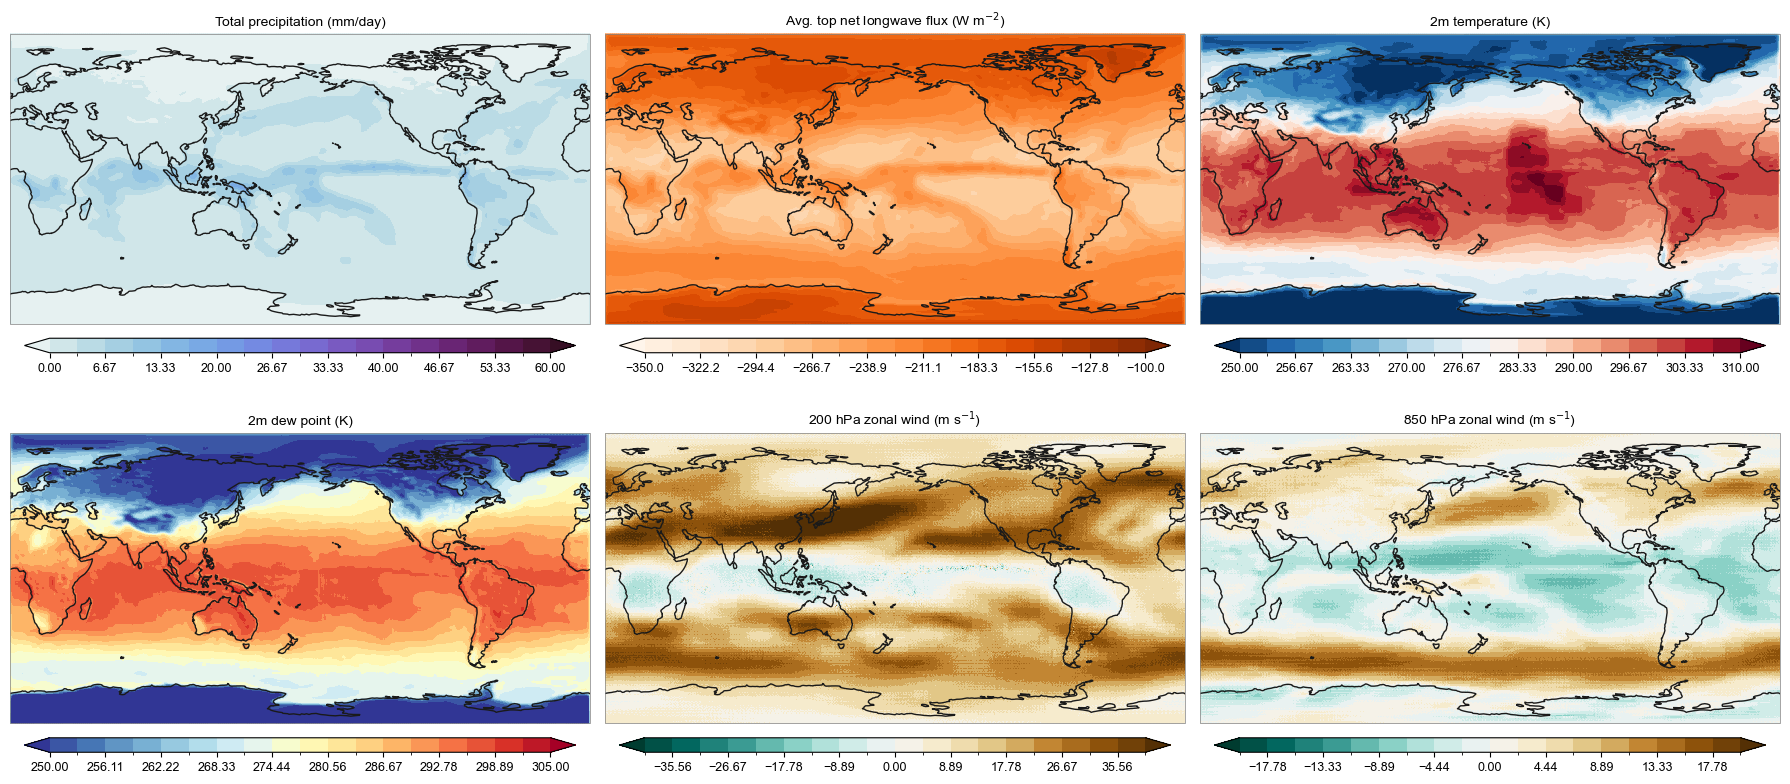

In [8]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmaps
from matplotlib import font_manager
import os

# 在导入cartopy之前设置环境变量
os.environ['PROJ_DATA'] = '/usr/local/miniconda3/envs/torch/share/proj'
from utils import plot

# Configure Arial font as required for all plots
font_path = "/root/ARIAL.TTF"
try:
    font_manager.fontManager.addfont(font_path)
    plt.rcParams["font.family"] = font_manager.FontProperties(fname=font_path).get_name()
except FileNotFoundError:
    plt.rcParams["font.family"] = "Arial"

# Common coordinates
lat = np.linspace(90, -90, 721)
lon = np.linspace(0, 359.75, 1440)

# Helper to move tensor data onto CPU numpy arrays
cpu_numpy = lambda tensor: tensor.detach().cpu().numpy()

# Prepare all fields before plotting

surface_np = cpu_numpy(output_surface_phys)
upper_air_np = cpu_numpy(output_upper_air_phys)

avg_tnlwrf = surface_np[0, AVG_TNLWRF_IDX, 0]
t2m = surface_np[0, T2M_IDX, 0]
d2m = surface_np[0, D2M_IDX, 0]
u200 = upper_air_np[0, U_VAR_IDX, u200_level_idx, 0]
u850 = upper_air_np[0, U_VAR_IDX, u850_level_idx, 0]
precip_mm_day = surface_np[0, LSRR_IDX, 0] * 86400.0 + surface_np[0, CRR_IDX, 0] * 86400.0

plot_configs = [
    {
        "data": xr.DataArray(
            precip_mm_day,
            coords=[("lat", lat), ("lon", lon)],
            name="Total precipitation (mm/day)",
        ),
        "levels": np.linspace(0, 60, num=19),
        "cmap": cmaps.cmocean_dense,
    },
    {
        "data": xr.DataArray(
            avg_tnlwrf,
            coords=[("lat", lat), ("lon", lon)],
            name="Avg. top net longwave flux (W m$^{-2}$)",
        ),
        "levels": np.linspace(-350, -100, num=19),
        "cmap": "Oranges",
    },
    {
        "data": xr.DataArray(
            t2m,
            coords=[("lat", lat), ("lon", lon)],
            name="2m temperature (K)",
        ),
        "levels": np.linspace(250, 310, num=19),
        "cmap": "RdBu_r",
    },
    {
        "data": xr.DataArray(
            d2m,
            coords=[("lat", lat), ("lon", lon)],
            name="2m dew point (K)",
        ),
        "levels": np.linspace(250, 305, num=19),
        "cmap": "RdYlBu_r",
    },
    {
        "data": xr.DataArray(
            u200,
            coords=[("lat", lat), ("lon", lon)],
            name="200 hPa zonal wind (m s$^{-1}$)",
        ),
        "levels": np.linspace(-40, 40, num=19),
        "cmap": "BrBG_r",
    },
    {
        "data": xr.DataArray(
            u850,
            coords=[("lat", lat), ("lon", lon)],
            name="850 hPa zonal wind (m s$^{-1}$)",
        ),
        "levels": np.linspace(-20, 20, num=19),
        "cmap": "BrBG_r",
    },
]

fig, axes = plt.subplots(
    nrows=2,
    ncols=3,
    figsize=(18, 9),
    subplot_kw={"projection": ccrs.PlateCarree(central_longitude=180.0)},
)
axes = axes.flatten()

for ax, cfg in zip(axes, plot_configs):
    plot.one_map_flat(
        cfg["data"],
        ax,
        levels=cfg["levels"],
        cmap=cfg["cmap"],
        mask_ocean=False,
        add_coastlines=True,
        add_land=False,
        plotfunc="pcolormesh",
        colorbar=True,
    )
    ax.set_title(cfg["data"].name, fontsize=10, pad=6)

for ax in axes[len(plot_configs):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()


/home/CanglongPhysics/utils/plot.py:672: FutureWarning: `ax1` has been deprecated in favor of `ax`
  cbar = mpu.colorbar(**colorbar_opt)


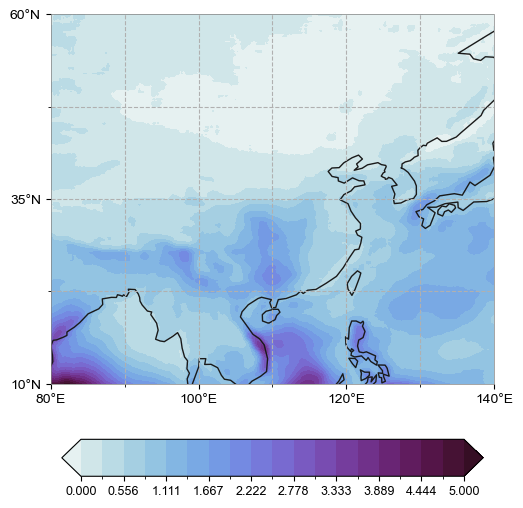

In [22]:
from utils import plot
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

crr = surface_np[0, CRR_IDX, 0] * 86400
crr_da = xr.DataArray(
            crr,
            coords=[("lat", lat), ("lon", lon)],
            name="precipitation (mm/day)",
        )

fig = plt.figure()
proj = ccrs.PlateCarree() #ccrs.Robinson()ccrs.Mollweide()Mollweide()
ax = fig.add_subplot(111, projection=proj)
levels = np.linspace(0, 5, num=19)
plot.one_map_region(crr_da, ax, levels=levels, cmap=cmaps.cmocean_dense, extents=[80, 140, 10, 60], interval=[20, 25], mask_ocean=False, add_coastlines=True, add_land=True, add_gridlines=True, colorbar=True, plotfunc="contourf")

/home/CanglongPhysics/utils/plot.py:672: FutureWarning: `ax1` has been deprecated in favor of `ax`
  cbar = mpu.colorbar(**colorbar_opt)


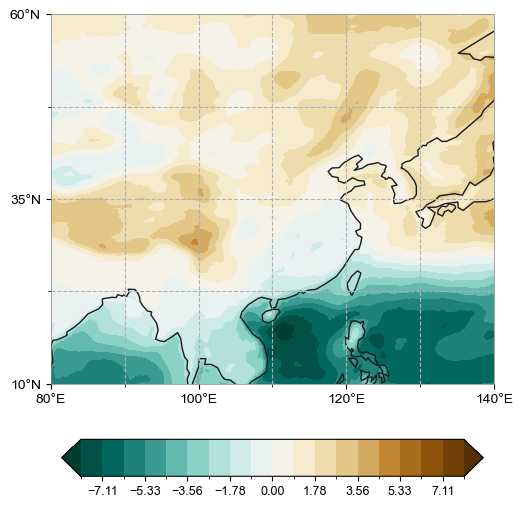

In [21]:
from utils import plot
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

u10 = surface_np[0, 7, 0]
u10_da = xr.DataArray(
            u10,
            coords=[("lat", lat), ("lon", lon)],
            name="u 10 m/s",
        )

fig = plt.figure()
proj = ccrs.PlateCarree() #ccrs.Robinson()ccrs.Mollweide()Mollweide()
ax = fig.add_subplot(111, projection=proj)
levels = np.linspace(-8, 8, num=19)
plot.one_map_region(u10_da, ax, levels=levels, cmap='BrBG_r', extents=[80, 140, 10, 60], interval=[20, 25], mask_ocean=False, add_coastlines=True, add_land=True, add_gridlines=True, colorbar=True, plotfunc="contourf")

/home/CanglongPhysics/utils/plot.py:672: FutureWarning: `ax1` has been deprecated in favor of `ax`
  cbar = mpu.colorbar(**colorbar_opt)


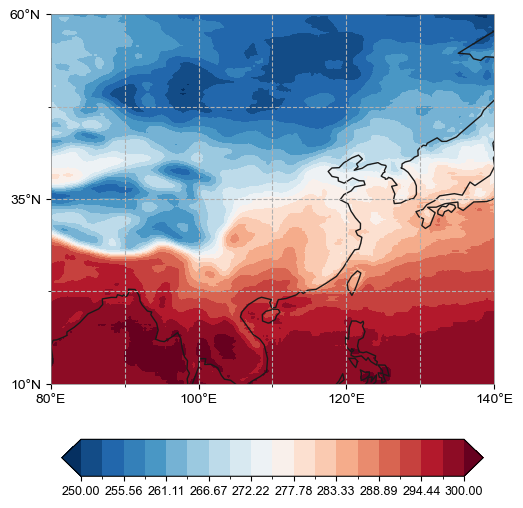

In [20]:
from utils import plot
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

t2m = surface_np[0, 10, 0]
t2m_da = xr.DataArray(
            t2m,
            coords=[("lat", lat), ("lon", lon)],
            name="K",
        )

fig = plt.figure()
proj = ccrs.PlateCarree() #ccrs.Robinson()ccrs.Mollweide()Mollweide()
ax = fig.add_subplot(111, projection=proj)
levels = np.linspace(250, 300, num=19)
plot.one_map_region(t2m_da, ax, levels=levels, cmap='RdBu_r', extents=[80, 140, 10, 60], interval=[20, 25], mask_ocean=False, add_coastlines=True, add_land=True, add_gridlines=True, colorbar=True, plotfunc="contourf")

/home/CanglongPhysics/utils/plot.py:672: FutureWarning: `ax1` has been deprecated in favor of `ax`
  cbar = mpu.colorbar(**colorbar_opt)


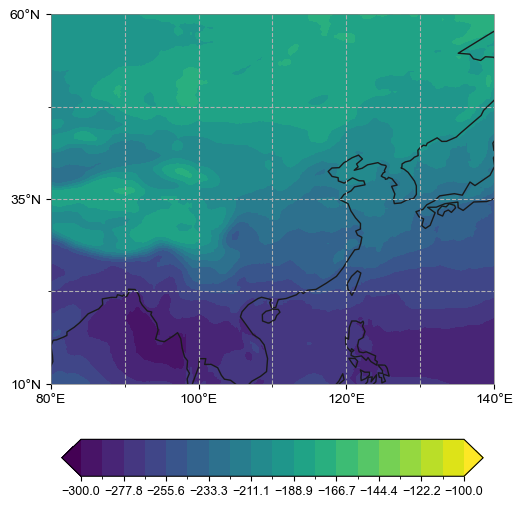

In [24]:
from utils import plot
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

olr = surface_np[0, AVG_TNLWRF_IDX, 0]
olr_da = xr.DataArray(
            olr,
            coords=[("lat", lat), ("lon", lon)],
            name="Avg. top net longwave flux (W m$^{-2}$)",
        )

fig = plt.figure()
proj = ccrs.PlateCarree() #ccrs.Robinson()ccrs.Mollweide()Mollweide()
ax = fig.add_subplot(111, projection=proj)
levels = np.linspace(-300, -100, num=19)
plot.one_map_region(olr_da, ax, levels=levels, extents=[80, 140, 10, 60], interval=[20, 25], mask_ocean=False, add_coastlines=True, add_land=True, add_gridlines=True, colorbar=True, plotfunc="contourf")

/home/CanglongPhysics/utils/plot.py:672: FutureWarning: `ax1` has been deprecated in favor of `ax`
  cbar = mpu.colorbar(**colorbar_opt)


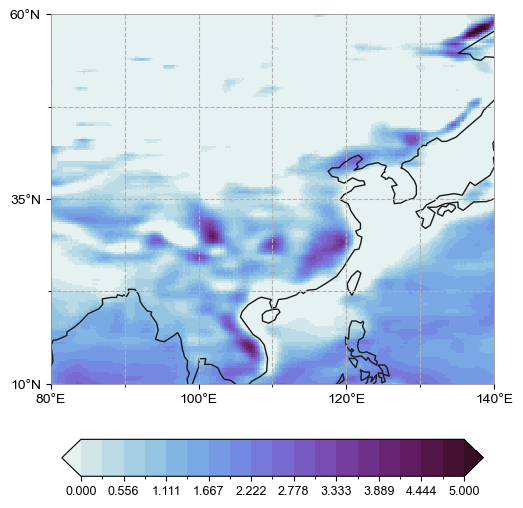

In [6]:
from utils import plot
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

crr = surface_np[0, CRR_IDX, 0] * 86400
crr_da = xr.DataArray(
            crr,
            coords=[("lat", lat), ("lon", lon)],
            name="precipitation (mm/day)",
        )

fig = plt.figure()
proj = ccrs.PlateCarree() #ccrs.Robinson()ccrs.Mollweide()Mollweide()
ax = fig.add_subplot(111, projection=proj)
levels = np.linspace(0, 5, num=19)
plot.one_map_region(crr_da, ax, levels=levels, cmap=cmaps.cmocean_dense, extents=[80, 140, 10, 60], interval=[20, 25], mask_ocean=False, add_coastlines=True, add_land=True, add_gridlines=True, colorbar=True, plotfunc="pcolormesh")

/home/CanglongPhysics/utils/plot.py:672: FutureWarning: `ax1` has been deprecated in favor of `ax`
  cbar = mpu.colorbar(**colorbar_opt)


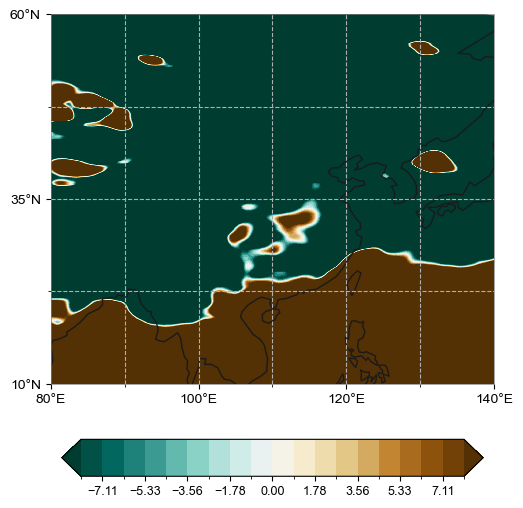

In [6]:
from utils import plot
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

u10 = surface_np[0, 7, 0]
u10_da = xr.DataArray(
            u10,
            coords=[("lat", lat), ("lon", lon)],
            name="u 10 m/s",
        )

fig = plt.figure()
proj = ccrs.PlateCarree() #ccrs.Robinson()ccrs.Mollweide()Mollweide()
ax = fig.add_subplot(111, projection=proj)
levels = np.linspace(-8, 8, num=19)
plot.one_map_region(u10_da, ax, levels=levels, cmap='BrBG_r', extents=[80, 140, 10, 60], interval=[20, 25], mask_ocean=False, add_coastlines=True, add_land=True, add_gridlines=True, colorbar=True, plotfunc="contourf")

/home/CanglongPhysics/utils/plot.py:672: FutureWarning: `ax1` has been deprecated in favor of `ax`
  cbar = mpu.colorbar(**colorbar_opt)


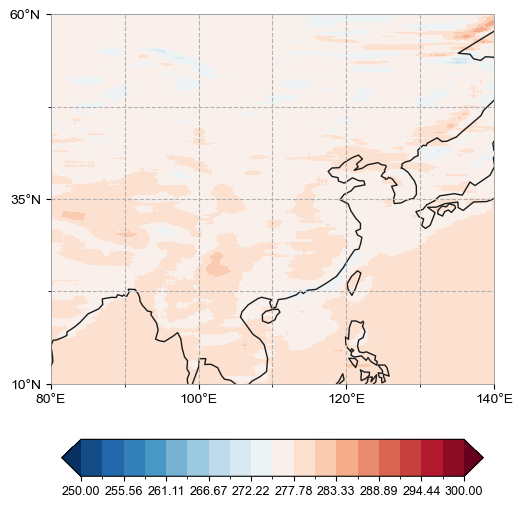

In [7]:
from utils import plot
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

t2m = surface_np[0, 10, 0]
t2m_da = xr.DataArray(
            t2m,
            coords=[("lat", lat), ("lon", lon)],
            name="K",
        )

fig = plt.figure()
proj = ccrs.PlateCarree() #ccrs.Robinson()ccrs.Mollweide()Mollweide()
ax = fig.add_subplot(111, projection=proj)
levels = np.linspace(250, 300, num=19)
plot.one_map_region(t2m_da, ax, levels=levels, cmap='RdBu_r', extents=[80, 140, 10, 60], interval=[20, 25], mask_ocean=False, add_coastlines=True, add_land=True, add_gridlines=True, colorbar=True, plotfunc="contourf")

/home/CanglongPhysics/utils/plot.py:672: FutureWarning: `ax1` has been deprecated in favor of `ax`
  cbar = mpu.colorbar(**colorbar_opt)


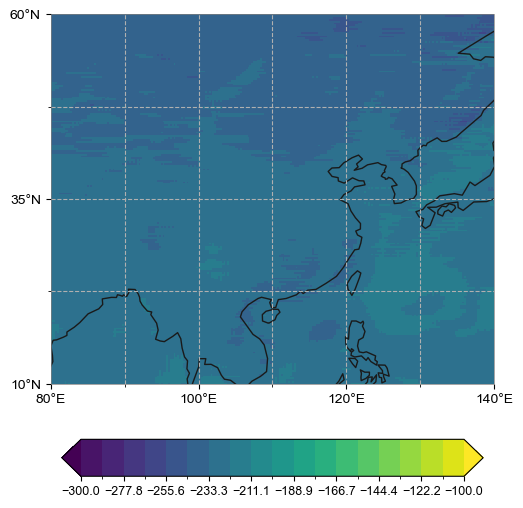

In [8]:
from utils import plot
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

olr = surface_np[0, AVG_TNLWRF_IDX, 0]
olr_da = xr.DataArray(
            olr,
            coords=[("lat", lat), ("lon", lon)],
            name="Avg. top net longwave flux (W m$^{-2}$)",
        )

fig = plt.figure()
proj = ccrs.PlateCarree() #ccrs.Robinson()ccrs.Mollweide()Mollweide()
ax = fig.add_subplot(111, projection=proj)
levels = np.linspace(-300, -100, num=19)
plot.one_map_region(olr_da, ax, levels=levels, extents=[80, 140, 10, 60], interval=[20, 25], mask_ocean=False, add_coastlines=True, add_land=True, add_gridlines=True, colorbar=True, plotfunc="pcolormesh")

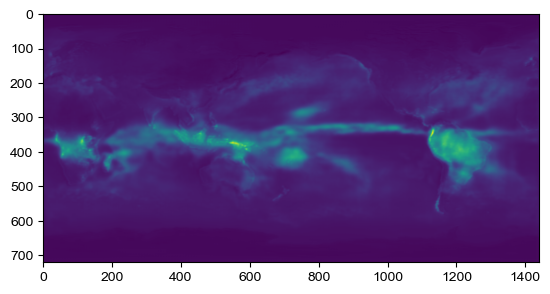

In [9]:
crr = surface_np[0, CRR_IDX, 0] * 86400.0
plt.imshow(crr)

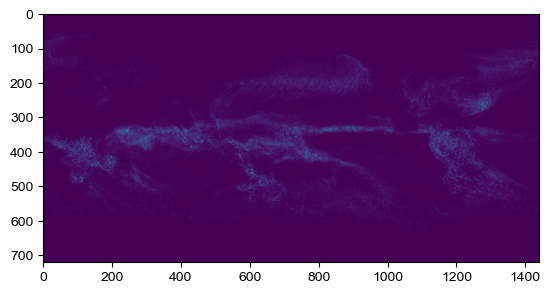

In [15]:
surface_np_obs = cpu_numpy(target_surface)
upper_air_np_obs = cpu_numpy(target_upper_air)
crr_obs = surface_np_obs[0, CRR_IDX, 0] * 86400.0
plt.imshow(crr_obs)

/home/CanglongPhysics/utils/plot.py:672: FutureWarning: `ax1` has been deprecated in favor of `ax`
  cbar = mpu.colorbar(**colorbar_opt)


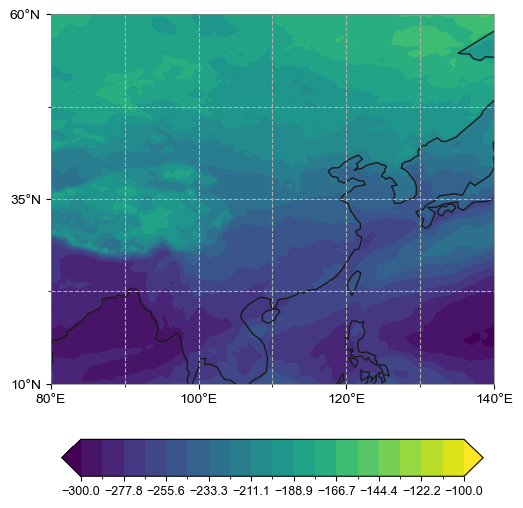

In [27]:
from utils import plot
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
olr_obs = surface_np_obs[0, AVG_TNLWRF_IDX, 0]

olr_obs_da = xr.DataArray(
            olr_obs,
            coords=[("lat", lat), ("lon", lon)],
            name="Avg. top net longwave flux (W m$^{-2}$)",
        )
fig = plt.figure()
proj = ccrs.PlateCarree() #ccrs.Robinson()ccrs.Mollweide()Mollweide()
ax = fig.add_subplot(111, projection=proj)
levels = np.linspace(-300, -100, num=19)
plot.one_map_region(olr_obs_da, ax, levels=levels, extents=[80, 140, 10, 60], interval=[20, 25], mask_ocean=False, add_coastlines=True, add_land=True, add_gridlines=True, colorbar=True, plotfunc="contourf")

/home/CanglongPhysics/utils/plot.py:672: FutureWarning: `ax1` has been deprecated in favor of `ax`
  cbar = mpu.colorbar(**colorbar_opt)


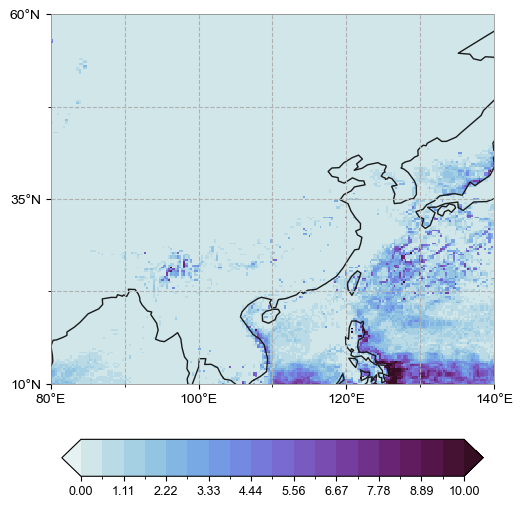

In [29]:
from utils import plot
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

crr_obs = surface_np_obs[0, CRR_IDX, 0] * 86400
crr_da_obs = xr.DataArray(
            crr_obs,
            coords=[("lat", lat), ("lon", lon)],
            name="precipitation (mm/day)",
        )

fig = plt.figure()
proj = ccrs.PlateCarree() #ccrs.Robinson()ccrs.Mollweide()Mollweide()
ax = fig.add_subplot(111, projection=proj)
levels = np.linspace(0, 10, num=19)
plot.one_map_region(crr_da_obs, ax, levels=levels, cmap=cmaps.cmocean_dense, extents=[80, 140, 10, 60], interval=[20, 25], mask_ocean=False, add_coastlines=True, add_land=True, add_gridlines=True, colorbar=True, plotfunc="pcolormesh")

/home/CanglongPhysics/utils/plot.py:672: FutureWarning: `ax1` has been deprecated in favor of `ax`
  cbar = mpu.colorbar(**colorbar_opt)


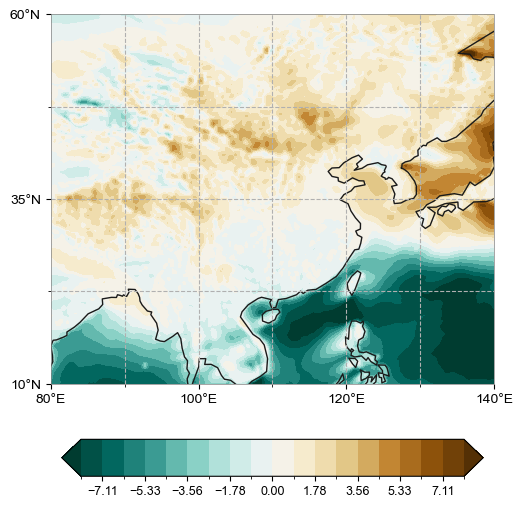

In [30]:
from utils import plot
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

u10_obs = surface_np_obs[0, 7, 0]
u10_da_obs = xr.DataArray(
            u10_obs,
            coords=[("lat", lat), ("lon", lon)],
            name="u 10 m/s",
        )

fig = plt.figure()
proj = ccrs.PlateCarree() #ccrs.Robinson()ccrs.Mollweide()Mollweide()
ax = fig.add_subplot(111, projection=proj)
levels = np.linspace(-8, 8, num=19)
plot.one_map_region(u10_da_obs, ax, levels=levels, cmap='BrBG_r', extents=[80, 140, 10, 60], interval=[20, 25], mask_ocean=False, add_coastlines=True, add_land=True, add_gridlines=True, colorbar=True, plotfunc="contourf")

/home/CanglongPhysics/utils/plot.py:672: FutureWarning: `ax1` has been deprecated in favor of `ax`
  cbar = mpu.colorbar(**colorbar_opt)


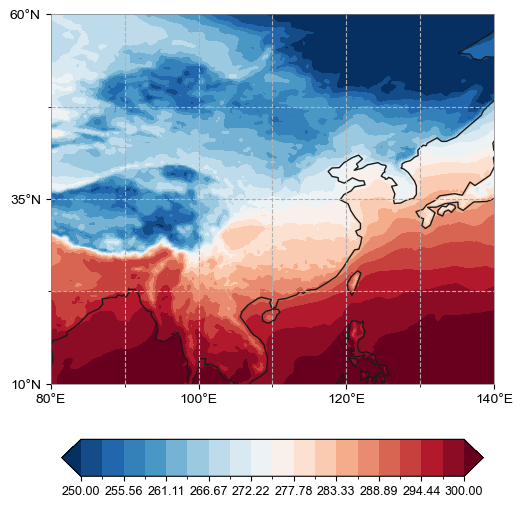

In [32]:
from utils import plot
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

t2m_obs = surface_np_obs[0, 10, 0]
t2m_da_obs = xr.DataArray(
            t2m_obs,
            coords=[("lat", lat), ("lon", lon)],
            name="K",
        )

fig = plt.figure()
proj = ccrs.PlateCarree() #ccrs.Robinson()ccrs.Mollweide()Mollweide()
ax = fig.add_subplot(111, projection=proj)
levels = np.linspace(250, 300, num=19)
plot.one_map_region(t2m_da_obs, ax, levels=levels, cmap='RdBu_r', extents=[80, 140, 10, 60], interval=[20, 25], mask_ocean=False, add_coastlines=True, add_land=True, add_gridlines=True, colorbar=True, plotfunc="contourf")

/home/CanglongPhysics/utils/plot.py:116: FutureWarning: `ax1` has been deprecated in favor of `ax`
  cbar = mpu.colorbar(**colorbar_opt)
/home/CanglongPhysics/utils/plot.py:116: FutureWarning: `ax1` has been deprecated in favor of `ax`
  cbar = mpu.colorbar(**colorbar_opt)
/home/CanglongPhysics/utils/plot.py:116: FutureWarning: `ax1` has been deprecated in favor of `ax`
  cbar = mpu.colorbar(**colorbar_opt)
/home/CanglongPhysics/utils/plot.py:116: FutureWarning: `ax1` has been deprecated in favor of `ax`
  cbar = mpu.colorbar(**colorbar_opt)
/home/CanglongPhysics/utils/plot.py:116: FutureWarning: `ax1` has been deprecated in favor of `ax`
  cbar = mpu.colorbar(**colorbar_opt)
/home/CanglongPhysics/utils/plot.py:116: FutureWarning: `ax1` has been deprecated in favor of `ax`
  cbar = mpu.colorbar(**colorbar_opt)
/tmp/ipykernel_271/1684766606.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


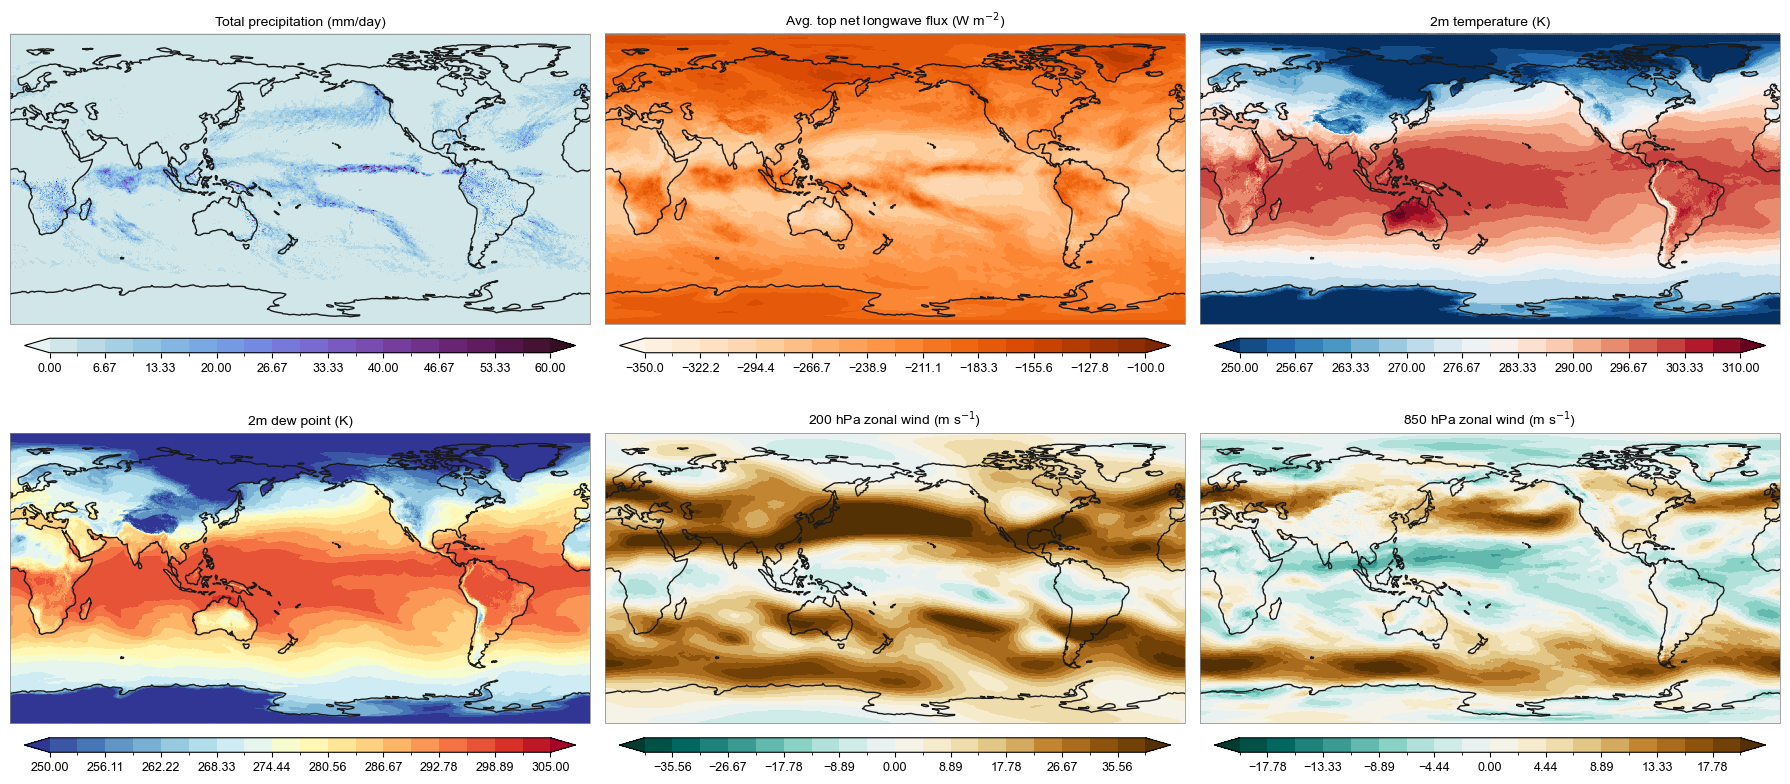

In [5]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmaps
from matplotlib import font_manager
import os

# 在导入cartopy之前设置环境变量
os.environ['PROJ_DATA'] = '/usr/local/miniconda3/envs/torch/share/proj'
from utils import plot

# Configure Arial font as required for all plots
font_path = "/root/ARIAL.TTF"
try:
    font_manager.fontManager.addfont(font_path)
    plt.rcParams["font.family"] = font_manager.FontProperties(fname=font_path).get_name()
except FileNotFoundError:
    plt.rcParams["font.family"] = "Arial"

# Common coordinates
lat = np.linspace(90, -90, 721)
lon = np.linspace(0, 359.75, 1440)

# Helper to move tensor data onto CPU numpy arrays
cpu_numpy = lambda tensor: tensor.detach().cpu().numpy()

# Prepare all fields before plotting


surface_np = cpu_numpy(target_surface)
upper_air_np = cpu_numpy(target_upper_air)

avg_tnlwrf = surface_np[0, AVG_TNLWRF_IDX, 0]
t2m = surface_np[0, T2M_IDX, 0]
d2m = surface_np[0, D2M_IDX, 0]
u200 = upper_air_np[0, U_VAR_IDX, u200_level_idx, 0]
u850 = upper_air_np[0, U_VAR_IDX, u850_level_idx, 0]
precip_mm_day = surface_np[0, LSRR_IDX, 0] * 86400.0 + surface_np[0, CRR_IDX, 0] * 86400.0

plot_configs = [
    {
        "data": xr.DataArray(
            precip_mm_day,
            coords=[("lat", lat), ("lon", lon)],
            name="Total precipitation (mm/day)",
        ),
        "levels": np.linspace(0, 60, num=19),
        "cmap": cmaps.cmocean_dense,
    },
    {
        "data": xr.DataArray(
            avg_tnlwrf,
            coords=[("lat", lat), ("lon", lon)],
            name="Avg. top net longwave flux (W m$^{-2}$)",
        ),
        "levels": np.linspace(-350, -100, num=19),
        "cmap": "Oranges",
    },
    {
        "data": xr.DataArray(
            t2m,
            coords=[("lat", lat), ("lon", lon)],
            name="2m temperature (K)",
        ),
        "levels": np.linspace(250, 310, num=19),
        "cmap": "RdBu_r",
    },
    {
        "data": xr.DataArray(
            d2m,
            coords=[("lat", lat), ("lon", lon)],
            name="2m dew point (K)",
        ),
        "levels": np.linspace(250, 305, num=19),
        "cmap": "RdYlBu_r",
    },
    {
        "data": xr.DataArray(
            u200,
            coords=[("lat", lat), ("lon", lon)],
            name="200 hPa zonal wind (m s$^{-1}$)",
        ),
        "levels": np.linspace(-40, 40, num=19),
        "cmap": "BrBG_r",
    },
    {
        "data": xr.DataArray(
            u850,
            coords=[("lat", lat), ("lon", lon)],
            name="850 hPa zonal wind (m s$^{-1}$)",
        ),
        "levels": np.linspace(-20, 20, num=19),
        "cmap": "BrBG_r",
    },
]

fig, axes = plt.subplots(
    nrows=2,
    ncols=3,
    figsize=(18, 9),
    subplot_kw={"projection": ccrs.PlateCarree(central_longitude=180.0)}, #PlateCarree(central_longitude=0.0, globe=None) Robinson
)
axes = axes.flatten()

for ax, cfg in zip(axes, plot_configs):
    plot.one_map_flat(
        cfg["data"],
        ax,
        levels=cfg["levels"],
        cmap=cfg["cmap"],
        mask_ocean=False,
        add_coastlines=True,
        add_land=False,
        plotfunc="pcolormesh",
        colorbar=True,
    )
    ax.set_title(cfg["data"].name, fontsize=10, pad=6)

for ax in axes[len(plot_configs):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()


/home/CanglongPhysics/utils/plot.py:116: FutureWarning: `ax1` has been deprecated in favor of `ax`
  cbar = mpu.colorbar(**colorbar_opt)


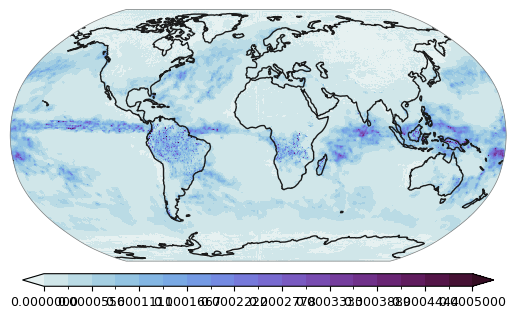

In [11]:
from utils import plot
import xarray as xr
import cmaps
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

lat = np.linspace(90, -90, 721)
lon = np.linspace(0, 359.75, 1440)
dataarray = xr.DataArray(
    pred_total_precip.cpu().numpy()[0],
    coords=[("lat", lat), ("lon", lon)],
    name="tp"
)
fig = plt.figure()
proj = ccrs.Robinson() #ccrs.Robinson()ccrs.Mollweide()Mollweide()
ax = fig.add_subplot(111, projection=proj)
levels = np.linspace(0, 0.0005, num=19)
plot.one_map_flat(dataarray, ax, levels=levels, cmap=cmaps.cmocean_dense, mask_ocean=False, add_coastlines=True, add_land=False, plotfunc="pcolormesh", colorbar=True)


/home/CanglongPhysics/utils/plot.py:116: FutureWarning: `ax1` has been deprecated in favor of `ax`
  cbar = mpu.colorbar(**colorbar_opt)


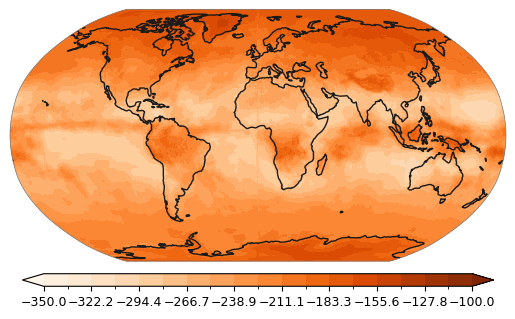

In [27]:
from utils import plot
import xarray as xr
lat = np.linspace(90, -90, 721)
lon = np.linspace(0, 359.75, 1440)
dataarray = xr.DataArray(
    output_surface[0, 9, 0, :, :].cpu().numpy(),
    coords=[("lat", lat), ("lon", lon)],
    name="avg_tnlwrf"
)
fig = plt.figure()
proj = ccrs.Robinson() #ccrs.Robinson()ccrs.Mollweide()Mollweide()
ax = fig.add_subplot(111, projection=proj)
levels = np.linspace(-350, -100, num=19)
plot.one_map_flat(dataarray, ax, levels=levels, cmap='Oranges', mask_ocean=False, add_coastlines=True, add_land=False, plotfunc="pcolormesh", colorbar=True)


/home/CanglongPhysics/utils/plot.py:116: FutureWarning: `ax1` has been deprecated in favor of `ax`
  cbar = mpu.colorbar(**colorbar_opt)


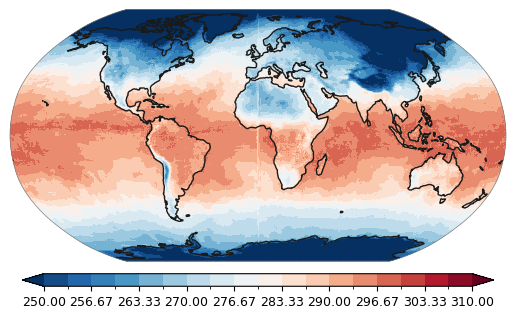

In [18]:
from utils import plot
import xarray as xr
import cmaps
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

lat = np.linspace(90, -90, 721)
lon = np.linspace(0, 359.75, 1440)
dataarray = xr.DataArray(
    output_surface[0, 7, 0, :, :].cpu().numpy(),
    coords=[("lat", lat), ("lon", lon)],
    name="t2m"
)
fig = plt.figure()
proj = ccrs.Robinson() #ccrs.Robinson()ccrs.Mollweide()Mollweide()
ax = fig.add_subplot(111, projection=proj)
levels = np.linspace(250, 310, num=19)
plot.one_map_flat(dataarray, ax, levels=levels, cmap='RdBu_r', mask_ocean=False, add_coastlines=True, add_land=False, plotfunc="pcolormesh", colorbar=True)


/home/CanglongPhysics/utils/plot.py:116: FutureWarning: `ax1` has been deprecated in favor of `ax`
  cbar = mpu.colorbar(**colorbar_opt)


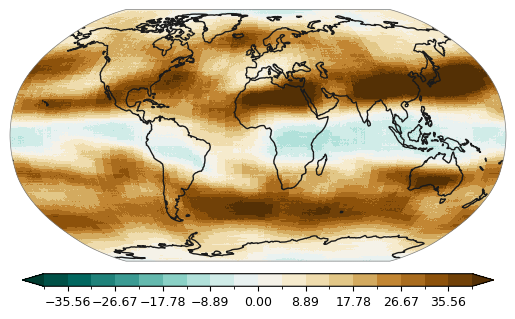

In [37]:
from utils import plot
import xarray as xr
import cmaps
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

lat = np.linspace(90, -90, 721)
lon = np.linspace(0, 359.75, 1440)
dataarray = xr.DataArray(
    output_upper_air[0, 2, 0, 0, :, :].cpu().numpy(),
    coords=[("lat", lat), ("lon", lon)],
    name="200u"
)
fig = plt.figure()
proj = ccrs.Robinson() #ccrs.Robinson()ccrs.Mollweide()Mollweide()
ax = fig.add_subplot(111, projection=proj)
levels = np.linspace(-40, 40, num=19)
plot.one_map_flat(dataarray, ax, levels=levels, cmap='BrBG_r', mask_ocean=False, add_coastlines=True, add_land=False, plotfunc="pcolormesh", colorbar=True)


/home/CanglongPhysics/utils/plot.py:116: FutureWarning: `ax1` has been deprecated in favor of `ax`
  cbar = mpu.colorbar(**colorbar_opt)


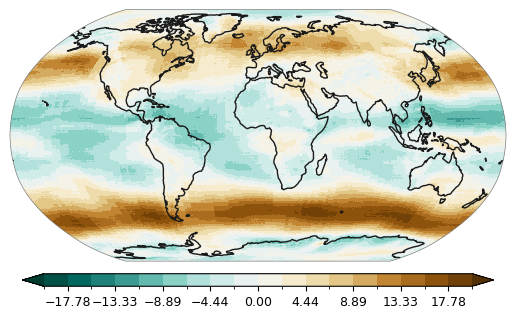

In [45]:
from utils import plot
import xarray as xr
import cmaps
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

lat = np.linspace(90, -90, 721)
lon = np.linspace(0, 359.75, 1440)
dataarray = xr.DataArray(
    output_upper_air[0, 2, 4, 0, :, :].cpu().numpy(),
    coords=[("lat", lat), ("lon", lon)],
    name="850u"
)
fig = plt.figure()
proj = ccrs.Robinson() #ccrs.Robinson()ccrs.Mollweide()Mollweide()
ax = fig.add_subplot(111, projection=proj)
levels = np.linspace(-20, 20, num=19)
plot.one_map_flat(dataarray, ax, levels=levels, cmap='BrBG_r', mask_ocean=False, add_coastlines=True, add_land=False, plotfunc="pcolormesh", colorbar=True)


In [34]:
output_upper_air.shape

torch.Size([1, 7, 5, 1, 721, 1440])

In [35]:
output_upper_air[0, 2, 0, 0, :, :].cpu().numpy()

array([[-5.787468  , -5.6993523 , -6.129038  , ..., -4.6931534 ,
        -4.768276  , -4.4954567 ],
       [-4.993778  , -5.480831  , -5.1118336 , ..., -4.699297  ,
        -4.2251186 , -3.5560455 ],
       [-5.0407314 , -4.4520473 , -4.6060486 , ..., -3.9267902 ,
        -4.490553  , -5.028574  ],
       ...,
       [ 0.9498596 ,  1.3490543 ,  1.0781851 , ...,  1.2576408 ,
         0.9014578 ,  0.3801794 ],
       [ 1.4341612 ,  1.1965742 ,  1.4879122 , ...,  0.94414234,
         1.2226734 ,  1.6245909 ],
       [ 0.8089733 ,  1.2403812 ,  0.9738846 , ...,  0.795002  ,
         0.6327276 ,  0.19065666]], dtype=float32)

实际观测

/home/CanglongPhysics/utils/plot.py:116: FutureWarning: `ax1` has been deprecated in favor of `ax`
  cbar = mpu.colorbar(**colorbar_opt)


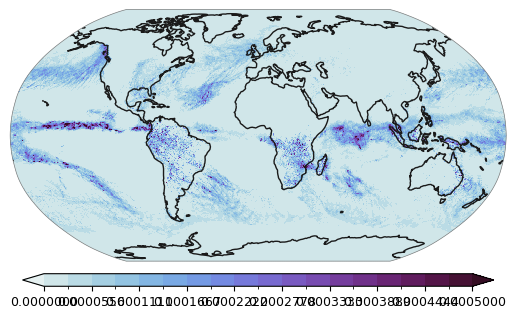

In [6]:
from utils import plot
import xarray as xr
lat = np.linspace(90, -90, 721)
lon = np.linspace(0, 359.75, 1440)
dataarray = xr.DataArray(
    true_total_precip.cpu().numpy()[0],
    coords=[("lat", lat), ("lon", lon)],
    name="sst"
)
fig = plt.figure()
proj = ccrs.Robinson() #ccrs.Robinson()ccrs.Mollweide()Mollweide()
ax = fig.add_subplot(111, projection=proj)
levels = np.linspace(0, 0.0005, num=19)
plot.one_map_flat(dataarray, ax, levels=levels, cmap=cmaps.cmocean_dense, mask_ocean=False, add_coastlines=True, add_land=False, plotfunc="pcolormesh", colorbar=True)


/home/CanglongPhysics/utils/plot.py:116: FutureWarning: `ax1` has been deprecated in favor of `ax`
  cbar = mpu.colorbar(**colorbar_opt)


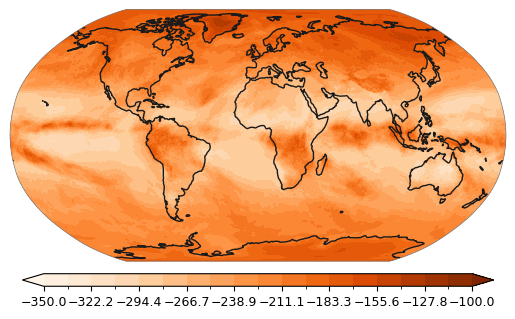

In [24]:
from utils import plot
import xarray as xr
lat = np.linspace(90, -90, 721)
lon = np.linspace(0, 359.75, 1440)
dataarray = xr.DataArray(
    target_surface[0, 9, 0, :, :].cpu().numpy(),
    coords=[("lat", lat), ("lon", lon)],
    name="avg_tnlwrf"
)
fig = plt.figure()
proj = ccrs.Robinson() #ccrs.Robinson()ccrs.Mollweide()Mollweide()
ax = fig.add_subplot(111, projection=proj)
levels = np.linspace(-350, -100, num=19)
plot.one_map_flat(dataarray, ax, levels=levels, cmap='Oranges', mask_ocean=False, add_coastlines=True, add_land=False, plotfunc="pcolormesh", colorbar=True)


/home/CanglongPhysics/utils/plot.py:116: FutureWarning: `ax1` has been deprecated in favor of `ax`
  cbar = mpu.colorbar(**colorbar_opt)


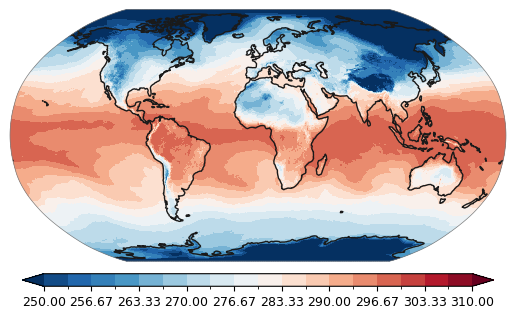

In [19]:
from utils import plot
import xarray as xr
import cmaps
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

lat = np.linspace(90, -90, 721)
lon = np.linspace(0, 359.75, 1440)
dataarray = xr.DataArray(
    target_surface[0, 7, 0, :, :].cpu().numpy(),
    coords=[("lat", lat), ("lon", lon)],
    name="t2m"
)
fig = plt.figure()
proj = ccrs.Robinson() #ccrs.Robinson()ccrs.Mollweide()Mollweide()
ax = fig.add_subplot(111, projection=proj)
levels = np.linspace(250, 310, num=19)
plot.one_map_flat(dataarray, ax, levels=levels, cmap='RdBu_r', mask_ocean=False, add_coastlines=True, add_land=False, plotfunc="pcolormesh", colorbar=True)


In [41]:
target_upper_air.shape

torch.Size([1, 17, 1, 721, 1440])

/home/CanglongPhysics/utils/plot.py:116: FutureWarning: `ax1` has been deprecated in favor of `ax`
  cbar = mpu.colorbar(**colorbar_opt)


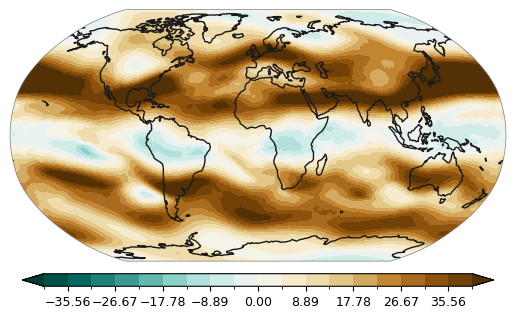

In [43]:
from utils import plot
import xarray as xr
import cmaps
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

lat = np.linspace(90, -90, 721)
lon = np.linspace(0, 359.75, 1440)
dataarray = xr.DataArray(
    target_upper_air[0, 2, 0, 0, :, :].cpu().numpy(),
    coords=[("lat", lat), ("lon", lon)],
    name="200u"
)
fig = plt.figure()
proj = ccrs.Robinson() #ccrs.Robinson()ccrs.Mollweide()Mollweide()
ax = fig.add_subplot(111, projection=proj)
levels = np.linspace(-40, 40, num=19)
plot.one_map_flat(dataarray, ax, levels=levels, cmap='BrBG_r', mask_ocean=False, add_coastlines=True, add_land=False, plotfunc="pcolormesh", colorbar=True)


/home/CanglongPhysics/utils/plot.py:116: FutureWarning: `ax1` has been deprecated in favor of `ax`
  cbar = mpu.colorbar(**colorbar_opt)


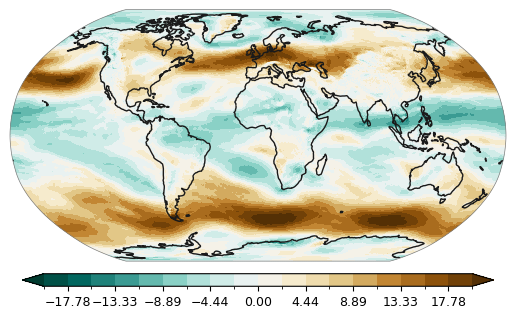

In [46]:
from utils import plot
import xarray as xr
import cmaps
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

lat = np.linspace(90, -90, 721)
lon = np.linspace(0, 359.75, 1440)
dataarray = xr.DataArray(
    target_upper_air[0, 2, 4, 0, :, :].cpu().numpy(),
    coords=[("lat", lat), ("lon", lon)],
    name="850u"
)
fig = plt.figure()
proj = ccrs.Robinson() #ccrs.Robinson()ccrs.Mollweide()Mollweide()
ax = fig.add_subplot(111, projection=proj)
levels = np.linspace(-20, 20, num=19)
plot.one_map_flat(dataarray, ax, levels=levels, cmap='BrBG_r', mask_ocean=False, add_coastlines=True, add_land=False, plotfunc="pcolormesh", colorbar=True)


In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import os
from tqdm import tqdm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# 变量列表及其统计信息
variables = [
    'lsrr',               # Large-scale precipitation rate
    'crr',                # Convective precipitation rate
    'tciw',               # Specific cloud ice
    'tcc',                # Total cloud cover
    'tsrc',               # Top net long-wave radiation flux
    'u10',                # 10m u wind component
    'v10',                # 10m v wind component
    'd2m',                # 2m dewpoint temperature
    't2m',                # 2m temperature
    'surface_latent_heat_flux',  # Surface latent heat flux
    'surface_sensible_heat_flux',  # Surface sensible heat flux
    'sp',                 # Surface pressure
    'swvl',               # Volumetric soil water
    'msl',                # Sea-level pressure
    'siconc',             # Sea ice
    'sst'                 # Sea surface temperature
]

# 变量的均值和标准差
var_stats = {
    'surface_latent_heat_flux': {'mean': -5410301.5, 'std': 5349063.5},
    'u10': {'mean': -0.068418466, 'std': 4.427545547},
    'd2m': {'mean': 274.2094421, 'std': 20.45770073},
    'msl': {'mean': 100972.3438, 'std': 1191.102417},
    'tsrc': {'mean': 856148, 'std': 534222.125},
    'crr': {'mean': 1.29E-05, 'std': 2.97E-05},
    'lsrr': {'mean': 1.10E-05, 'std': 2.55E-05},
    'siconc': {'mean': 0.785884917, 'std': 0.914535105},
    'tciw': {'mean': 0.022627383, 'std': 0.023428712},
    'swvl': {'mean': 0.34216917, 'std': 0.5484813},
    'v10': {'mean': 0.197138891, 'std': 3.09530735},
    't2m': {'mean': 278.7841187, 'std': 21.03286934},
    'surface_sensible_heat_flux': {'mean': -971651.375, 'std': 2276764.75},
    'tcc': {'mean': 0.673692584, 'std': 0.235167906},
    'sp': {'mean': 96651.14063, 'std': 9569.695313},
    'sst': {'mean': 189.7337189, 'std': 136.1803131}
}

class WeatherTestDataset(Dataset):
    def __init__(self, surface_data, upper_air_data, start_idx, end_idx):
        """
        初始化测试数据集
        
        参数:
            surface_data: 表面数据，形状为 [16, 100, 721, 1440]
            upper_air_data: 高空数据，形状为 [7, 4, 100, 721, 1440]
            start_idx: 开始索引
            end_idx: 结束索引
        """
        self.surface_data = surface_data[:, start_idx:end_idx]
        self.upper_air_data = upper_air_data[:, :, start_idx:end_idx]
        self.length = end_idx - start_idx - 2  # 减2确保有足够的目标数据
        
        print(f"Test dataset from index {start_idx} to {end_idx}, sample count: {self.length}")
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        # 提取输入数据 (t和t+1时刻)
        input_surface = self.surface_data[:, idx:idx+2]  # [1, 16, 2, 721, 1440]
        
        # 提取高空数据 (t和t+1时刻)
        input_upper_air = self.upper_air_data[:, :, idx:idx+2]  # [1, 7, 4, 2, 721, 1440]
        
        # 提取目标数据 (t+2时刻)
        target_surface = self.surface_data[:, idx+2]  # [1, 16, 721, 1440]
        
        return input_surface, input_upper_air, target_surface, idx

def denormalize(data, var_idx):
    """反标准化数据"""
    var_name = variables[var_idx]
    mean = var_stats[var_name]['mean']
    std = var_stats[var_name]['std']
    return data * std + mean

# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 加载数据
print("Loading data...")
input_surface_load = torch.load('I:/ERA5_np/input_surface_norm_test_last100.pt')
input_upper_air_load = torch.load('I:/ERA5_np/input_upper_air_norm_test_last100.pt')
print(f"Surface data shape: {input_surface_load.shape}")
print(f"Upper air data shape: {input_upper_air_load.shape}")

Using device: cuda
Loading data...
Surface data shape: torch.Size([16, 100, 721, 1440])
Upper air data shape: torch.Size([7, 4, 100, 721, 1440])


In [30]:
input_surface_load.shape
total_rain = denormalize(input_surface_load[variables.index('lsrr'), :, :, :], variables.index('lsrr')) + denormalize(input_surface_load[variables.index('crr'), :, :, :], variables.index('crr'))
total_rain.shape
# 使用torch.mean代替np.mean，因为total_rain是torch.Tensor
total_rain_mean = torch.mean(total_rain, dim=0).numpy()

total_rain_mean.shape

(721, 1440)

In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import scipy.stats as stats
# 计算测试集的索引范围 (使用后20%)
total_samples = 100  # 假设为100
test_start = int(total_samples * 0.2)  # 80
test_end = total_samples  # 100

# 创建测试数据集
test_dataset = WeatherTestDataset(input_surface_load, input_upper_air_load, test_start, test_end)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
print(f"Created test data loader with {len(test_dataset)} samples")

# 加载模型
model_path = 'I:/model/model_v1_100.pth'  # 使用最佳模型
print(f"Loading model from {model_path}...")
model = torch.load(model_path)
print("Complete model loaded successfully")
lsrr_idx = variables.index('lsrr')  # 大尺度降水率索引
crr_idx = variables.index('crr')    # 对流降水率索引
var_idx = variables.index('sst')

model.to(device)
model.eval()  
predictions = []
targets = []
indices = []
pcc_values = []  # 存储每个样本的PCC值
acc_values = []  # 存储每个样本的ACC值

with torch.no_grad():
    for input_surface, input_upper_air, target_surface, idx in test_loader:
        # 将数据移动到设备
        input_surface = input_surface.to(device)
        input_upper_air = input_upper_air.to(device)
        
        # 前向传播
        output_surface, _ = model(input_surface, input_upper_air)
        
        # 收集结果
        predictions.append(output_surface.cpu())
        targets.append(target_surface.cpu())
        indices.append(idx.item())

        first_sample_idx = int(idx)  # 取第一个样本
        # 反标准化第一个样本的预测降水率
        pred_lsrr = denormalize(predictions[first_sample_idx][0, lsrr_idx, 0].numpy(), lsrr_idx)
        pred_crr = denormalize(predictions[first_sample_idx][0, crr_idx, 0].numpy(), crr_idx)
        pred_total_precip = pred_lsrr + pred_crr  # 总降水率

        # 反标准化第一个样本的真实降水率
        true_lsrr = denormalize(targets[first_sample_idx][0, lsrr_idx].numpy(), lsrr_idx)
        true_crr = denormalize(targets[first_sample_idx][0, crr_idx].numpy(), crr_idx)
        true_total_precip = true_lsrr + true_crr  # 总降水率

        pre_var = denormalize(predictions[first_sample_idx][0, var_idx, 0].numpy(), var_idx)
        true_var = denormalize(targets[first_sample_idx][0, var_idx].numpy(), var_idx)

        # 计算并存储PCC和ACC
        pcc, _ = stats.pearsonr(true_total_precip.flatten(), pred_total_precip.flatten())
        acc, _ = stats.pearsonr(true_total_precip.flatten() - total_rain_mean.flatten(), pred_total_precip.flatten() - total_rain_mean.flatten())
        pcc_values.append(pcc)
        acc_values.append(acc)
        
        print(f"Correlation Coefficients - PCC: {pcc:.8f}, ACC: {acc:.8f}")
        # if int(idx) == 0:
        #     break

# 计算平均PCC和ACC
avg_pcc = sum(pcc_values) / len(pcc_values)
avg_acc = sum(acc_values) / len(acc_values)
print(f"\nAverage Correlation Coefficients across test set:")
print(f"Average PCC: {avg_pcc:.8f}")
print(f"Average ACC: {avg_acc:.8f}")


Test dataset from index 20 to 100, sample count: 78
Created test data loader with 78 samples
Loading model from I:/model/model_v1_100.pth...
Complete model loaded successfully
Correlation Coefficients - PCC: 0.48583440, ACC: 0.17387418
Correlation Coefficients - PCC: 0.48724304, ACC: 0.20856283
Correlation Coefficients - PCC: 0.54709221, ACC: 0.30468506
Correlation Coefficients - PCC: 0.47020556, ACC: 0.20940591
Correlation Coefficients - PCC: 0.53178103, ACC: 0.28364254
Correlation Coefficients - PCC: 0.44106116, ACC: 0.20490520
Correlation Coefficients - PCC: 0.43211491, ACC: 0.17439806
Correlation Coefficients - PCC: 0.46407052, ACC: 0.25934573
Correlation Coefficients - PCC: 0.41004729, ACC: 0.17037049
Correlation Coefficients - PCC: 0.43909521, ACC: 0.21248419
Correlation Coefficients - PCC: 0.45740376, ACC: 0.24589529
Correlation Coefficients - PCC: 0.43707267, ACC: 0.22459119
Correlation Coefficients - PCC: 0.41410398, ACC: 0.16570204
Correlation Coefficients - PCC: 0.50319403, 

In [14]:
# 反标准化第一个样本的预测结果和真实值
print("Denormalizing results...")
first_sample_idx = 0  # 取第一个样本

lsrr_idx = variables.index('lsrr')  # 大尺度降水率索引
crr_idx = variables.index('crr')    # 对流降水率索引
# 反标准化第一个样本的预测降水率
pred_lsrr = denormalize(predictions[first_sample_idx][0, lsrr_idx, 0].numpy(), lsrr_idx)
pred_crr = denormalize(predictions[first_sample_idx][0, crr_idx, 0].numpy(), crr_idx)
pred_total_precip = pred_lsrr + pred_crr  # 总降水率

# 反标准化第一个样本的真实降水率
true_lsrr = denormalize(targets[first_sample_idx][0, lsrr_idx].numpy(), lsrr_idx)
true_crr = denormalize(targets[first_sample_idx][0, crr_idx].numpy(), crr_idx)
true_total_precip = true_lsrr + true_crr  # 总降水率



# 计算统计指标
from sklearn.metrics import mean_squared_error, mean_absolute_error
import scipy.stats as stats

mse = mean_squared_error(true_total_precip.flatten(), pred_total_precip.flatten())
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_total_precip.flatten(), pred_total_precip.flatten())

# 计算PCC空间相关性系数
pcc, _ = stats.pearsonr(true_total_precip.flatten(), pred_total_precip.flatten())

print("\nStatistical Metrics for Total Precipitation Rate:")
print(f"Root Mean Square Error (RMSE): {rmse:.8f} m/s")
print(f"Mean Absolute Error (MAE): {mae:.8f} m/s")
print(f"Pearson Correlation Coefficient (PCC): {pcc:.8f}")


Denormalizing results...

Statistical Metrics for Total Precipitation Rate:
Root Mean Square Error (RMSE): 0.00005251 m/s
Mean Absolute Error (MAE): 0.00002508 m/s
Pearson Correlation Coefficient (PCC): 0.39416888


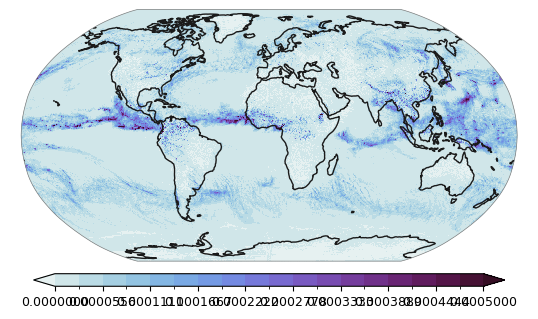

In [15]:
from utils import plot
import xarray as xr
import cmaps
lat = np.linspace(90, -90, 721)
lon = np.linspace(0, 359.75, 1440)
dataarray = xr.DataArray(
    pred_total_precip,
    coords=[("lat", lat), ("lon", lon)],
    name="sst"
)
fig = plt.figure()
proj = ccrs.Robinson() #ccrs.Robinson()ccrs.Mollweide()Mollweide()
ax = fig.add_subplot(111, projection=proj)
levels = np.linspace(0, 0.0005, num=19)
plot.one_map_flat(dataarray, ax, levels=levels, cmap=cmaps.cmocean_dense, mask_ocean=False, add_coastlines=True, add_land=False, plotfunc="pcolormesh", colorbar=True)


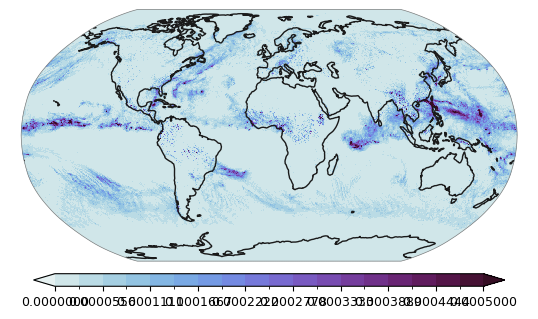

In [16]:
from utils import plot
import xarray as xr
lat = np.linspace(90, -90, 721)
lon = np.linspace(0, 359.75, 1440)
dataarray = xr.DataArray(
    true_total_precip,
    coords=[("lat", lat), ("lon", lon)],
    name="sst"
)
fig = plt.figure()
proj = ccrs.Robinson() #ccrs.Robinson()ccrs.Mollweide()Mollweide()
ax = fig.add_subplot(111, projection=proj)
levels = np.linspace(0, 0.0005, num=19)
plot.one_map_flat(dataarray, ax, levels=levels, cmap=cmaps.cmocean_dense, mask_ocean=False, add_coastlines=True, add_land=False, plotfunc="pcolormesh", colorbar=True)


## v2中等数据

In [27]:
output_surface, output_upper_air = model(input_surface, input_upper_air)

In [28]:
output_upper_air.shape

torch.Size([1, 7, 4, 2, 721, 1440])

In [29]:
output_surface.shape

torch.Size([1, 16, 2, 721, 1440])

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import os
from tqdm import tqdm
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# 设置滚动预报的周数
week = 3  # 预测未来3周

# 变量列表及其统计信息
variables = [
    'lsrr',               # Large-scale precipitation rate
    'crr',                # Convective precipitation rate
    'tciw',               # Specific cloud ice
    'tcc',                # Total cloud cover
    'tsrc',               # Top net long-wave radiation flux
    'u10',                # 10m u wind component
    'v10',                # 10m v wind component
    'd2m',                # 2m dewpoint temperature
    't2m',                # 2m temperature
    'surface_latent_heat_flux',  # Surface latent heat flux
    'surface_sensible_heat_flux',  # Surface sensible heat flux
    'sp',                 # Surface pressure
    'swvl',               # Volumetric soil water
    'msl',                # Sea-level pressure
    'siconc',             # Sea ice
    'sst'                 # Sea surface temperature
]

# 变量的均值和标准差
var_stats = {
    'surface_latent_heat_flux': {'mean': -5410301.5, 'std': 5349063.5},
    'u10': {'mean': -0.068418466, 'std': 4.427545547},
    'd2m': {'mean': 274.2094421, 'std': 20.45770073},
    'msl': {'mean': 100972.3438, 'std': 1191.102417},
    'tsrc': {'mean': 856148, 'std': 534222.125},
    'crr': {'mean': 1.29E-05, 'std': 2.97E-05},
    'lsrr': {'mean': 1.10E-05, 'std': 2.55E-05},
    'siconc': {'mean': 0.785884917, 'std': 0.914535105},
    'tciw': {'mean': 0.022627383, 'std': 0.023428712},
    'swvl': {'mean': 0.34216917, 'std': 0.5484813},
    'v10': {'mean': 0.197138891, 'std': 3.09530735},
    't2m': {'mean': 278.7841187, 'std': 21.03286934},
    'surface_sensible_heat_flux': {'mean': -971651.375, 'std': 2276764.75},
    'tcc': {'mean': 0.673692584, 'std': 0.235167906},
    'sp': {'mean': 96651.14063, 'std': 9569.695313},
    'sst': {'mean': 189.7337189, 'std': 136.1803131}
}

class WeatherTestDataset(Dataset):
    def __init__(self, surface_data, upper_air_data, start_idx, end_idx, forecast_week=3):
        """
        初始化测试数据集
        
        参数:
            surface_data: 表面数据，形状为 [16, 100, 721, 1440]
            upper_air_data: 高空数据，形状为 [7, 4, 100, 721, 1440]
            start_idx: 开始索引
            end_idx: 结束索引
            forecast_week: 预测的周数，默认为3周
        """
        self.surface_data = surface_data[:, start_idx:end_idx]
        self.upper_air_data = upper_air_data[:, :, start_idx:end_idx]
        self.forecast_week = forecast_week
        self.length = end_idx - start_idx - forecast_week  # 确保有足够的目标数据
        
        print(f"Test dataset from index {start_idx} to {end_idx}, forecast week: {forecast_week}, sample count: {self.length}")
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        # 提取输入数据 (t和t+1时刻)
        input_surface = self.surface_data[:, idx:idx+2]  # [1, 16, 2, 721, 1440]
        
        # 提取高空数据 (t和t+1时刻)
        input_upper_air = self.upper_air_data[:, :, idx:idx+2]  # [1, 7, 4, 2, 721, 1440]
        
        # 提取目标数据 (t+forecast_week时刻)
        target_surface = self.surface_data[:, idx+self.forecast_week]  # [1, 16, 721, 1440]
        
        return input_surface, input_upper_air, target_surface, idx

def denormalize(data, var_idx):
    """反标准化数据"""
    var_name = variables[var_idx]
    mean = var_stats[var_name]['mean']
    std = var_stats[var_name]['std']
    return data * std + mean

# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 加载数据
print("Loading data...")
input_surface_load = torch.load('I:/ERA5_np/input_surface_norm_test_last100.pt')
input_upper_air_load = torch.load('I:/ERA5_np/input_upper_air_norm_test_last100.pt')
print(f"Surface data shape: {input_surface_load.shape}")
print(f"Upper air data shape: {input_upper_air_load.shape}")

Using device: cuda
Loading data...
Surface data shape: torch.Size([16, 100, 721, 1440])
Upper air data shape: torch.Size([7, 4, 100, 721, 1440])


In [4]:
input_surface_load.shape
total_rain = denormalize(input_surface_load[variables.index('lsrr'), :, :, :], variables.index('lsrr')) + denormalize(input_surface_load[variables.index('crr'), :, :, :], variables.index('crr'))
total_rain.shape
# 使用torch.mean代替np.mean，因为total_rain是torch.Tensor
total_rain_mean = torch.mean(total_rain, dim=0).numpy()

total_rain_mean.shape

(721, 1440)

In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import scipy.stats as stats
# 计算测试集的索引范围 (使用后20%)
total_samples = 100  # 假设为100
test_start = int(total_samples * 0.8)  # 80
test_end = total_samples  # 100

# 创建测试数据集
test_dataset = WeatherTestDataset(input_surface_load, input_upper_air_load, test_start, test_end, forecast_week=3)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
print(f"Created test data loader with {len(test_dataset)} samples")

# 加载模型
model_path = 'I:/model/model_epoch_500.pt'  # 使用最佳模型
print(f"Loading model from {model_path}...")
model = torch.load(model_path)
print("Complete model loaded successfully")
lsrr_idx = variables.index('lsrr')  # 大尺度降水率索引
crr_idx = variables.index('crr')    # 对流降水率索引
var_idx = variables.index('sst')

model.to(device)
model.eval()  
predictions = []
targets = []
indices = []
pcc_values = []  # 存储每个样本的PCC值
acc_values = []  # 存储每个样本的ACC值
week = 3  # 设置滚动预报的周数

with torch.no_grad():
    for input_surface, input_upper_air, target_surface, idx in test_loader:
        # 将数据移动到设备
        input_surface = input_surface.to(device)
        input_upper_air = input_upper_air.to(device)
        target_surface = target_surface.to(device)
        
        # 存储滚动预报的结果
        all_surface_predictions = []
        all_upper_air_predictions = []
        
        # 初始输入
        current_input_surface = input_surface.clone()
        current_input_upper_air = input_upper_air.clone()
        
        # 滚动预报week周
        for w in range(week):
            # 前向传播
            output_surface, output_upper_air = model(current_input_surface, current_input_upper_air)
            
            # 存储当前周的预测结果
            all_surface_predictions.append(output_surface[:, :, 0:1, :, :])  # 只取第一个时间步
            all_upper_air_predictions.append(output_upper_air[:, :, :, 0:1, :, :])  # 只取第一个时间步
            
            if w < week - 1:  # 如果不是最后一周，准备下一周的输入
                # 更新输入：使用上一个时间步和新预测的时间步
                new_input_surface = torch.cat([
                    current_input_surface[:, :, 1:2, :, :],  # 取当前输入的第二个时间步
                    output_surface[:, :, 0:1, :, :]  # 取当前预测的第一个时间步
                ], dim=2)
                
                new_input_upper_air = torch.cat([
                    current_input_upper_air[:, :, :, 1:2, :, :],  # 取当前输入的第二个时间步
                    output_upper_air[:, :, :, 0:1, :, :]  # 取当前预测的第一个时间步
                ], dim=3)
                
                current_input_surface = new_input_surface
                current_input_upper_air = new_input_upper_air
        
        # 合并所有周的预测结果
        combined_surface_predictions = torch.cat(all_surface_predictions, dim=2)  # [1, 16, week, 721, 1440]
        
        # 收集第三周的预测结果（索引为2）
        predictions.append(all_surface_predictions[week-1].cpu())  # 取最后一周的预测
        targets.append(target_surface.cpu())
        indices.append(idx.item())

        # 反标准化第三周的预测降水率
        pred_lsrr = denormalize(all_surface_predictions[week-1][0, lsrr_idx, 0].cpu().numpy(), lsrr_idx)
        pred_crr = denormalize(all_surface_predictions[week-1][0, crr_idx, 0].cpu().numpy(), crr_idx)
        pred_total_precip = pred_lsrr + pred_crr  # 总降水率

        # 反标准化真实降水率
        true_lsrr = denormalize(target_surface[0, lsrr_idx].cpu().numpy(), lsrr_idx)
        true_crr = denormalize(target_surface[0, crr_idx].cpu().numpy(), crr_idx)
        true_total_precip = true_lsrr + true_crr  # 总降水率

        pre_var = denormalize(all_surface_predictions[week-1][0, var_idx, 0].cpu().numpy(), var_idx)
        true_var = denormalize(target_surface[0, var_idx].cpu().numpy(), var_idx)

        
        pcc, _ = stats.pearsonr(true_total_precip.flatten(), pred_total_precip.flatten())
        acc, _ = stats.pearsonr(true_total_precip.flatten() - total_rain_mean.flatten(), pred_total_precip.flatten() - total_rain_mean.flatten())
        pcc_values.append(pcc)
        acc_values.append(acc)
        
        print(f"Sample {idx.item()}, Week {week} - Correlation Coefficients - PCC: {pcc:.8f}, ACC: {acc:.8f}")

# 计算平均PCC和ACC (基于第三周的预测)
avg_pcc = sum(pcc_values) / len(pcc_values)
avg_acc = sum(acc_values) / len(acc_values)
print(f"\nAverage Correlation Coefficients across test set (Week {week}):")
print(f"Average PCC: {avg_pcc:.8f}")
print(f"Average ACC: {avg_acc:.8f}")
print(f"Successfully generated {week}-week rolling forecasts for all test samples")


Test dataset from index 80 to 100, forecast week: 3, sample count: 17
Created test data loader with 17 samples
Loading model from I:/model/model_epoch_500.pt...
Complete model loaded successfully
Sample 0, Week 3 - Correlation Coefficients - PCC: 0.46968061, ACC: 0.23212582
Sample 1, Week 3 - Correlation Coefficients - PCC: 0.43441446, ACC: 0.17349164
Sample 2, Week 3 - Correlation Coefficients - PCC: 0.46679058, ACC: 0.21522253
Sample 3, Week 3 - Correlation Coefficients - PCC: 0.46328837, ACC: 0.18437735
Sample 4, Week 3 - Correlation Coefficients - PCC: 0.41708312, ACC: 0.11546501
Sample 5, Week 3 - Correlation Coefficients - PCC: 0.42880533, ACC: 0.12602720
Sample 6, Week 3 - Correlation Coefficients - PCC: 0.42973204, ACC: 0.12616163
Sample 7, Week 3 - Correlation Coefficients - PCC: 0.42454746, ACC: 0.13722814
Sample 8, Week 3 - Correlation Coefficients - PCC: 0.42188281, ACC: 0.13132383
Sample 9, Week 3 - Correlation Coefficients - PCC: 0.48622649, ACC: 0.18757532
Sample 10, Wee

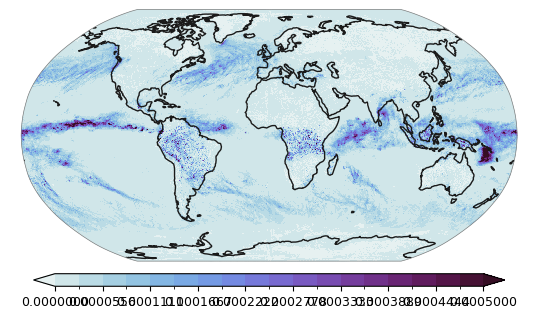

In [7]:
from utils import plot
import xarray as xr
import cmaps
lat = np.linspace(90, -90, 721)
lon = np.linspace(0, 359.75, 1440)
dataarray = xr.DataArray(
    pred_total_precip,
    coords=[("lat", lat), ("lon", lon)],
    name="sst"
)
fig = plt.figure()
proj = ccrs.Robinson() #ccrs.Robinson()ccrs.Mollweide()Mollweide()
ax = fig.add_subplot(111, projection=proj)
levels = np.linspace(0, 0.0005, num=19)
plot.one_map_flat(dataarray, ax, levels=levels, cmap=cmaps.cmocean_dense, mask_ocean=False, add_coastlines=True, add_land=False, plotfunc="pcolormesh", colorbar=True)


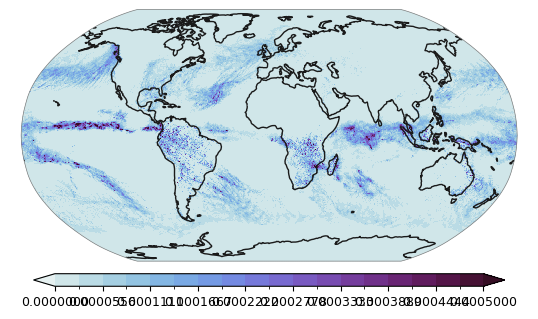

In [8]:
from utils import plot
import xarray as xr
lat = np.linspace(90, -90, 721)
lon = np.linspace(0, 359.75, 1440)
dataarray = xr.DataArray(
    true_total_precip,
    coords=[("lat", lat), ("lon", lon)],
    name="sst"
)
fig = plt.figure()
proj = ccrs.Robinson() #ccrs.Robinson()ccrs.Mollweide()Mollweide()
ax = fig.add_subplot(111, projection=proj)
levels = np.linspace(0, 0.0005, num=19)
plot.one_map_flat(dataarray, ax, levels=levels, cmap=cmaps.cmocean_dense, mask_ocean=False, add_coastlines=True, add_land=False, plotfunc="pcolormesh", colorbar=True)
